# TODO
局部的權重是否應降低、或是導入variance的概念？ 局部是顏色 形狀 斑點...等

In [1]:
#! -*- coding: utf-8 -*-
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import glob
import imageio
from keras.models import Model
from keras.layers import *
from keras import backend as K
from keras.optimizers import Adam
import tensorflow as tf
import numpy as np
import os
from sklearn.model_selection import train_test_split
from keras.applications.resnet import preprocess_input
from keras.models import Model, load_model
from keras.callbacks import ReduceLROnPlateau
from keras.callbacks import EarlyStopping
from keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.utils.data_utils import Sequence
from imblearn.over_sampling import RandomOverSampler
from imblearn.keras import balanced_batch_generator
from sklearn.utils import class_weight
from keras.backend import int_shape

Using TensorFlow backend.


In [2]:
def se_block(block_input, num_filters, ratio=8):                             # Squeeze and excitation block

    '''
        Args:
            block_input: input tensor to the squeeze and excitation block
            num_filters: no. of filters/channels in block_input
            ratio: a hyperparameter that denotes the ratio by which no. of channels will be reduced
            
        Returns:
            scale: scaled tensor after getting multiplied by new channel weights
    '''

    pool1 = GlobalAveragePooling2D()(block_input)
    flat = Reshape((1, 1, num_filters))(pool1)
    dense1 = Dense(num_filters//ratio, activation='relu')(flat)
    dense2 = Dense(num_filters, activation='sigmoid')(dense1)
    scale = multiply([block_input, dense2])
    
    return scale

In [3]:
def cbam_block(cbam_feature, ratio=8):
    """Contains the implementation of Convolutional Block Attention Module(CBAM) block.
    As described in https://arxiv.org/abs/1807.06521.
    """

    cbam_feature = channel_attention(cbam_feature, ratio)
    cbam_feature = spatial_attention(cbam_feature)
    return cbam_feature

def channel_attention(input_feature, ratio=8):

    channel_axis = 1 if K.image_data_format() == "channels_first" else -1
    channel = input_feature._keras_shape[channel_axis]

    shared_layer_one = Dense(channel//ratio,
                             activation='relu',
                             kernel_initializer='he_normal',
                             use_bias=True,
                             bias_initializer='zeros')
    shared_layer_two = Dense(channel,
                             kernel_initializer='he_normal',
                             use_bias=True,
                             bias_initializer='zeros')

    avg_pool = GlobalAveragePooling2D()(input_feature)    
    avg_pool = Reshape((1,1,channel))(avg_pool)
    assert avg_pool._keras_shape[1:] == (1,1,channel)
    avg_pool = shared_layer_one(avg_pool)
    assert avg_pool._keras_shape[1:] == (1,1,channel//ratio)
    avg_pool = shared_layer_two(avg_pool)
    assert avg_pool._keras_shape[1:] == (1,1,channel)

    max_pool = GlobalMaxPooling2D()(input_feature)
    max_pool = Reshape((1,1,channel))(max_pool)
    assert max_pool._keras_shape[1:] == (1,1,channel)
    max_pool = shared_layer_one(max_pool)
    assert max_pool._keras_shape[1:] == (1,1,channel//ratio)
    max_pool = shared_layer_two(max_pool)
    assert max_pool._keras_shape[1:] == (1,1,channel)

    cbam_feature = Add()([avg_pool,max_pool])
    cbam_feature = Activation('sigmoid')(cbam_feature)

    if K.image_data_format() == "channels_first":
        cbam_feature = Permute((3, 1, 2))(cbam_feature)

    return multiply([input_feature, cbam_feature])

def spatial_attention(input_feature):
    kernel_size = 7

    if K.image_data_format() == "channels_first":
        channel = input_feature._keras_shape[1]
        cbam_feature = Permute((2,3,1))(input_feature)
    else:
        channel = input_feature._keras_shape[-1]
        cbam_feature = input_feature

    avg_pool = Lambda(lambda x: K.mean(x, axis=3, keepdims=True))(cbam_feature)
    assert avg_pool._keras_shape[-1] == 1
    max_pool = Lambda(lambda x: K.max(x, axis=3, keepdims=True))(cbam_feature)
    assert max_pool._keras_shape[-1] == 1
    concat = Concatenate(axis=3)([avg_pool, max_pool])
    assert concat._keras_shape[-1] == 2
    cbam_feature = Conv2D(filters = 1,
                    kernel_size=kernel_size,
                    strides=1,
                    padding='same',
                    activation='sigmoid',
                    kernel_initializer='he_normal',
                    use_bias=False)(concat)	
    assert cbam_feature._keras_shape[-1] == 1

    if K.image_data_format() == "channels_first":
        cbam_feature = Permute((3, 1, 2))(cbam_feature)

    return multiply([input_feature, cbam_feature])

In [4]:
def identity_block(input_tensor, kernel_size, filters, stage, block):
    """The identity block is the block that has no conv layer at shortcut.
    # Arguments
        input_tensor: input tensor
        kernel_size: default 3, the kernel size of
            middle conv layer at main path
        filters: list of integers, the filters of 3 conv layer at main path
        stage: integer, current stage label, used for generating layer names
        block: 'a','b'..., current block label, used for generating layer names
    # Returns
        Output tensor for the block.
    """
    filters1, filters2, filters3 = filters
    
    if K.image_data_format() == 'channels_last':
        bn_axis = 3
    else:
        bn_axis = 1
    
    conv_name_base = 'res' + str(stage) + block + '_branch'
    bn_name_base = 'bn' + str(stage) + block + '_branch'

    x = Conv2D(filters1, (1, 1),
                      kernel_initializer='he_normal',
                      name=conv_name_base + '2a')(input_tensor)
    x = BatchNormalization(axis=bn_axis, name=bn_name_base + '2a')(x)
    x = Activation('relu')(x)

    x = Conv2D(filters2, kernel_size,
                      padding='same',
                      kernel_initializer='he_normal',
                      name=conv_name_base + '2b')(x)
    x = BatchNormalization(axis=bn_axis, name=bn_name_base + '2b')(x)
    x = Activation('relu')(x)
    
    x = Conv2D(filters3, (1, 1),
                      kernel_initializer='he_normal',
                      name=conv_name_base + '2c')(x)
    x = BatchNormalization(axis=bn_axis, name=bn_name_base + '2c')(x)
    
    # add the se_block
#     x = se_block(x, num_filters=filters3)
    # add the cbam block
    x = cbam_block(x)
    
    
    x = add([x, input_tensor])
    x = Activation('relu')(x)
    return x

In [5]:
def conv_block(input_tensor,
               kernel_size,
               filters,
               stage,
               block,
               strides=(2, 2)):
    """A block that has a conv layer at shortcut.
    # Arguments
        input_tensor: input tensor
        kernel_size: default 3, the kernel size of
            middle conv layer at main path
        filters: list of integers, the filters of 3 conv layer at main path
        stage: integer, current stage label, used for generating layer names
        block: 'a','b'..., current block label, used for generating layer names
        strides: Strides for the first conv layer in the block.
    # Returns
        Output tensor for the block.
    Note that from stage 3,
    the first conv layer at main path is with strides=(2, 2)
    And the shortcut should have strides=(2, 2) as well
    """
    filters1, filters2, filters3 = filters
    
    if K.image_data_format() == 'channels_last':
        bn_axis = 3
    else:
        bn_axis = 1
    
    
    conv_name_base = 'res' + str(stage) + block + '_branch'
    bn_name_base = 'bn' + str(stage) + block + '_branch'

    x = Conv2D(filters1, (1, 1), strides=strides,
                      kernel_initializer='he_normal',
                      name=conv_name_base + '2a')(input_tensor)
    x = BatchNormalization(axis=bn_axis, name=bn_name_base + '2a')(x)
    x = Activation('relu')(x)

    x = Conv2D(filters2, kernel_size, padding='same',
                      kernel_initializer='he_normal',
                      name=conv_name_base + '2b')(x)
    x = BatchNormalization(axis=bn_axis, name=bn_name_base + '2b')(x)
    x = Activation('relu')(x)
    
    x = Conv2D(filters3, (1, 1),
                      kernel_initializer='he_normal',
                      name=conv_name_base + '2c')(x)
    x = BatchNormalization(axis=bn_axis, name=bn_name_base + '2c')(x)
    
    
    # add the se_block
#     x = se_block(x, num_filters=filters3)
    # add the cbam block
    x = cbam_block(x)
    
    
    shortcut = Conv2D(filters3, (1, 1), strides=strides,
                             kernel_initializer='he_normal',
                             name=conv_name_base + '1')(input_tensor)
    shortcut = BatchNormalization(axis=bn_axis, name=bn_name_base + '1')(shortcut)

    x = add([x, shortcut])
    x = Activation('relu')(x)
    return x

In [6]:
class Scaler(Layer):
    def __init__(self, tau=0.5, **kwargs):
        super(Scaler, self).__init__(**kwargs)
        self.tau = tau
    
    def build(self, input_shape):
        super(Scaler, self).build(input_shape)
        self.scale = self.add_weight(
            name='scale', shape=(input_shape[-1],), initializer='zeros'
        )
    
    def call(self, inputs, mode='positive'):
        if mode == 'positive':
            scale = self.tau + (1 - self.tau) * K.sigmoid(self.scale)
        
        else:
            scale = (1 - self.tau) * K.sigmoid(-self.scale)
        
        return inputs * K.sqrt(scale)
    
    def get_config(self):
        config = {'tau': self.tau}
        base_config = super(Scaler, self).get_config()
        return dict(list(base_config.items()) + list(config.items()))

## Import Data

In [7]:
### change the dataset here###
dataset = 'AWA2'
##############################


batch_size = 32
train_dir = './data/{}/IMG/train'.format(dataset)
val_dir = './data/{}/IMG/val'.format(dataset)
IMG_SHAPE = 128
epochs = 50


alpha = 0.1 # 全局互信息的loss比重
beta = 0.3 # 局部互信息的loss比重
beta2 = 0
beta3 = 0
beta4 = 0
gamma = 1.8 # 先验分布的loss比重
# attr_type = 'b','c','cmm','cms'
attr_type = 'cms'

if dataset == 'SUN':
    class_attr_shape = (102, )
    class_attr_dim = 102
    class_num = 717
    seen_class_num = 645
    unseen_class_num = 72
elif dataset == 'CUB':
    class_attr_shape = (312, )
    class_attr_dim = 312
    class_num = 200
    seen_class_num = 150
    unseen_class_num = 50
elif dataset == 'AWA2':
    class_attr_shape = (85, )
    class_attr_dim = 85
    class_num = 50
    seen_class_num = 40
    unseen_class_num = 10
elif dataset == 'plant':
    class_attr_shape = (35, )
    class_attr_dim = 35
    class_num = 38
    seen_class_num = 25
    unseen_class_num = 13

## Continous attr mean std

In [8]:
attr_continous_path = './data/{}/predicate-matrix-continuous.txt'.format(dataset)
attr_list = []
RealCE_continous = pd.read_csv(attr_continous_path,header=None,sep = '\t')
for idx in range(len(RealCE_continous)):
    tmp = RealCE_continous[0][idx].split(' ')
    attr = [float(i) for i in tmp if i!='']
    attr = np.array(attr)
    attr = (attr - np.mean(attr)) / np.std(attr)
    attr_list.append(attr)

## Binary Postive and Negative

In [9]:
# attr_binary_path = './data/{}/binary_PN.txt'.format(dataset)
# attr_list = []
# RealCE_continous = pd.read_csv(attr_binary_path,header=None,sep = '\t')
# for idx in range(len(RealCE_continous)):
#     tmp = RealCE_continous[0][idx].split(' ')
#     attr = [float(i) for i in tmp if i!='']
#     attr = np.array(attr)
#     attr_list.append(attr)

## Data generate

In [10]:
def generate_generator_multiple(generator,dir1, batch_size, IMG_SHAPE):
    genX1 = generator.flow_from_directory(
                                        batch_size=batch_size,
                                        directory=dir1,
                                        shuffle=True,
                                        color_mode="rgb",
                                        target_size=(IMG_SHAPE,IMG_SHAPE),
                                        class_mode='categorical',
                                        seed = 42)
    while True:
            X1i = genX1.next()
            attr_array = []
            for i in range(X1i[1].shape[0]):
                idx = np.where(X1i[1][i])[0][0]
                attr_array.append(attr_list[idx])
            yield [X1i[0], np.array(attr_array)], None #Yield both images and their mutual label

In [11]:
def preprocess_image(img):
    data_format = K.image_data_format()
    
    if data_format == 'channels_last':
        # 'RGB'->'BGR'
        if img.ndim == 3:
            img = img[::-1, ...]
        else:
            img = img[:, ::-1, ...]
    
    
    else:
        # 'RGB'->'BGR'
        img = img[..., ::-1]
    
    mean = [103.939, 116.779, 123.68]
    std = None
    
    # Zero-center by mean pixel
    if data_format == 'channels_first':
        if img.ndim == 3:
            img[0, :, :] -= mean[0]
            img[1, :, :] -= mean[1]
            img[2, :, :] -= mean[2]


            if std is not None:
                img[0, :, :] /= std[0]
                img[1, :, :] /= std[1]
                img[2, :, :] /= std[2]
        else:
            img[:, 0, :, :] -= mean[0]
            img[:, 1, :, :] -= mean[1]
            img[:, 2, :, :] -= mean[2]
            if std is not None:
                img[:, 0, :, :] /= std[0]
                img[:, 1, :, :] /= std[1]
                img[:, 2, :, :] /= std[2]
    else:
        img[..., 0] -= mean[0]
        img[..., 1] -= mean[1]
        img[..., 2] -= mean[2]


        if std is not None:
            img[..., 0] /= std[0]
            img[..., 1] /= std[1]
            img[..., 2] /= std[2]

    
    return img

In [12]:
image_gen = ImageDataGenerator(preprocessing_function=preprocess_image)

train_data_gen = generate_generator_multiple(image_gen, train_dir, batch_size, IMG_SHAPE)
val_data_gen = generate_generator_multiple(image_gen, val_dir, batch_size, IMG_SHAPE)

In [13]:
image_size = IMG_SHAPE
tmp_train_gen = image_gen.flow_from_directory(
    batch_size=batch_size,
    directory=train_dir,
    color_mode="rgb",
    target_size=(image_size,image_size),
    class_mode='sparse',
    seed = 42
)


tmp_val_gen = image_gen.flow_from_directory(
    batch_size=batch_size,
    directory=val_dir,
    target_size=(image_size, image_size),
    class_mode='sparse',
    color_mode="rgb",
    seed = 42
    
)
class_weights = class_weight.compute_class_weight(
           'balanced',
            np.unique(tmp_train_gen.classes), 
            tmp_train_gen.classes)

Found 58200 images belonging to 40 classes.
Found 15885 images belonging to 40 classes.


## Model 

In [14]:
y_in = Input(shape=class_attr_shape)

In [15]:
# Encoder

if K.image_data_format() == 'channels_last':
    bn_axis = 3
else:
    bn_axis = 1

x_in = Input(shape=(IMG_SHAPE, IMG_SHAPE, 3))
x = x_in

x = ZeroPadding2D(padding=(3, 3), name='conv1_pad')(x)
x = Conv2D(64, (7, 7),
                  strides=(2, 2),
                  padding='valid',
                  kernel_initializer='he_normal',
                  name='conv1')(x)
x = BatchNormalization(axis=bn_axis, name='bn_conv1')(x)
x = Activation('relu')(x)
x = ZeroPadding2D(padding=(1, 1), name='pool1_pad')(x)
x = MaxPooling2D((3, 3), strides=(2, 2))(x)
# 嘗試加入局部特徵點
# 佳
feature_map = x

x = conv_block(x, 3, [64, 64, 256], stage=2, block='a', strides=(1, 1))
x = identity_block(x, 3, [64, 64, 256], stage=2, block='b')
x = identity_block(x, 3, [64, 64, 256], stage=2, block='c')

# 嘗試加入局部特徵點
# feature_map2 = x


x = conv_block(x, 3, [128, 128, 512], stage=3, block='a')
x = identity_block(x, 3, [128, 128, 512], stage=3, block='b')
x = identity_block(x, 3, [128, 128, 512], stage=3, block='c')
x = identity_block(x, 3, [128, 128, 512], stage=3, block='d')

# 嘗試加入局部特徵點
# feature_map3 = x

x = conv_block(x, 3, [256, 256, 1024], stage=4, block='a')
x = identity_block(x, 3, [256, 256, 1024], stage=4, block='b')
x = identity_block(x, 3, [256, 256, 1024], stage=4, block='c')
x = identity_block(x, 3, [256, 256, 1024], stage=4, block='d')
x = identity_block(x, 3, [256, 256, 1024], stage=4, block='e')
x = identity_block(x, 3, [256, 256, 1024], stage=4, block='f')

# 嘗試加入局部特徵點
# feature_map4 = x



x = conv_block(x, 3, [512, 512, 2048], stage=5, block='a')
x = identity_block(x, 3, [512, 512, 2048], stage=5, block='b')
x = identity_block(x, 3, [512, 512, 2048], stage=5, block='c')

x = GlobalAveragePooling2D(name='avg_pool')(x)

x = Dense(2048, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.3)(x)
x = Dense(1024, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.3)(x)
x = Dense(512, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.3)(x)
x = Dense(256, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.3)(x)

z_mean = Dense(class_attr_dim)(x)
z_log_var = Dense(class_attr_dim)(x)

scaler = Scaler()
z_mean = scaler(z_mean, mode='positive')
z_log_var = scaler(z_log_var, mode='negative')

encoder = Model(x_in, z_mean) # z_mean


def sampling(args):
    z_mean, z_log_var = args
    u = K.random_normal(shape=K.shape(z_mean))
    return z_mean + K.exp(z_log_var / 2) * u


z_samples = Lambda(sampling)([z_mean, z_log_var])
prior_kl_loss = - 0.5 * K.mean(1 + z_log_var - K.square(z_mean - y_in) - K.exp(z_log_var))


# shuffle層
def shuffling(x):
    idxs = K.arange(0, K.shape(x)[0])
    idxs = tf.random_shuffle(idxs)
    return K.gather(x, idxs)


# 與隨機採樣的特徵拼接（全局）
z_shuffle = Lambda(shuffling)(z_samples)
z_z_1 = Concatenate()([z_samples, z_samples])
z_z_2 = Concatenate()([z_samples, z_shuffle])

# TODO: 1. 局部的權重是否應降低、或是導入variance的概念？ 局部是顏色 形狀 斑點...等

# 與隨機採樣的特徵拼接（局部）
feature_map_shuffle = Lambda(shuffling)(feature_map)
z_samples_repeat = RepeatVector(32 * 32)(z_samples)
z_samples_map = Reshape((32, 32, class_attr_dim))(z_samples_repeat)
z_f_1 = Concatenate()([z_samples_map, feature_map])
z_f_2 = Concatenate()([z_samples_map, feature_map_shuffle])


# # 與隨機採樣的特徵拼接2（局部）
# feature_map_shuffle = Lambda(shuffling)(feature_map2)
# z_samples_repeat = RepeatVector(32 * 32)(z_samples)
# z_samples_map = Reshape((32, 32, class_attr_dim))(z_samples_repeat)
# z_f_12 = Concatenate()([z_samples_map, feature_map2])
# z_f_22 = Concatenate()([z_samples_map, feature_map_shuffle])


# # 與隨機採樣的特徵拼接3（局部）
# feature_map_shuffle = Lambda(shuffling)(feature_map3)
# z_samples_repeat = RepeatVector(16 * 16)(z_samples)
# z_samples_map = Reshape((16, 16, class_attr_dim))(z_samples_repeat)
# z_f_13 = Concatenate()([z_samples_map, feature_map3])
# z_f_23 = Concatenate()([z_samples_map, feature_map_shuffle])


# # 與隨機採樣的特徵拼接4（局部）
# feature_map_shuffle = Lambda(shuffling)(feature_map4)
# z_samples_repeat = RepeatVector(8 * 8)(z_samples)
# z_samples_map = Reshape((8, 8, class_attr_dim))(z_samples_repeat)
# z_f_14 = Concatenate()([z_samples_map, feature_map4])
# z_f_24 = Concatenate()([z_samples_map, feature_map_shuffle])

# 全局判別器
z_in = Input(shape=(class_attr_dim*2,))
z = z_in
z = Dense(class_attr_dim, activation='relu')(z)
z = Dense(class_attr_dim, activation='relu')(z)
z = Dense(class_attr_dim, activation='relu')(z)
z = Dense(1, activation='sigmoid')(z)

GlobalDiscriminator = Model(z_in, z)

z_z_1_scores = GlobalDiscriminator(z_z_1)
z_z_2_scores = GlobalDiscriminator(z_z_2)
global_info_loss = - K.mean(K.log(z_z_1_scores + 1e-6) + K.log(1 - z_z_2_scores + 1e-6))


# 局部判别器
z_in = Input(shape=(None, None, 149))
z = z_in
z = Dense(128, activation='relu')(z)
z = Dense(128, activation='relu')(z)
z = Dense(128, activation='relu')(z)
z = Dense(1, activation='sigmoid')(z)

LocalDiscriminator = Model(z_in, z)

z_f_1_scores = LocalDiscriminator(z_f_1)
z_f_2_scores = LocalDiscriminator(z_f_2)
local_info_loss = - K.mean(K.log(z_f_1_scores + 1e-6) + K.log(1 - z_f_2_scores + 1e-6))


# # 局部判别器2
# z_in = Input(shape=(None, None, 341))
# z = z_in
# z = Dense(256, activation='relu')(z)
# z = Dense(256, activation='relu')(z)
# z = Dense(256, activation='relu')(z)
# z = Dense(1, activation='sigmoid')(z)

# LocalDiscriminator2 = Model(z_in, z)

# z_f_12_scores = LocalDiscriminator2(z_f_12)
# z_f_22_scores = LocalDiscriminator2(z_f_22)
# local_info_loss2 = - K.mean(K.log(z_f_12_scores + 1e-6) + K.log(1 - z_f_22_scores + 1e-6))

# # 局部判别器3
# z_in = Input(shape=(None, None, 597))
# z = z_in
# z = Dense(256, activation='relu')(z)
# z = Dense(256, activation='relu')(z)
# z = Dense(256, activation='relu')(z)
# z = Dense(1, activation='sigmoid')(z)

# LocalDiscriminator3 = Model(z_in, z)

# z_f_13_scores = LocalDiscriminator3(z_f_13)
# z_f_23_scores = LocalDiscriminator3(z_f_23)
# local_info_loss3 = - K.mean(K.log(z_f_13_scores + 1e-6) + K.log(1 - z_f_23_scores + 1e-6))

# # 局部判别器4
# z_in = Input(shape=(None, None, 1109))
# z = z_in
# z = Dense(512, activation='relu')(z)
# z = Dense(512, activation='relu')(z)
# z = Dense(512, activation='relu')(z)
# z = Dense(1, activation='sigmoid')(z)

# LocalDiscriminator4 = Model(z_in, z)

# z_f_14_scores = LocalDiscriminator4(z_f_14)
# z_f_24_scores = LocalDiscriminator4(z_f_24)
# local_info_loss4 = - K.mean(K.log(z_f_14_scores + 1e-6) + K.log(1 - z_f_24_scores + 1e-6))






Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [16]:
# 訓練model
model_train = Model([x_in, y_in], [z_z_1_scores, z_z_2_scores,\
                                   z_f_1_scores, z_f_2_scores,\
#                                    z_f_12_scores, z_f_22_scores,\
#                                    z_f_13_scores, z_f_23_scores,\
#                                    z_f_14_scores, z_f_24_scores
                                  ])
model_train.add_loss(alpha * global_info_loss + \
                     beta * local_info_loss + \
#                      beta2 * local_info_loss2 + \
#                      beta3 * local_info_loss3 + \
#                      beta4 * local_info_loss4 + \
                     gamma * prior_kl_loss)
model_train.compile(optimizer=Adam(1e-3))

early_stopping = EarlyStopping(monitor='val_loss', patience=10,verbose=1)


STEP_SIZE_TRAIN=tmp_train_gen.n//tmp_train_gen.batch_size
STEP_SIZE_VALID=tmp_val_gen.n//tmp_val_gen.batch_size

# model_train.summary()

model_train.fit_generator(train_data_gen,
                    steps_per_epoch=STEP_SIZE_TRAIN,
                    epochs = epochs,
                    validation_data=val_data_gen,
                    validation_steps=STEP_SIZE_VALID,
#                     class_weight=class_weights,
                     callbacks = [early_stopping]
                  )



Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Epoch 1/50
Found 15885 images belonging to 40 classes.
Found 58200 images belonging to 40 classes.
1818/1818 [==============================] - 1444s 794ms/step - loss: 1.1662 - val_loss: 1.0114
Epoch 2/50
1818/1818 [==============================] - 1339s 737ms/step - loss: 0.9734 - val_loss: 0.9796
Epoch 3/50
1818/1818 [==============================] - 1325s 729ms/step - loss: 0.9236 - val_loss: 1.0030
Epoch 4/50
1818/1818 [==============================] - 1309s 720ms/step - loss: 0.8790 - val_loss: 0.9290
Epoch 5/50
1818/1818 [==============================] - 1295s 713ms/step - loss: 0.8327 - val_loss: 0.8930
Epoch 6/50
1818/1818 [==============================] - 1281s 705ms/step - loss: 0.7896 - val_loss: 0.8948
Epoch 7/50
1818/1818 [==============================] - 1287s 708ms/step - loss: 0.7448 - val_loss: 0.8811
Epoch 8/50
1818/1818 [==============================] - 1287s 708ms/

In [17]:
encoder.save('./model/{}/encoder_{}.h5'.format(dataset,'deep_info_max'))

In [18]:
# encoder = load_model('./model/{}/encoder_{}.h5'.format(dataset,'deep_info_max'), custom_objects={'Scaler': Scaler})

In [19]:
mean = [103.939, 116.779, 123.68]

# 随机选一张图片，输出最相近的图片
# 可以选用欧氏距离或者cos值
def sample_knn(path, prefix):
    n = 10
    topn = 10
    figure1 = np.zeros((IMG_SHAPE*n, IMG_SHAPE*topn, 3))
    figure2 = np.zeros((IMG_SHAPE*n, IMG_SHAPE*topn, 3))
    zs_ = zs / (zs**2).sum(1, keepdims=True)**0.5
#     zs_ = zs
    for i in range(n):
        one = np.random.choice(len(x_test))
        idxs = ((zs**2).sum(1) + (zs[one]**2).sum() - 2 * np.dot(zs, zs[one])).argsort()[:topn]
        for j,k in enumerate(idxs):
            digit = x_test[k]
            figure1[i*IMG_SHAPE: (i+1)*IMG_SHAPE,
                   j*IMG_SHAPE: (j+1)*IMG_SHAPE] = digit
        idxs = np.dot(zs_, zs_[one]).argsort()[-n:][::-1]
        for j,k in enumerate(idxs):
            digit = x_test[k]
            figure2[i*IMG_SHAPE: (i+1)*IMG_SHAPE,
                   j*IMG_SHAPE: (j+1)*IMG_SHAPE] = digit
    
    figure1[..., 0] += mean[0]
    figure1[..., 1] += mean[1]
    figure1[..., 2] += mean[2]
    figure1 = figure1[::-1, ...]
    figure1 = np.clip(figure1, 0, 255)
    
    figure2[..., 0] += mean[0]
    figure2[..., 1] += mean[1]
    figure2[..., 2] += mean[2]
    figure2 = figure2[::-1, ...]
    figure2 = np.clip(figure1, 0, 255)
    imageio.imwrite(path+'_l2_'+ prefix + '.png', figure1)
    imageio.imwrite(path+'_cos_'+ prefix + '.png', figure2)



## Unseen

In [41]:
tmp_test_gen = image_gen.flow_from_directory(
    batch_size=batch_size,
    directory='./data/{}/IMG/test'.format(dataset),
    target_size=(image_size, image_size),
    class_mode='sparse',
    color_mode="rgb",
    seed = 42
    
)

Found 9938 images belonging to 10 classes.


In [42]:
x_test = np.array([]).reshape(0,IMG_SHAPE,IMG_SHAPE,3)
x = 0
for data in tmp_test_gen:
    x_test = np.concatenate((x_test, data[0]))
    x += 1
    print(x_test.shape)
    if x == 150:
        break

(32, 128, 128, 3)
(64, 128, 128, 3)
(96, 128, 128, 3)
(128, 128, 128, 3)
(160, 128, 128, 3)
(192, 128, 128, 3)
(224, 128, 128, 3)
(256, 128, 128, 3)
(288, 128, 128, 3)
(320, 128, 128, 3)
(352, 128, 128, 3)
(384, 128, 128, 3)
(416, 128, 128, 3)
(448, 128, 128, 3)
(480, 128, 128, 3)
(512, 128, 128, 3)
(544, 128, 128, 3)
(576, 128, 128, 3)
(608, 128, 128, 3)
(640, 128, 128, 3)
(672, 128, 128, 3)
(704, 128, 128, 3)
(736, 128, 128, 3)
(768, 128, 128, 3)
(800, 128, 128, 3)
(832, 128, 128, 3)
(864, 128, 128, 3)
(896, 128, 128, 3)
(928, 128, 128, 3)
(960, 128, 128, 3)
(992, 128, 128, 3)
(1024, 128, 128, 3)
(1056, 128, 128, 3)
(1088, 128, 128, 3)
(1120, 128, 128, 3)
(1152, 128, 128, 3)
(1184, 128, 128, 3)
(1216, 128, 128, 3)
(1248, 128, 128, 3)
(1280, 128, 128, 3)
(1312, 128, 128, 3)
(1344, 128, 128, 3)
(1376, 128, 128, 3)
(1408, 128, 128, 3)
(1440, 128, 128, 3)
(1472, 128, 128, 3)
(1504, 128, 128, 3)
(1536, 128, 128, 3)
(1568, 128, 128, 3)
(1600, 128, 128, 3)
(1632, 128, 128, 3)
(1664, 128, 12

In [43]:
# 输出编码器的特征
zs = encoder.predict(x_test, verbose=True)
print(zs.mean()) # 查看均值（简单观察先验分布有没有达到效果）
print(zs.std()) # 查看方差（简单观察先验分布有没有达到效果）

4800/4800 [==============================] - 13s 3ms/step
0.0043669585
0.8417862


In [48]:
sample_knn('./library_Pic/', 'unseen_alpha_{}_beta_{}_{}_{}_{}_gamma_{}'.format(alpha,beta,beta2,beta3,beta4,gamma))

Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.


## Seen 

In [24]:
x_test = np.array([]).reshape(0,IMG_SHAPE,IMG_SHAPE,3)

x = 0
for data in tmp_val_gen:
    x_test = np.concatenate((x_test, data[0]))
    x += 1
    print(x_test.shape)
    if x == 150:
        break

(32, 128, 128, 3)
(64, 128, 128, 3)
(96, 128, 128, 3)
(128, 128, 128, 3)
(160, 128, 128, 3)
(192, 128, 128, 3)
(224, 128, 128, 3)
(256, 128, 128, 3)
(288, 128, 128, 3)
(320, 128, 128, 3)
(352, 128, 128, 3)
(384, 128, 128, 3)
(416, 128, 128, 3)
(448, 128, 128, 3)
(480, 128, 128, 3)
(512, 128, 128, 3)
(544, 128, 128, 3)
(576, 128, 128, 3)
(608, 128, 128, 3)
(640, 128, 128, 3)
(672, 128, 128, 3)
(704, 128, 128, 3)
(736, 128, 128, 3)
(768, 128, 128, 3)
(800, 128, 128, 3)
(832, 128, 128, 3)
(864, 128, 128, 3)
(896, 128, 128, 3)
(928, 128, 128, 3)
(960, 128, 128, 3)
(992, 128, 128, 3)
(1024, 128, 128, 3)
(1056, 128, 128, 3)
(1088, 128, 128, 3)
(1120, 128, 128, 3)
(1152, 128, 128, 3)
(1184, 128, 128, 3)
(1216, 128, 128, 3)
(1248, 128, 128, 3)
(1280, 128, 128, 3)
(1312, 128, 128, 3)
(1344, 128, 128, 3)
(1376, 128, 128, 3)
(1408, 128, 128, 3)
(1440, 128, 128, 3)
(1472, 128, 128, 3)
(1504, 128, 128, 3)
(1536, 128, 128, 3)
(1568, 128, 128, 3)
(1600, 128, 128, 3)
(1632, 128, 128, 3)
(1664, 128, 12

In [25]:
# 输出编码器的特征
zs = encoder.predict(x_test, verbose=True)
print(zs.mean()) # 查看均值（简单观察先验分布有没有达到效果）
print(zs.std()) # 查看方差（简单观察先验分布有没有达到效果）


4800/4800 [==============================] - 13s 3ms/step
0.0016720098
0.8689343


In [40]:
sample_knn('./library_Pic/', 'seen_alpha_{}_beta_{}_{}_{}_{}_gamma_{}'.format(alpha,beta,beta2,beta3,beta4,gamma))

Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.


## 觀察seen attr分佈

In [27]:
train_attr_list_cms = []
classname = pd.read_csv('./data/{}/classes.txt'.format(dataset), header=None, sep='\t')

for k ,v in tmp_train_gen.class_indices.items():
    idx = np.where(classname[1] == k)
    train_attr_list_cms.append(attr_list[idx[0][0]])

In [28]:
# sum 40 class attributes
sum_attr = [[] for i in range(seen_class_num)]
real_attr = [[] for i in range(seen_class_num)]
count_class = [0 for i in range(seen_class_num)]

N = tmp_train_gen.n - 100
s = 0 
for data, label in tmp_train_gen:
    ce = encoder.predict(data)
    s += batch_size
    print(s, ' ', N)
    if s > N:
        break
    for idx in range(batch_size):
        l = int(label[idx])
        if sum_attr[l] == []:
            sum_attr[l] = ce[idx]
            real_attr[l] = train_attr_list_cms[l]
        else:    
            sum_attr[l] += ce[idx]
    
        count_class[l] += 1
# averge
for i in range(seen_class_num):
    sum_attr[i] = sum_attr[i] / count_class[i]

sum_attr = np.array(sum_attr)



32   58100
64   58100
96   58100
128   58100
160   58100
192   58100
224   58100
256   58100
288   58100
320   58100
352   58100
384   58100
416   58100
448   58100
480   58100
512   58100
544   58100
576   58100
608   58100
640   58100
672   58100
704   58100
736   58100
768   58100
800   58100
832   58100
864   58100
896   58100
928   58100
960   58100
992   58100
1024   58100
1056   58100
1088   58100
1120   58100
1152   58100
1184   58100
1216   58100
1248   58100
1280   58100
1312   58100
1344   58100
1376   58100
1408   58100
1440   58100
1472   58100
1504   58100
1536   58100
1568   58100
1600   58100
1632   58100
1664   58100
1696   58100
1728   58100
1760   58100
1792   58100
1824   58100
1856   58100
1888   58100
1920   58100
1952   58100
1984   58100
2016   58100
2048   58100
2080   58100
2112   58100
2144   58100
2176   58100
2208   58100
2240   58100
2272   58100
2304   58100
2336   58100
2368   58100
2400   58100
2432   58100
2464   58100
2496   58100
2528   58100
2560   

19552   58100
19584   58100
19616   58100
19648   58100
19680   58100
19712   58100
19744   58100
19776   58100
19808   58100
19840   58100
19872   58100
19904   58100
19936   58100
19968   58100
20000   58100
20032   58100
20064   58100
20096   58100
20128   58100
20160   58100
20192   58100
20224   58100
20256   58100
20288   58100
20320   58100
20352   58100
20384   58100
20416   58100
20448   58100
20480   58100
20512   58100
20544   58100
20576   58100
20608   58100
20640   58100
20672   58100
20704   58100
20736   58100
20768   58100
20800   58100
20832   58100
20864   58100
20896   58100
20928   58100
20960   58100
20992   58100
21024   58100
21056   58100
21088   58100
21120   58100
21152   58100
21184   58100
21216   58100
21248   58100
21280   58100
21312   58100
21344   58100
21376   58100
21408   58100
21440   58100
21472   58100
21504   58100
21536   58100
21568   58100
21600   58100
21632   58100
21664   58100
21696   58100
21728   58100
21760   58100
21792   58100
21824 

38304   58100
38336   58100
38368   58100
38400   58100
38432   58100
38464   58100
38496   58100
38528   58100
38560   58100
38592   58100
38624   58100
38656   58100
38688   58100
38720   58100
38752   58100
38784   58100
38816   58100
38848   58100
38880   58100
38912   58100
38944   58100
38976   58100
39008   58100
39040   58100
39072   58100
39104   58100
39136   58100
39168   58100
39200   58100
39232   58100
39264   58100
39296   58100
39328   58100
39360   58100
39392   58100
39424   58100
39456   58100
39488   58100
39520   58100
39552   58100
39584   58100
39616   58100
39648   58100
39680   58100
39712   58100
39744   58100
39776   58100
39808   58100
39840   58100
39872   58100
39904   58100
39936   58100
39968   58100
40000   58100
40032   58100
40064   58100
40096   58100
40128   58100
40160   58100
40192   58100
40224   58100
40256   58100
40288   58100
40320   58100
40352   58100
40384   58100
40416   58100
40448   58100
40480   58100
40512   58100
40544   58100
40576 

57056   58100
57088   58100
57120   58100
57152   58100
57184   58100
57216   58100
57248   58100
57280   58100
57312   58100
57344   58100
57376   58100
57408   58100
57440   58100
57472   58100
57504   58100
57536   58100
57568   58100
57600   58100
57632   58100
57664   58100
57696   58100
57728   58100
57760   58100
57792   58100
57824   58100
57856   58100
57888   58100
57920   58100
57952   58100
57984   58100
58016   58100
58048   58100
58080   58100
58112   58100


In [29]:
# if attr_type == 'cmm':
#     # normalized
#     _min = np.min(sum_attr , axis=1)
#     _mam = np.max(sum_attr , axis=1)
#     for i in range(seen_class_num):
#         sum_attr[i] = (sum_attr[i] - _min[i]) / (_mam[i] - _min[i])
# if attr_type == 'cms':
#     # standerlized
#     mean = np.mean(sum_attr , axis=1)
#     std = np.std(sum_attr, axis=1)
#     for i in range(seen_class_num):
#         sum_attr[i] = (sum_attr[i] - mean[i]) / std[i]     

In [30]:
seen_class = []
for k,v in tmp_train_gen.class_indices.items():
    seen_class.append(k)

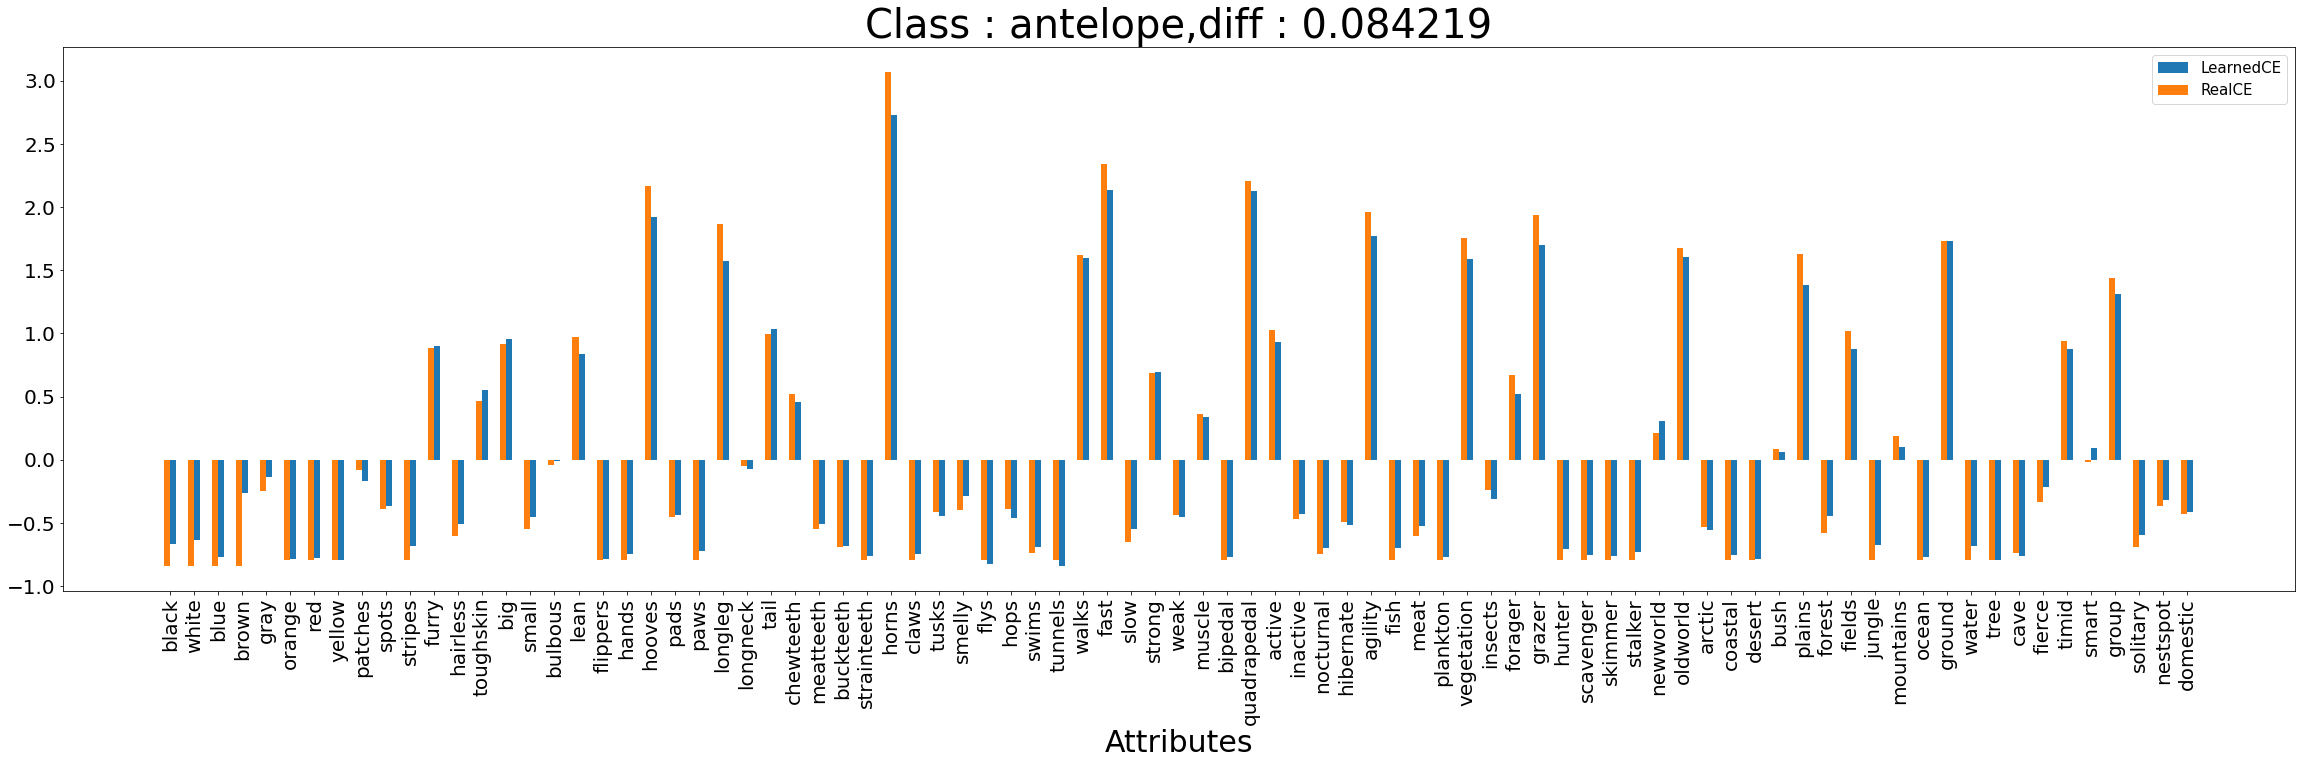

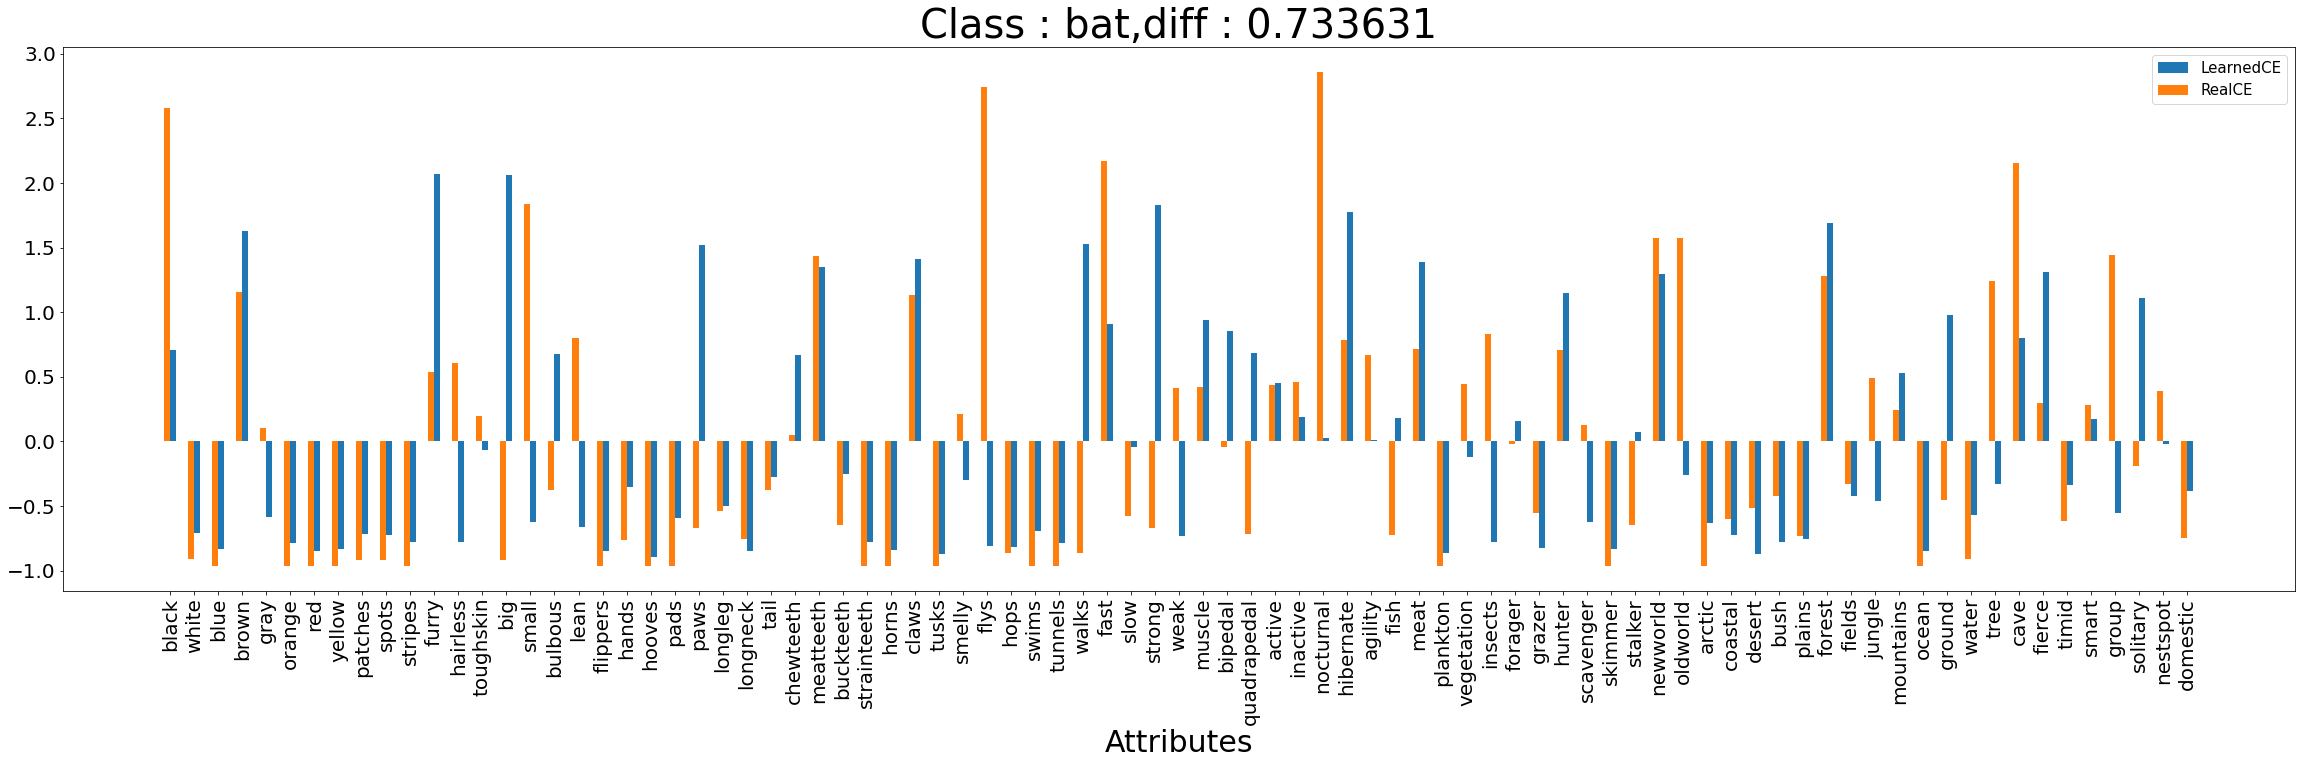

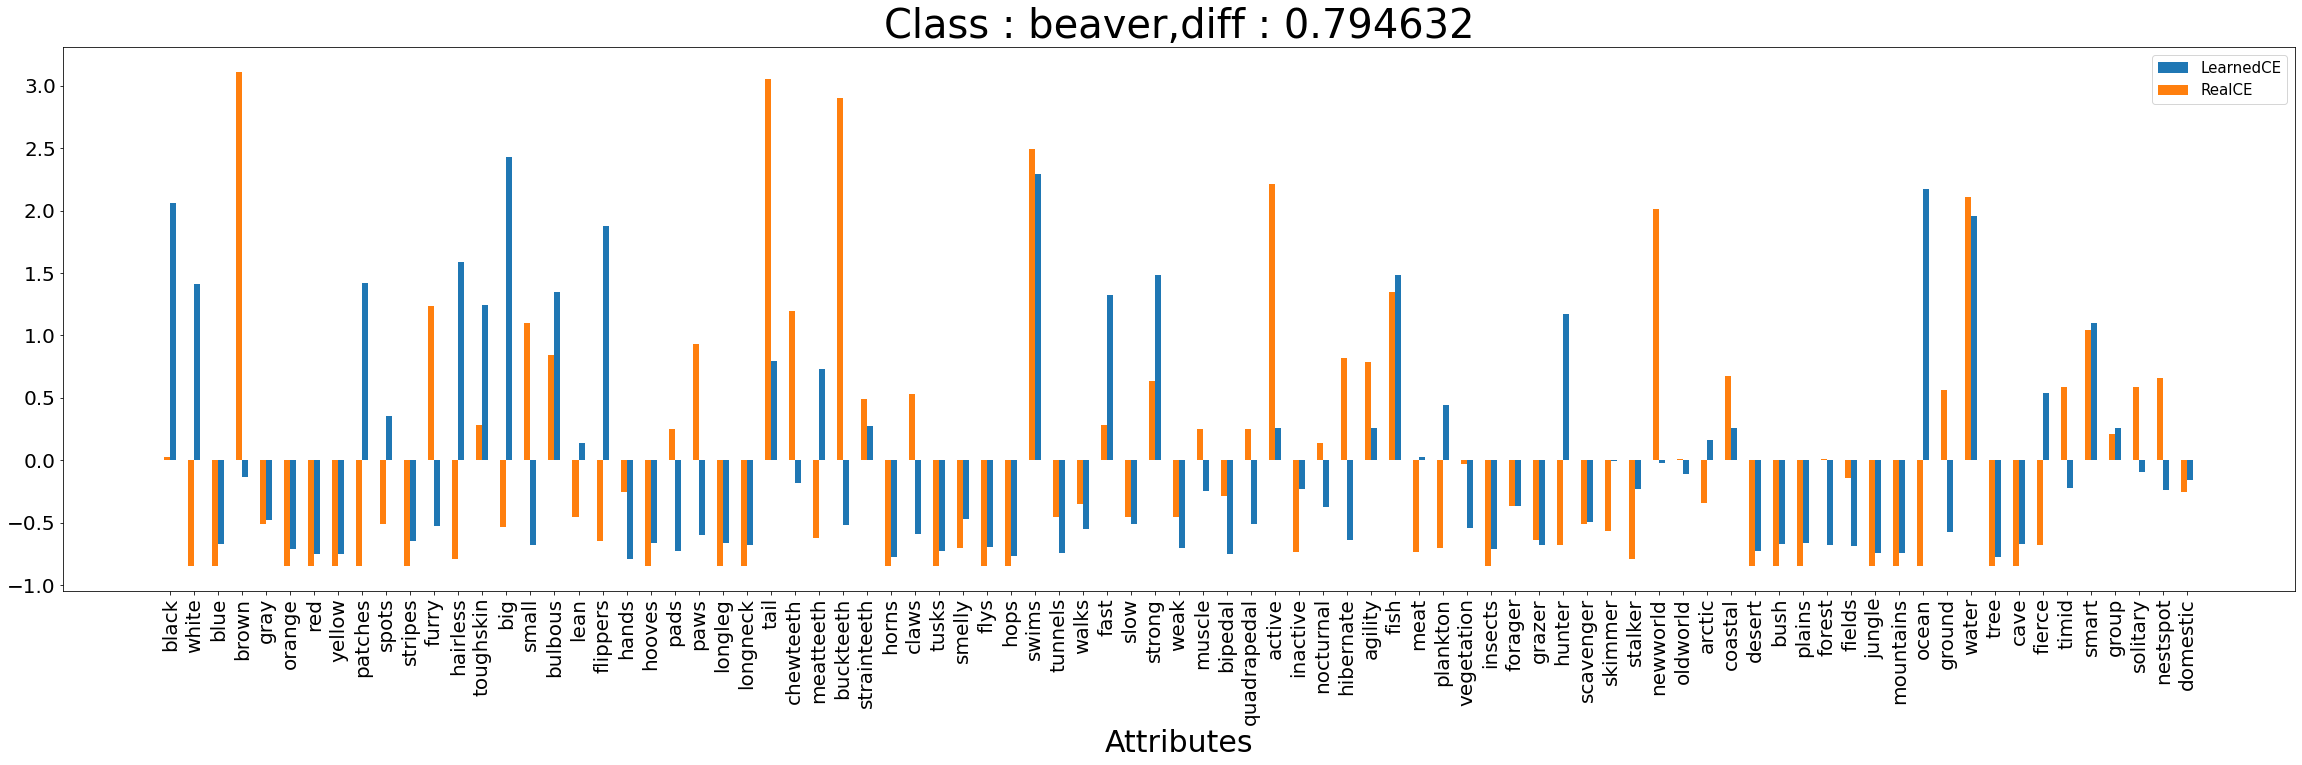

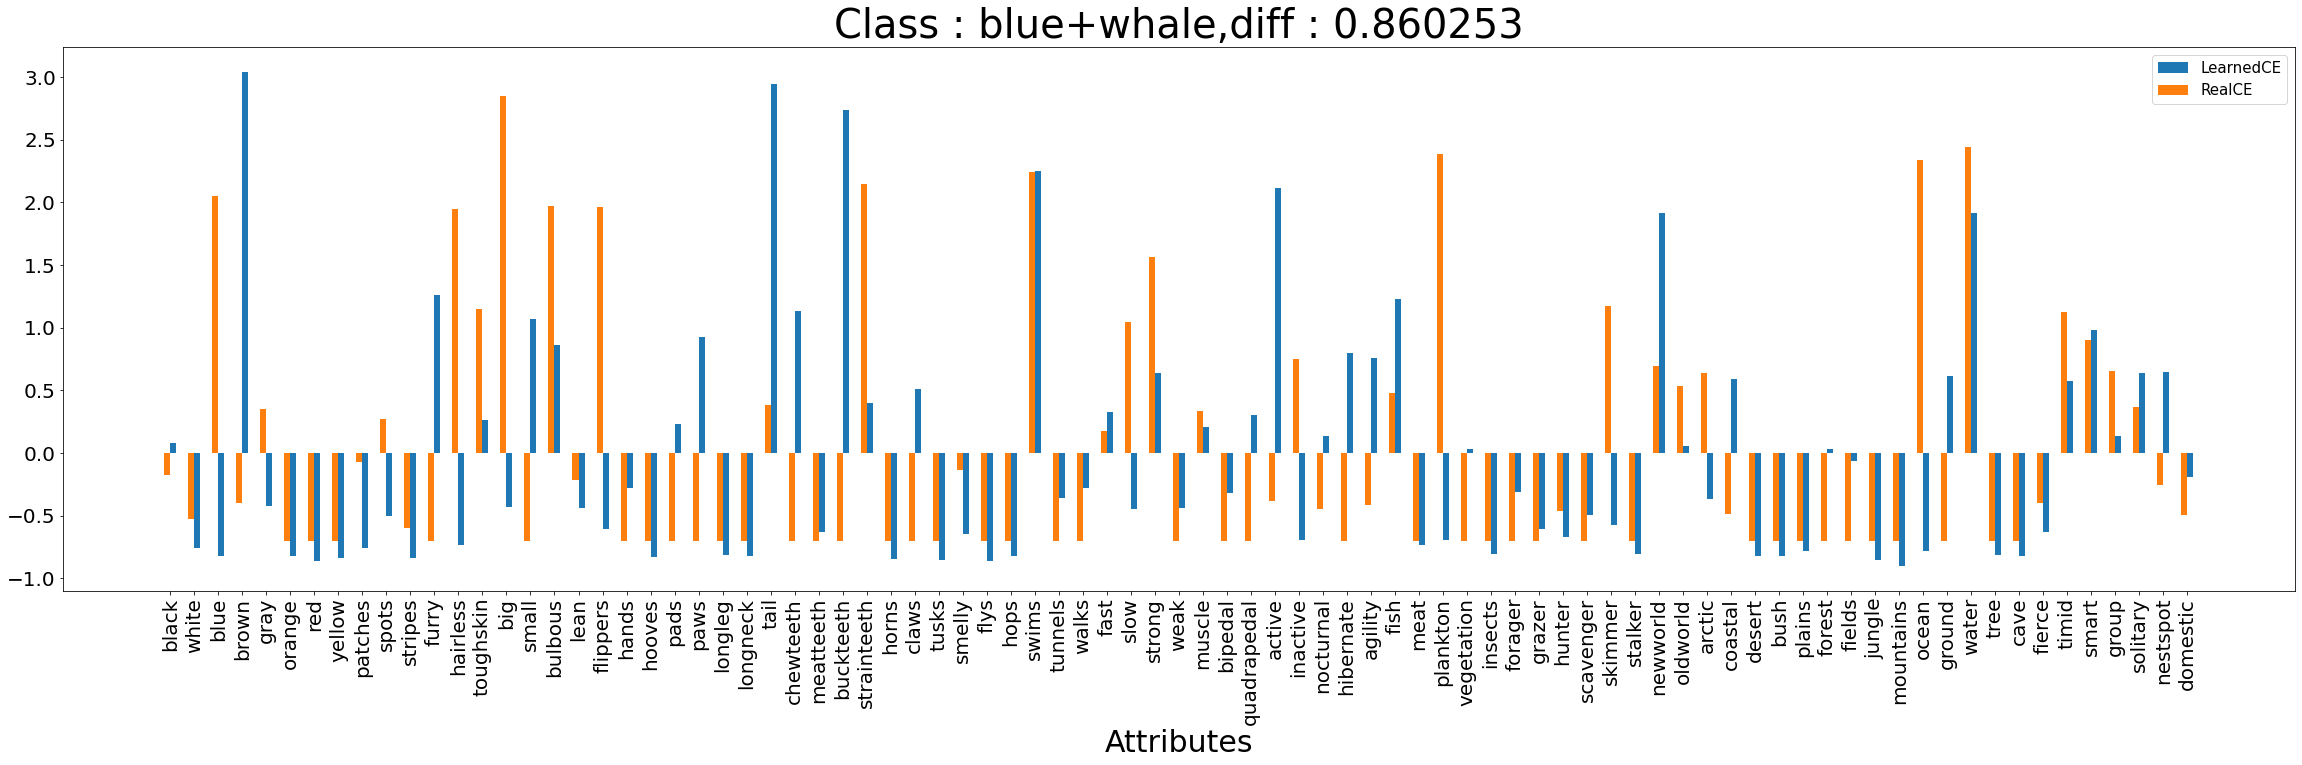

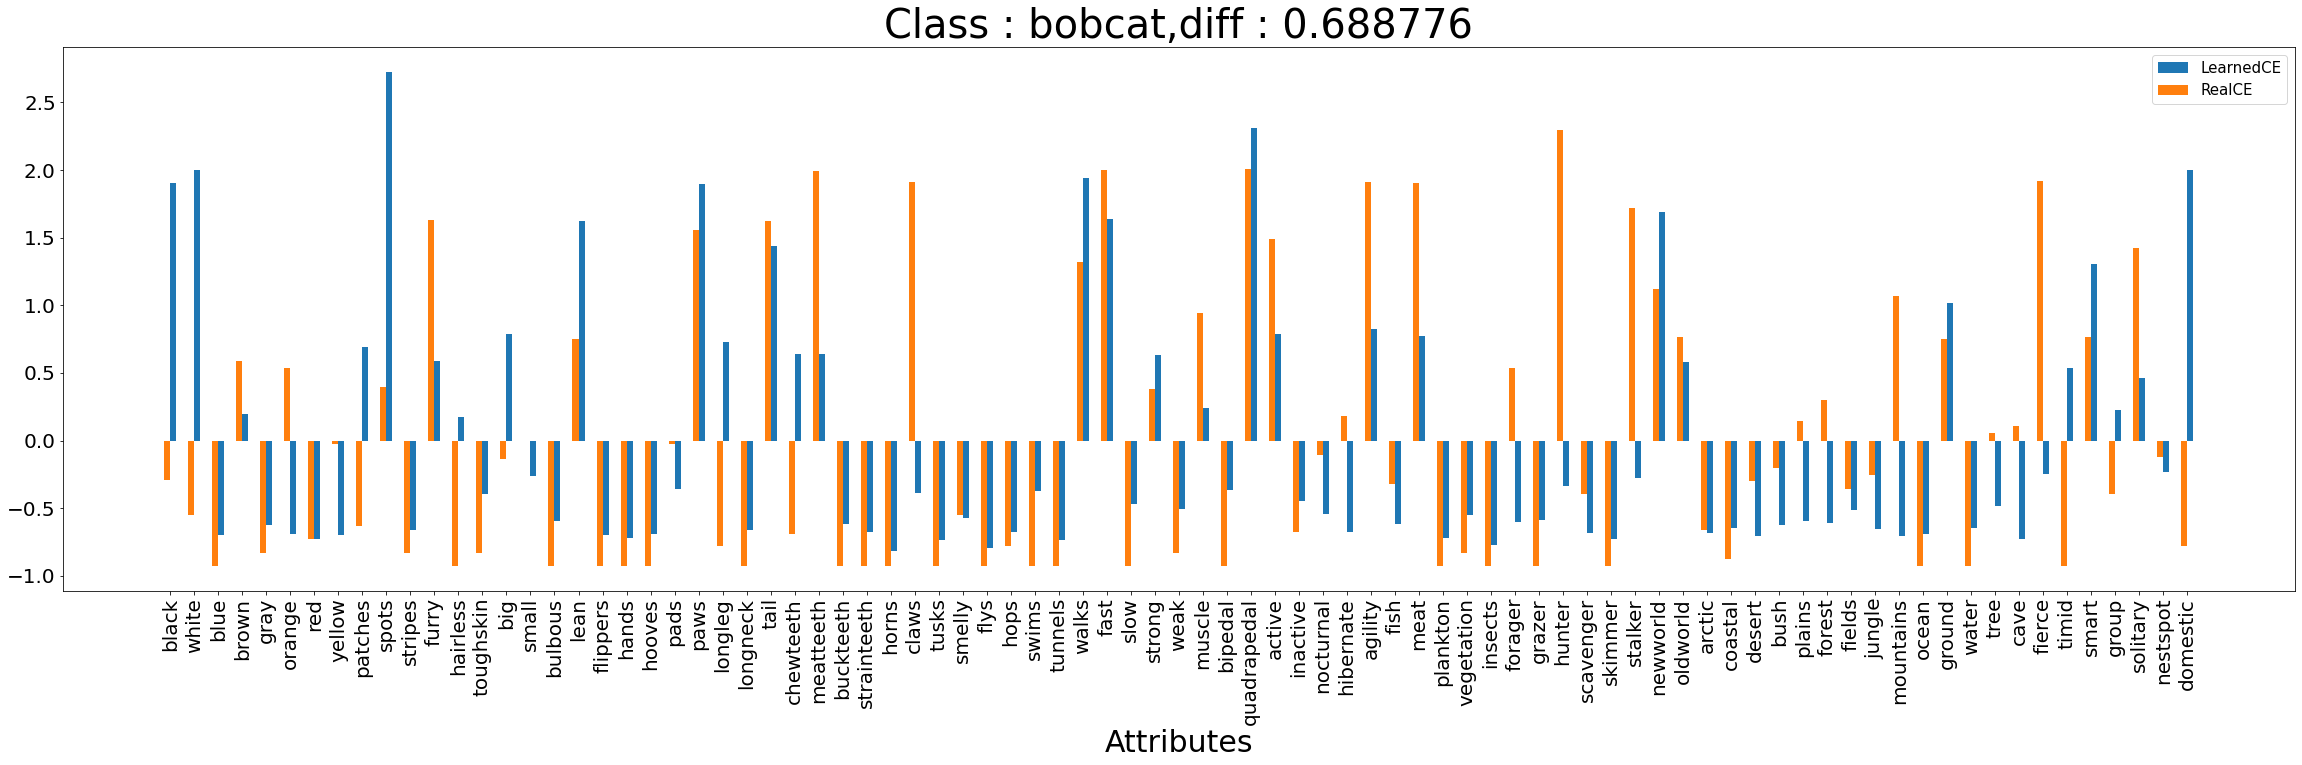

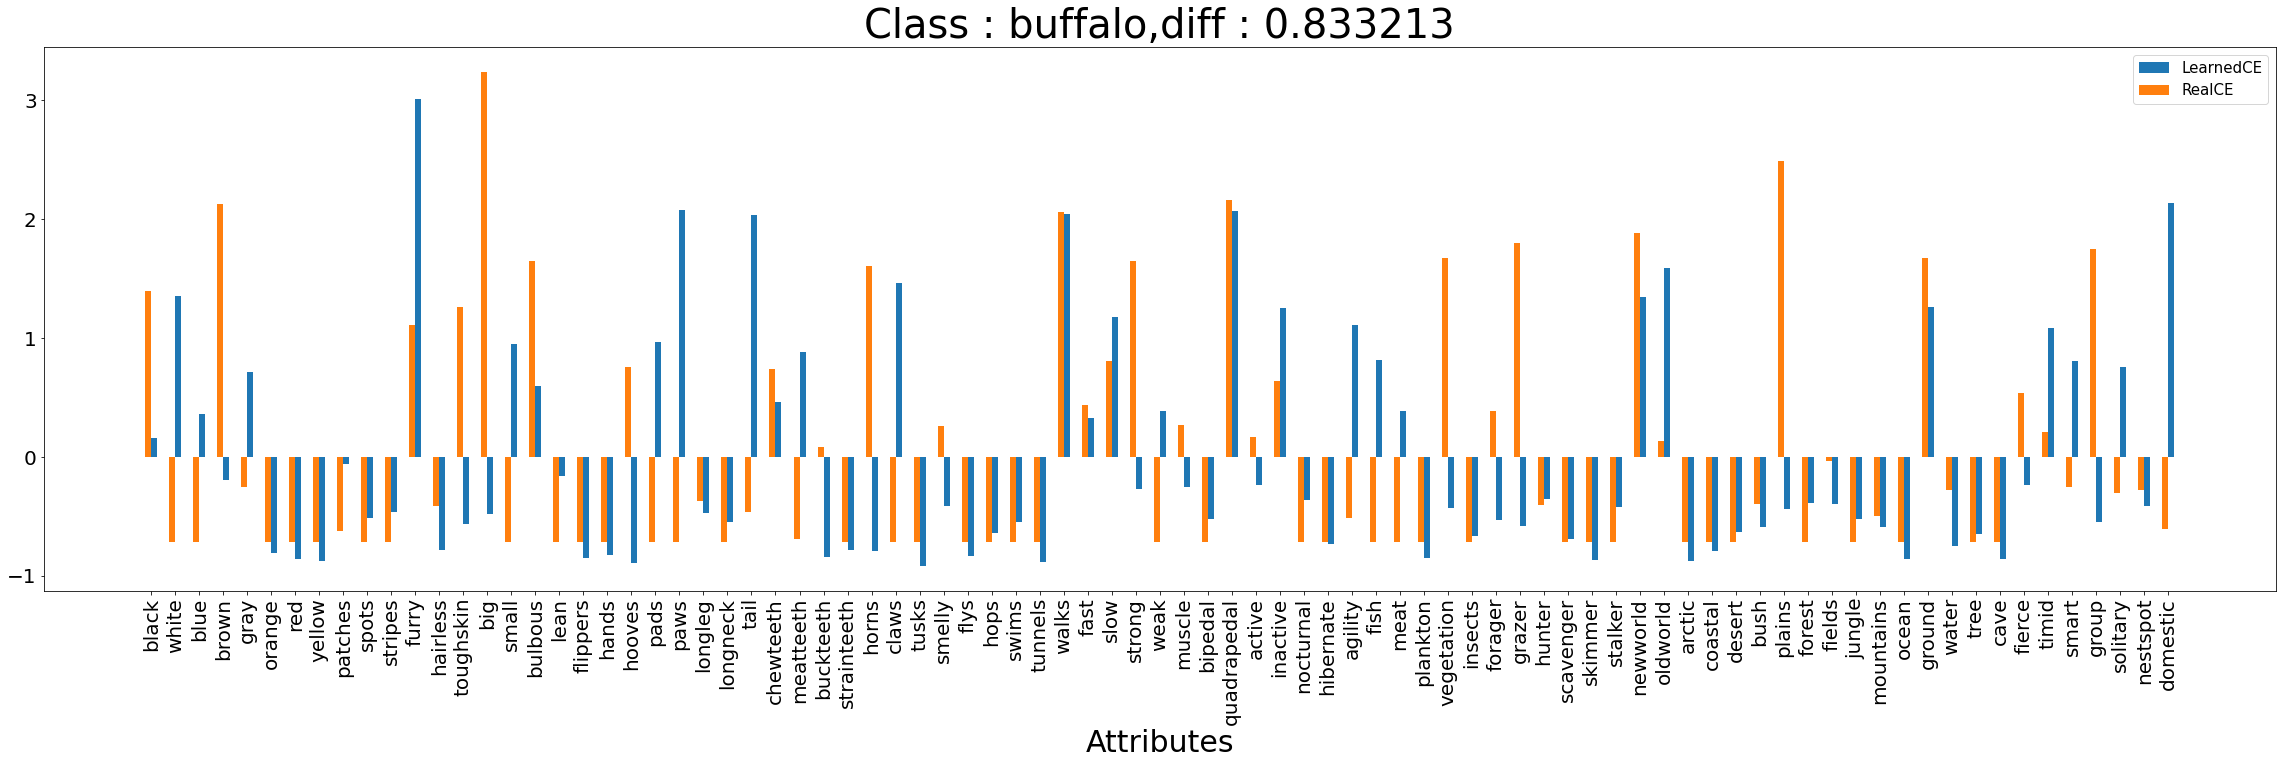

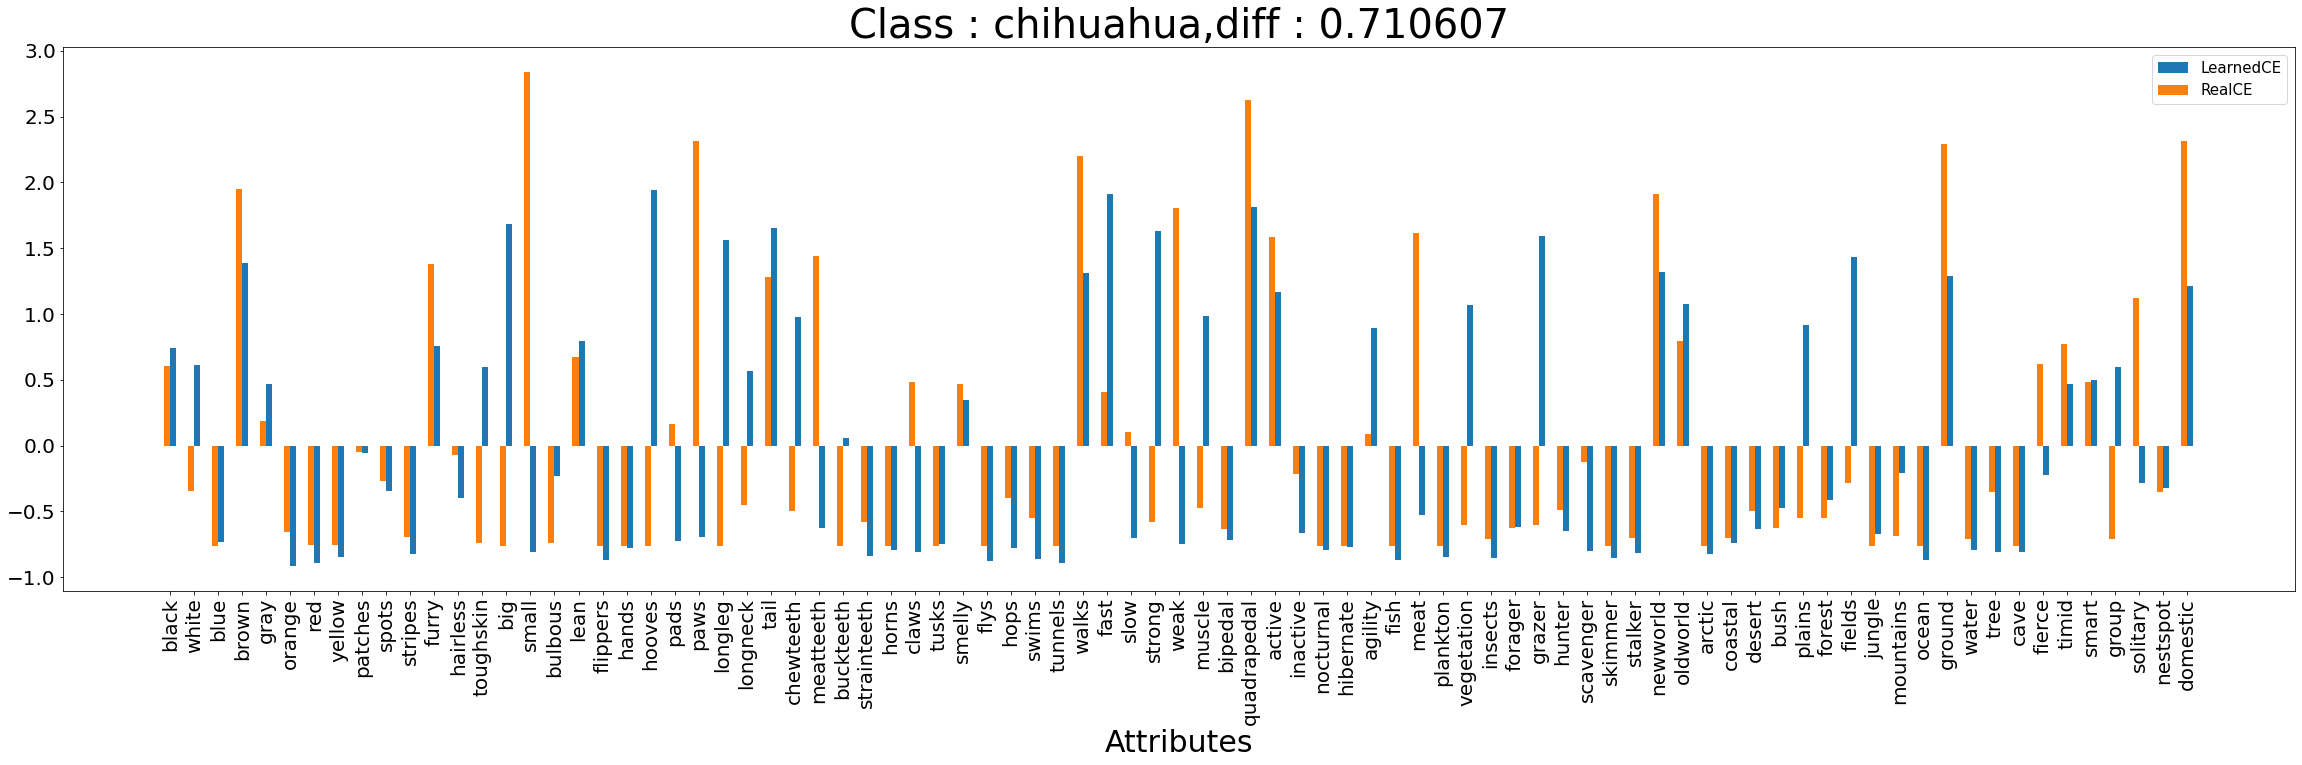

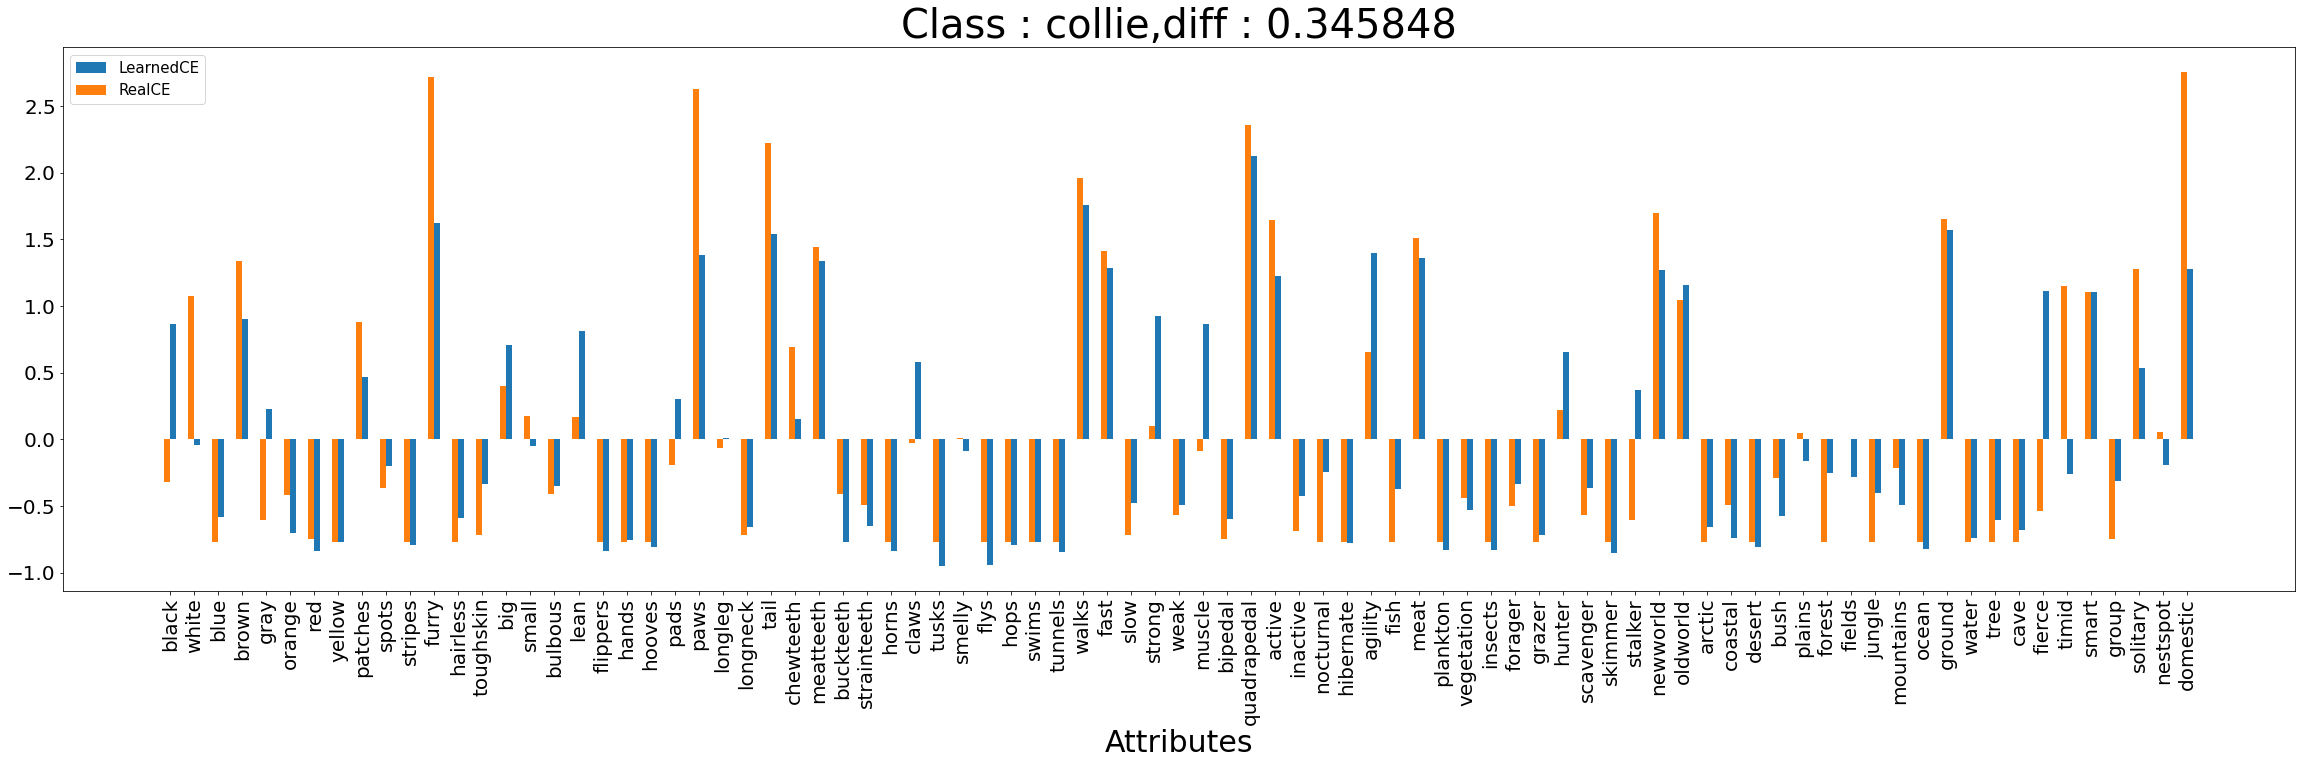

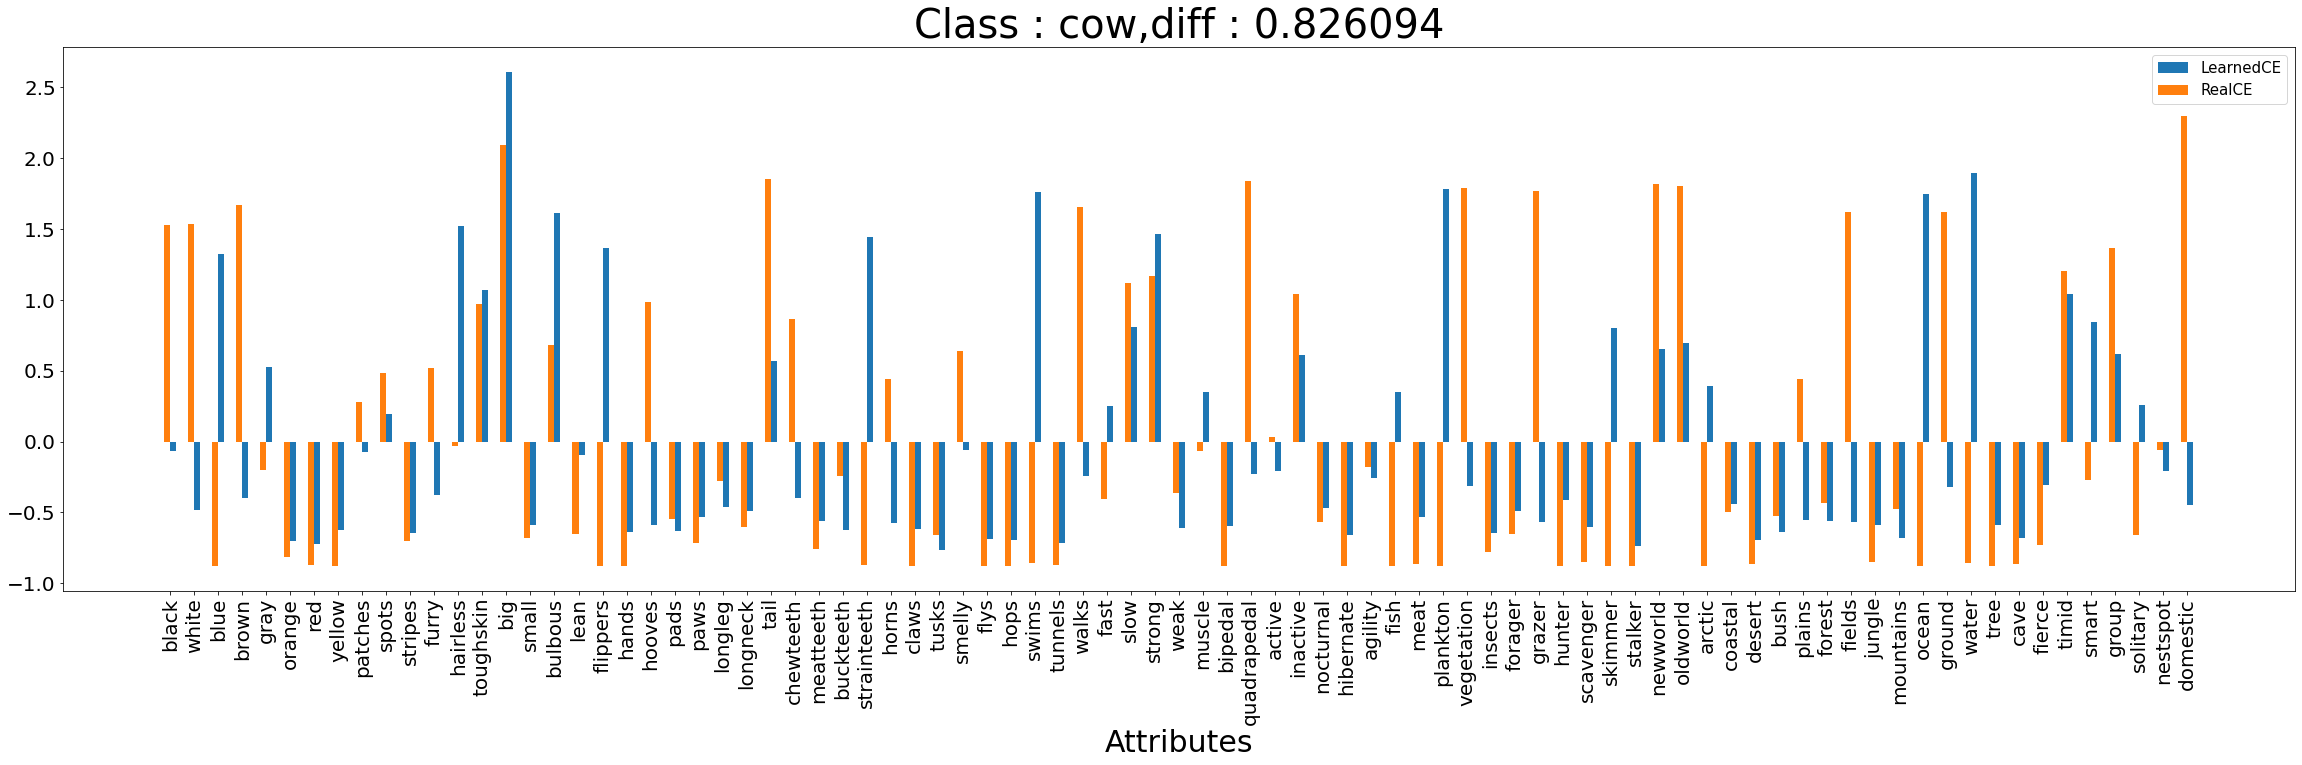

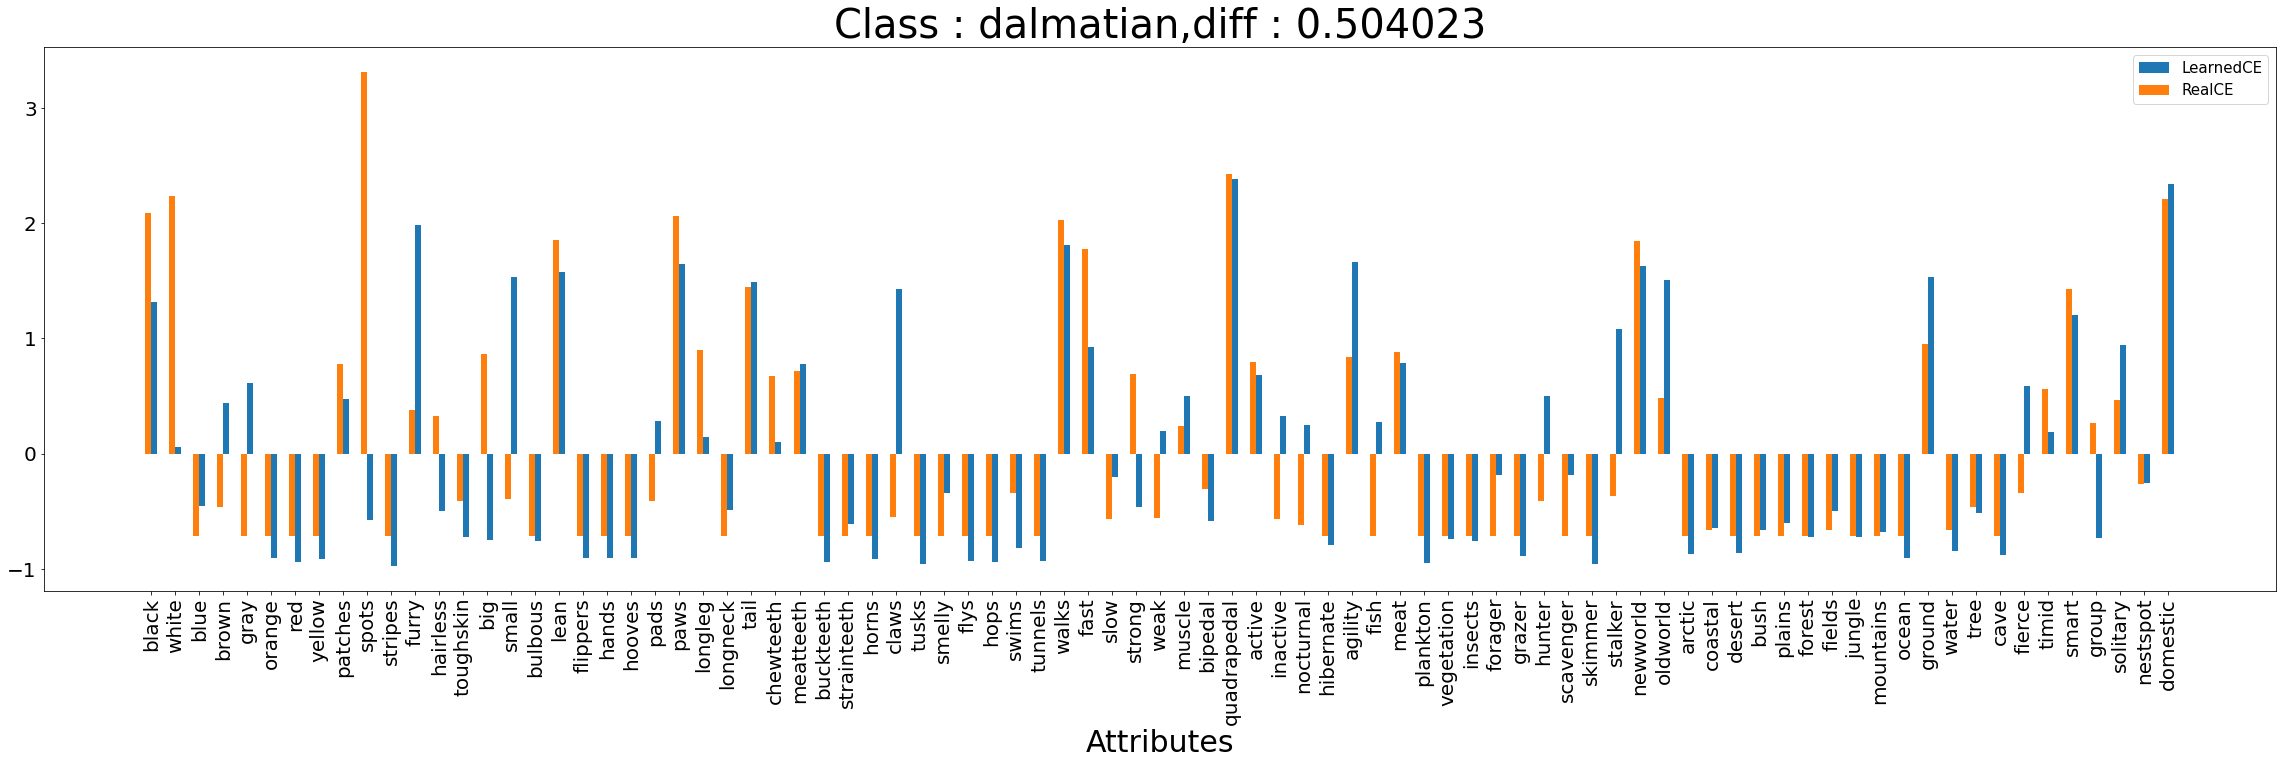

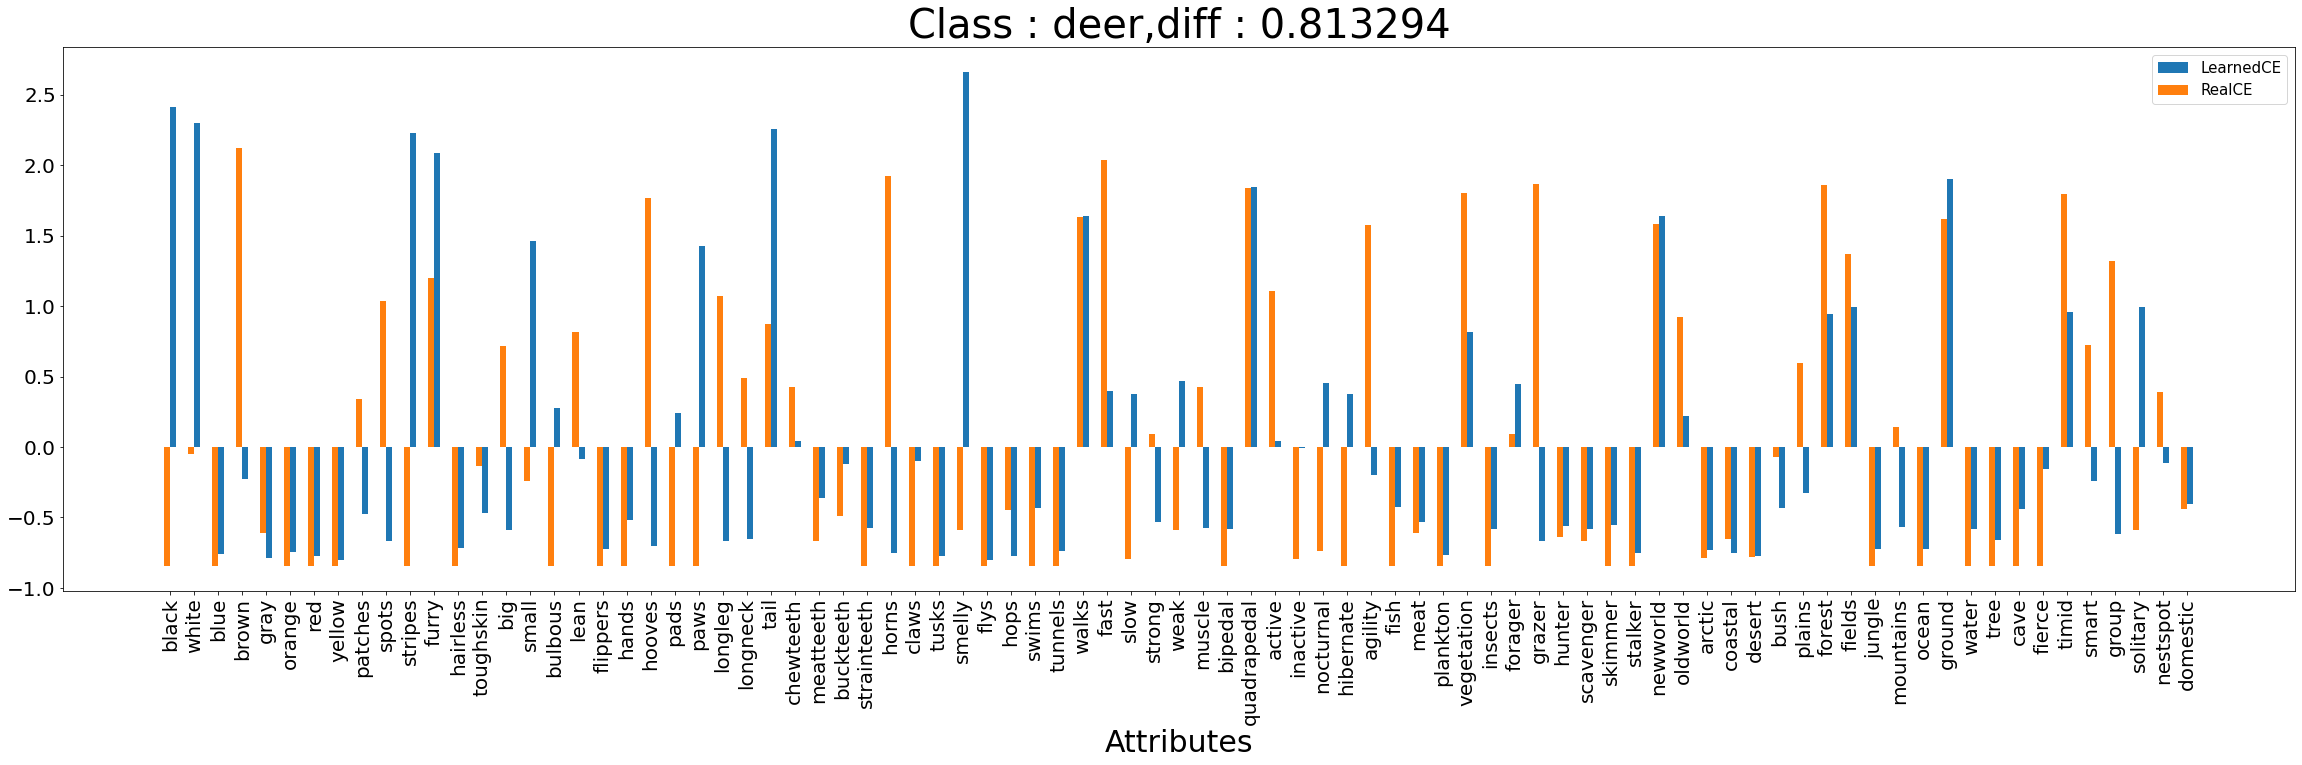

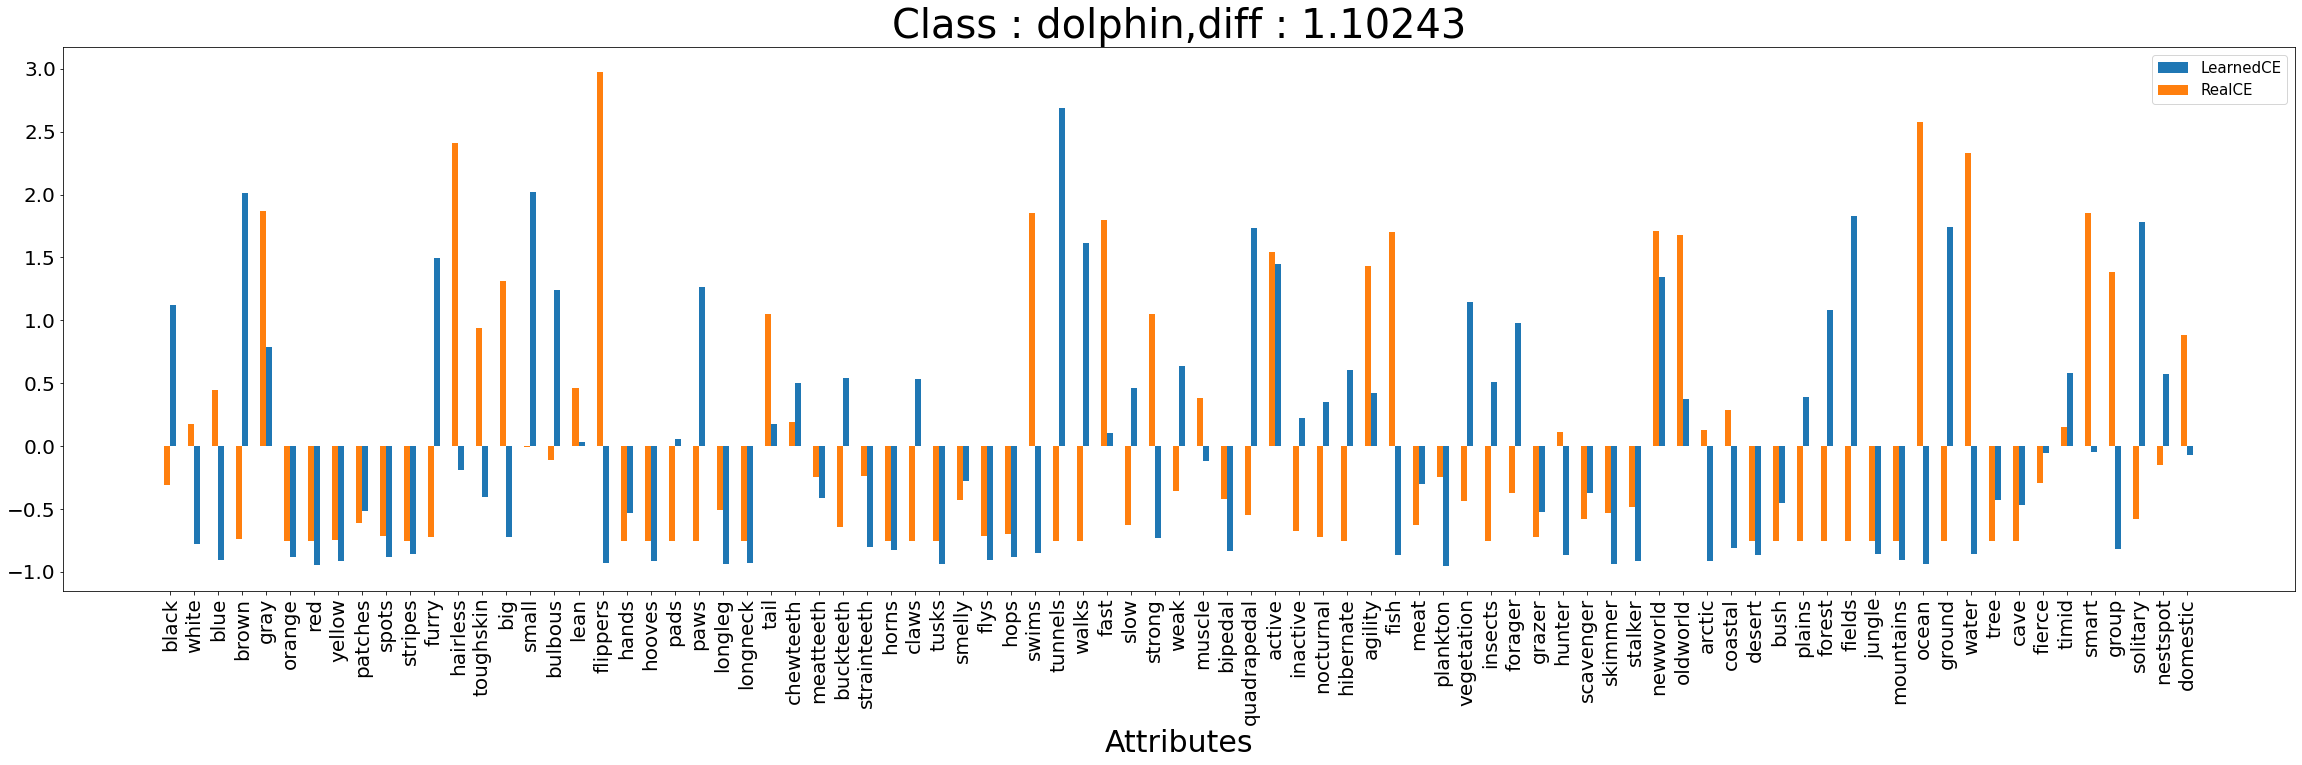

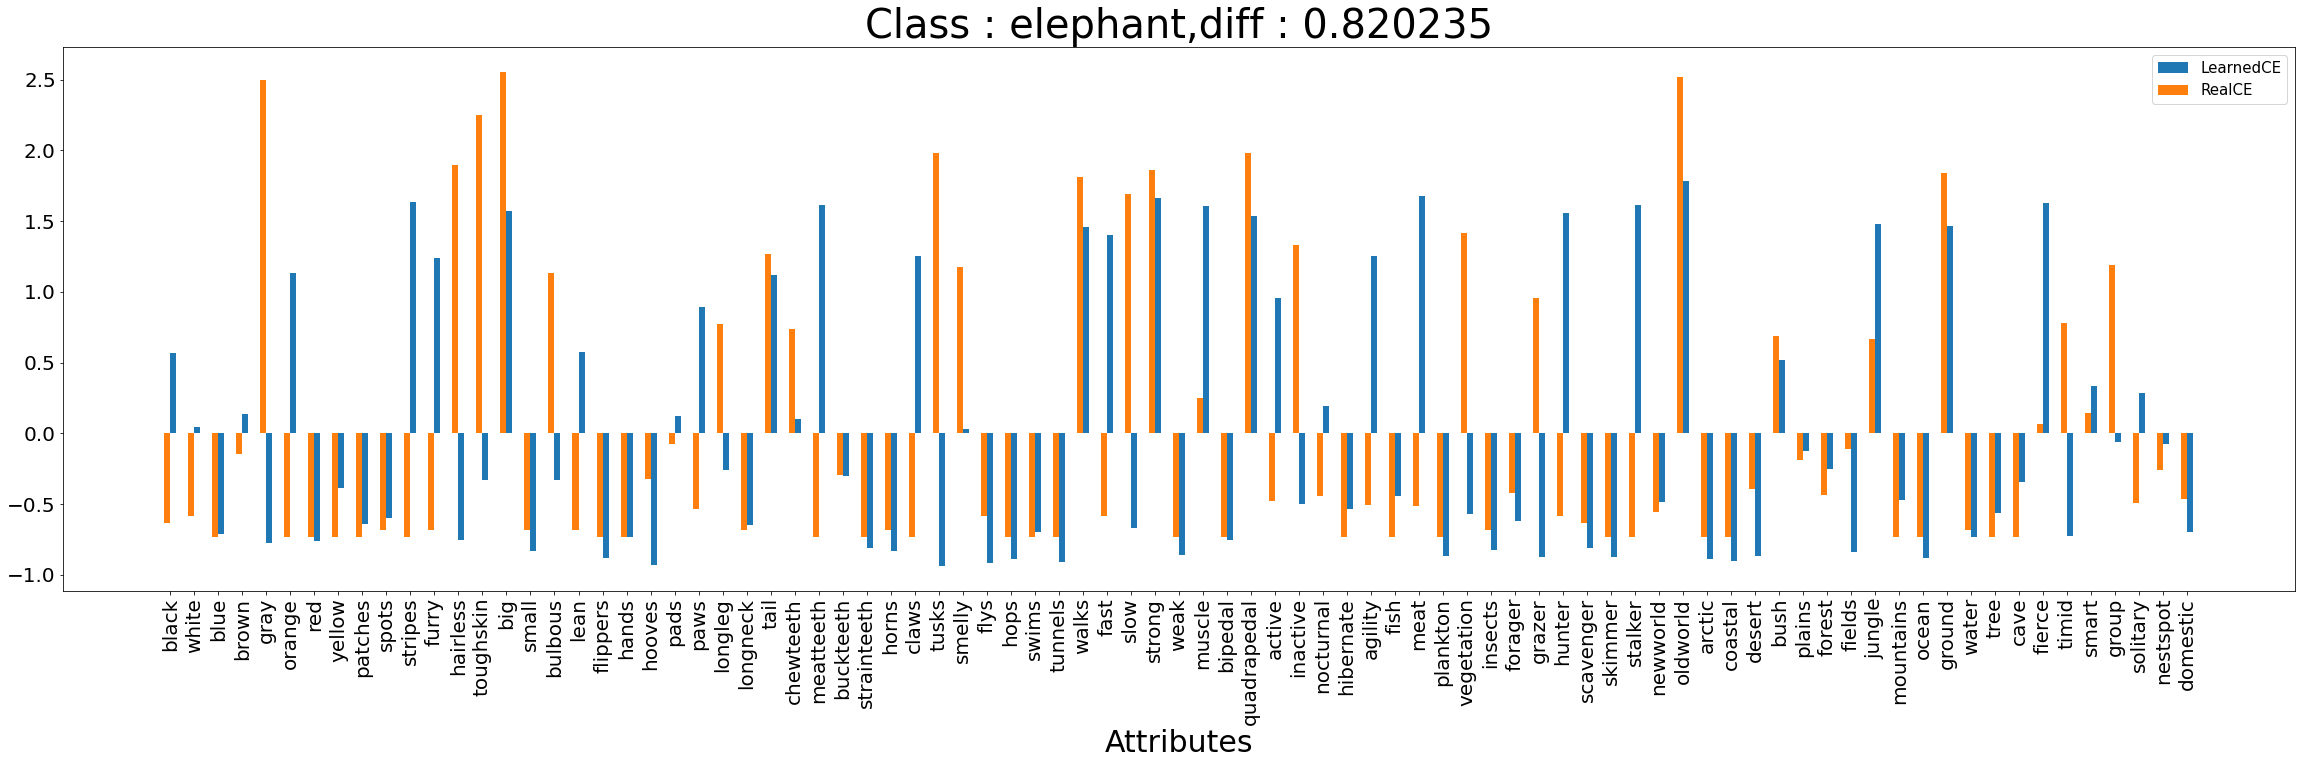

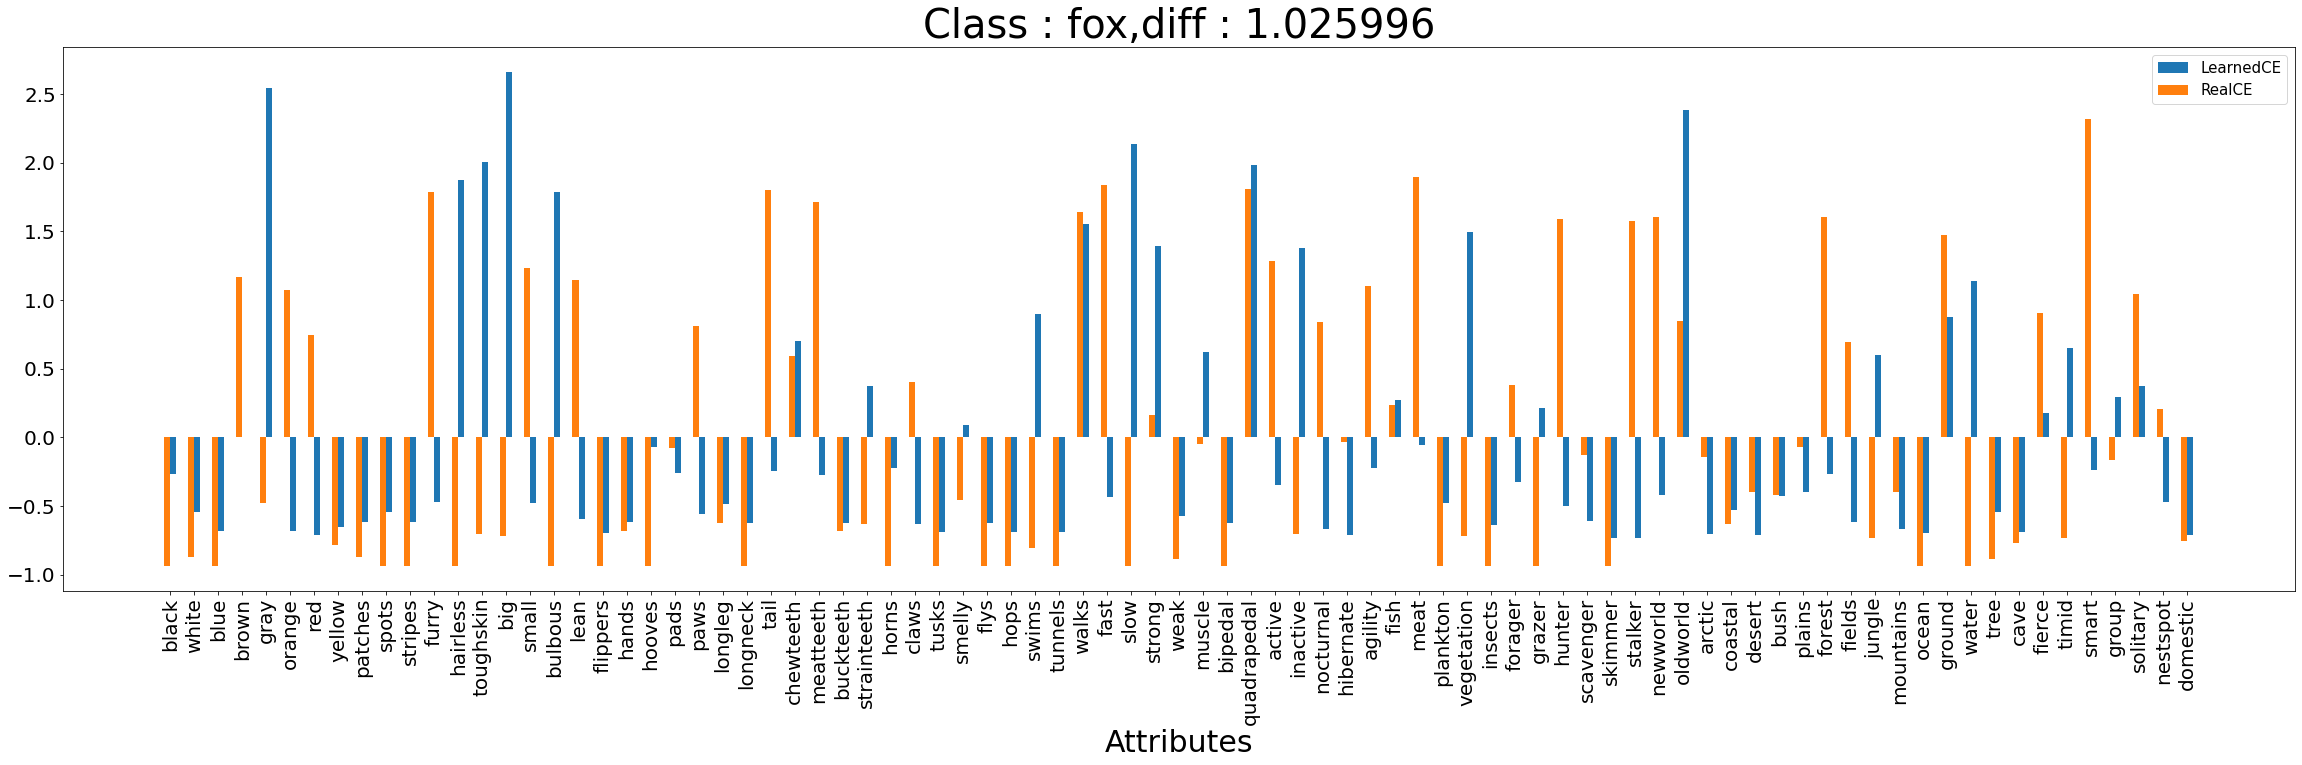

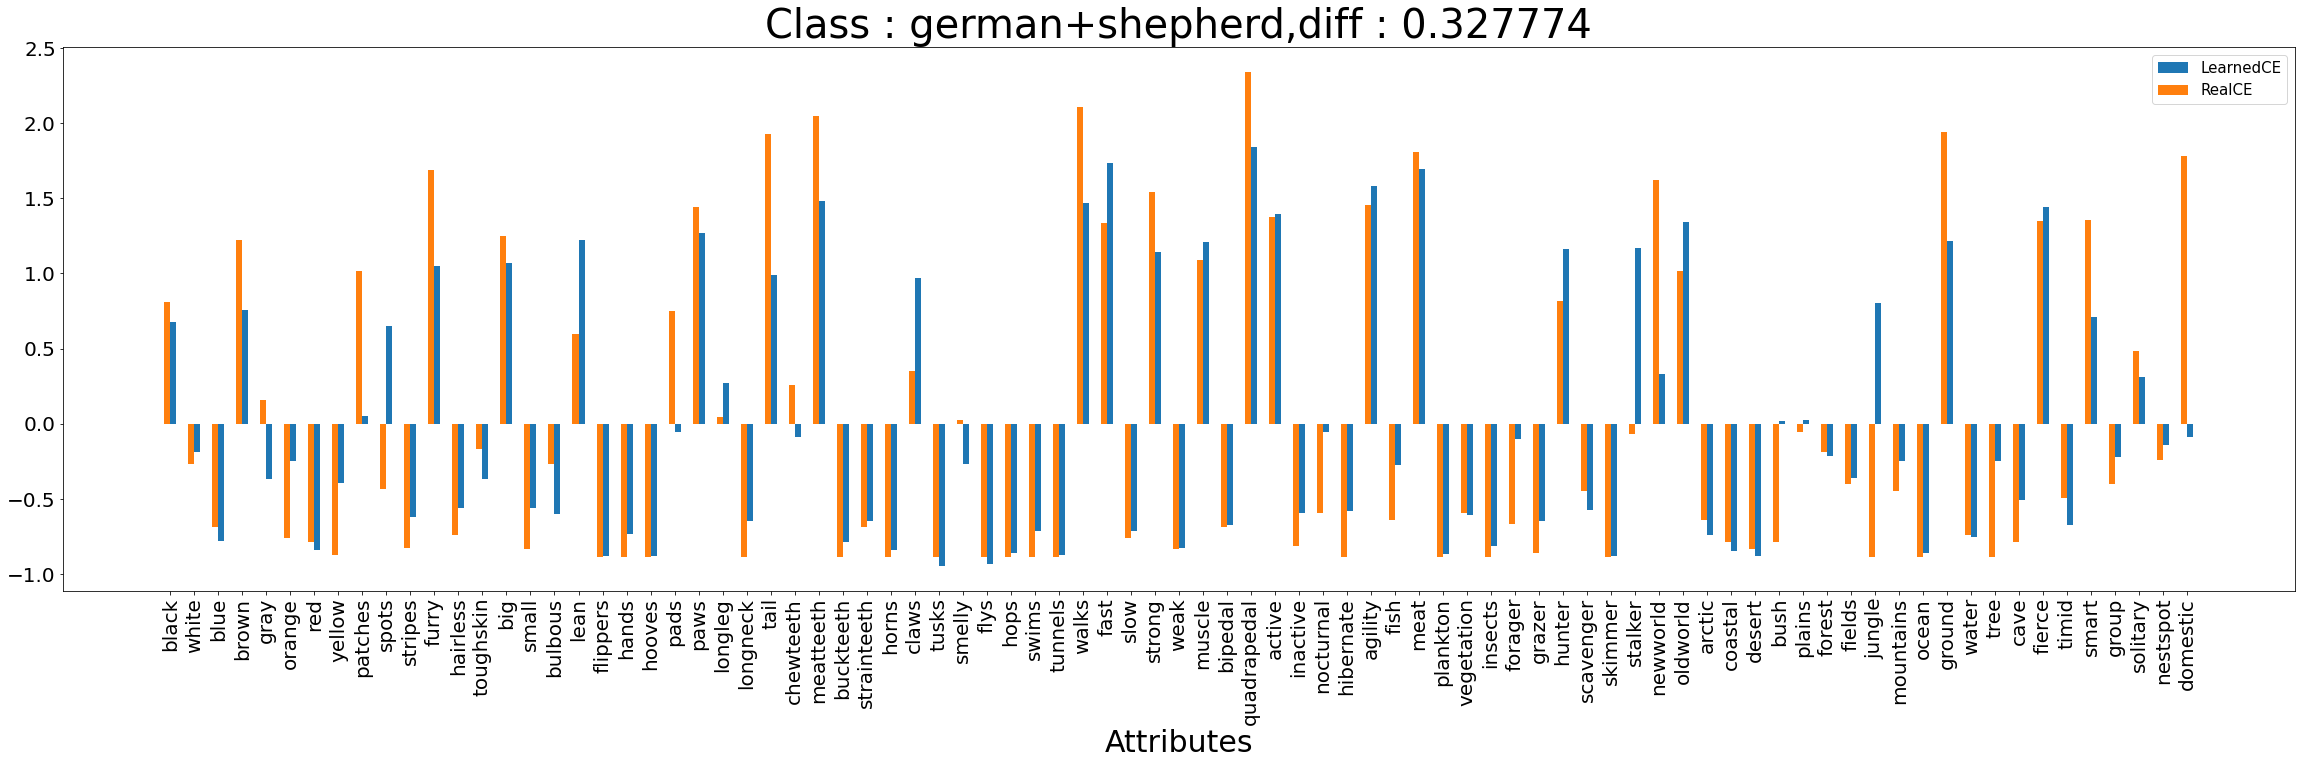

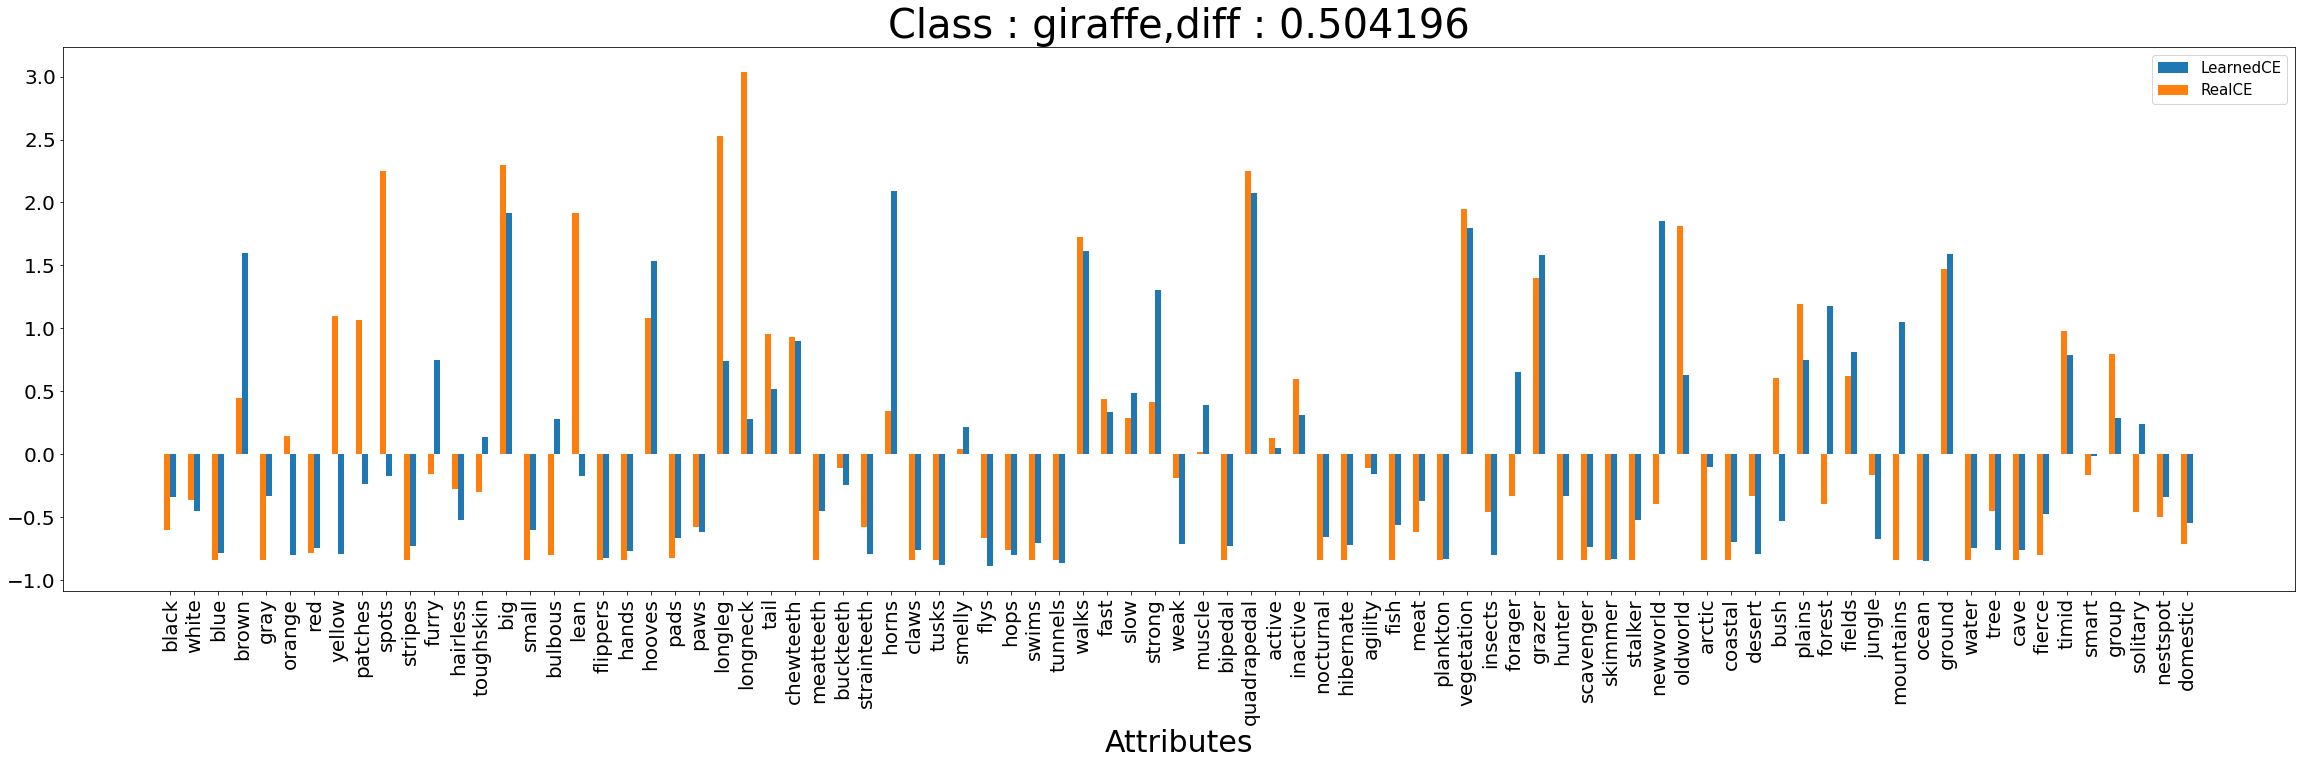

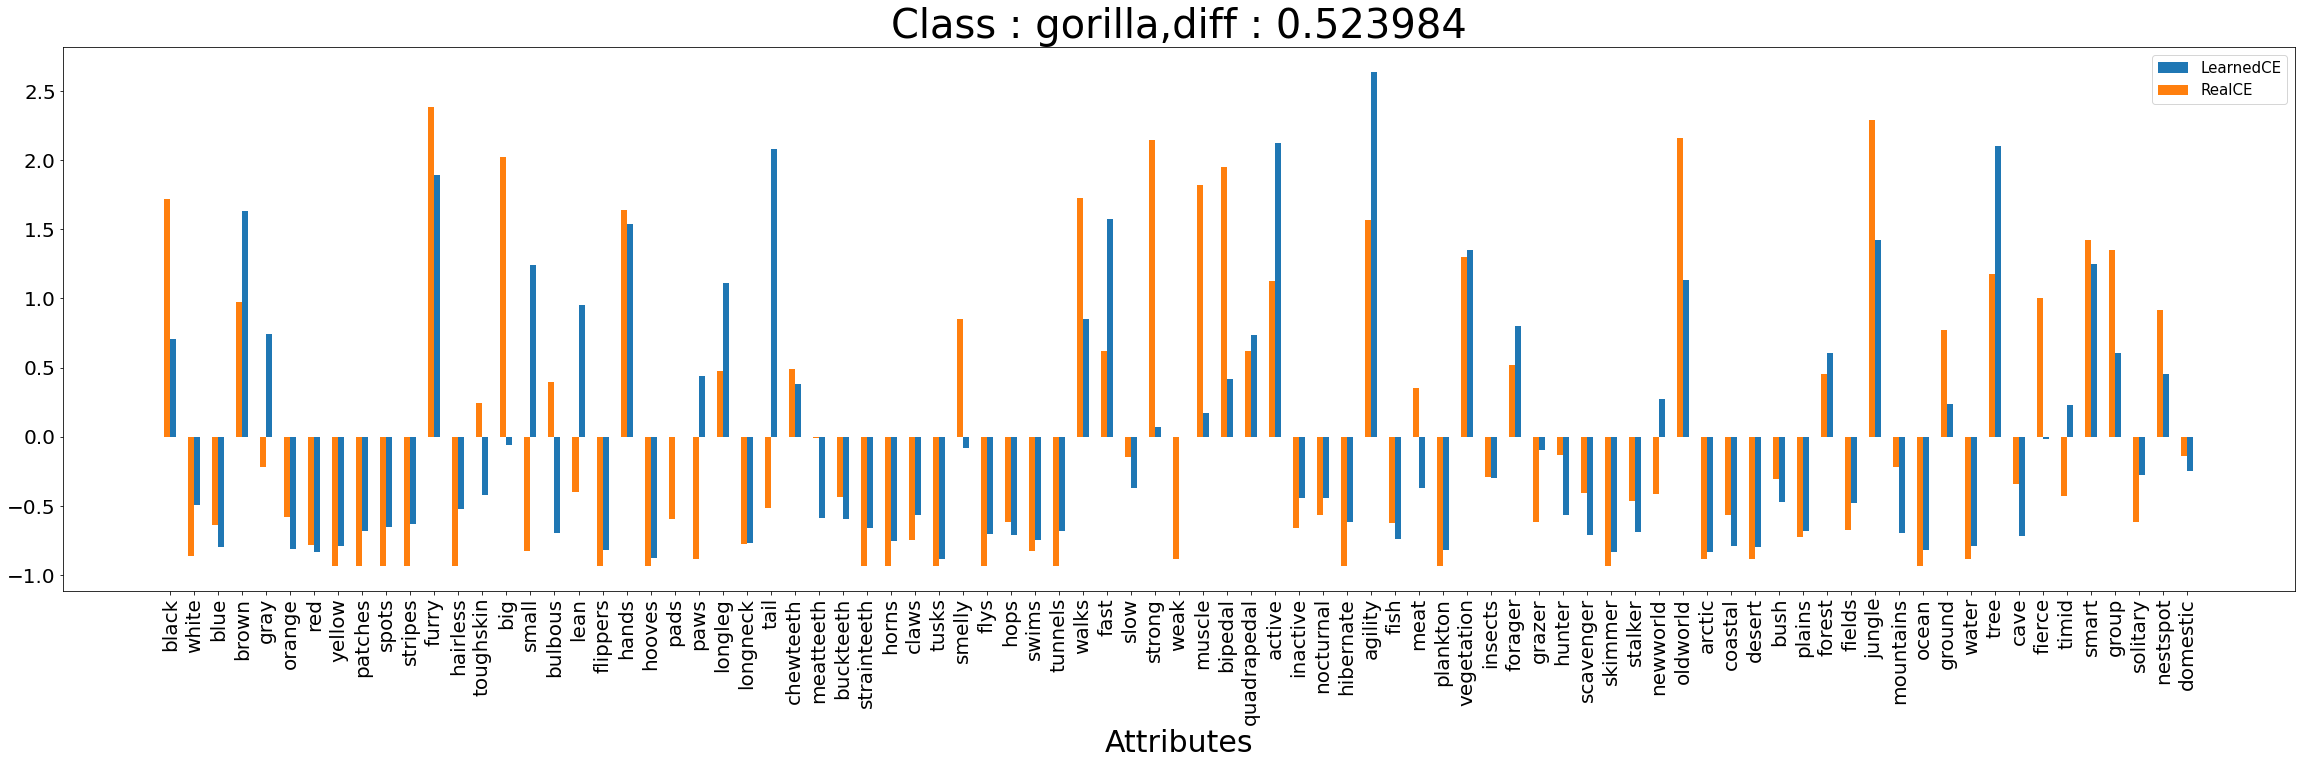

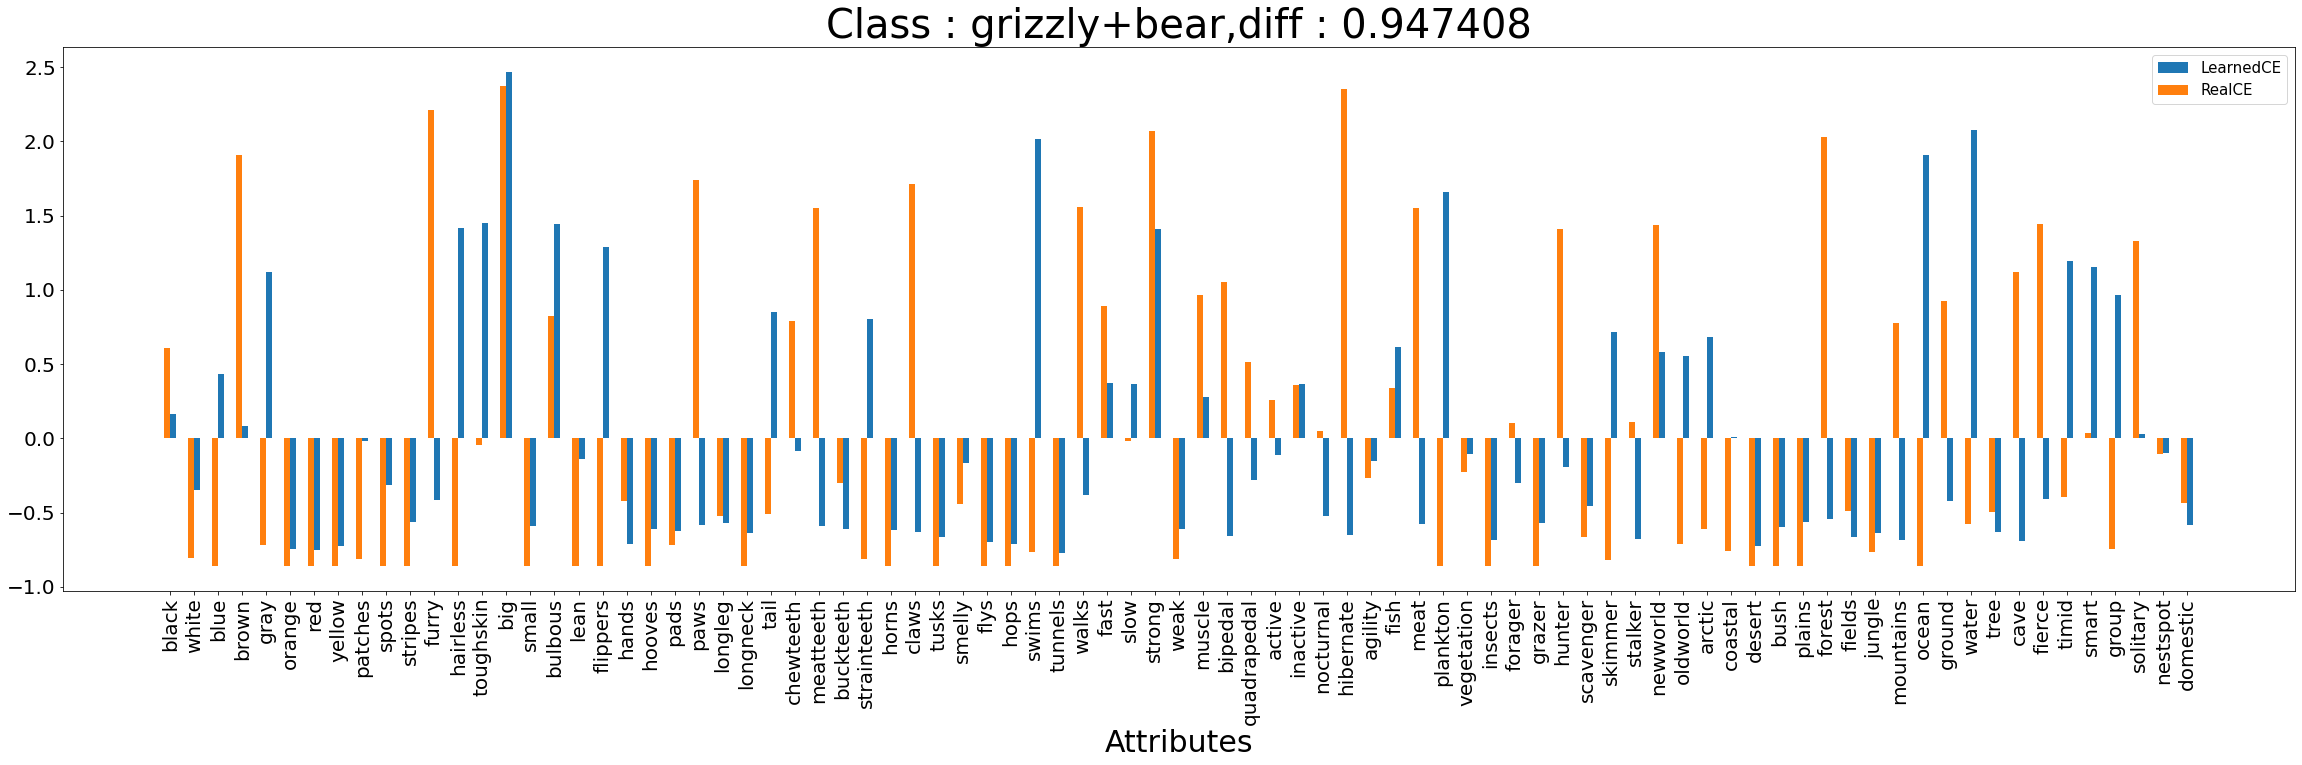

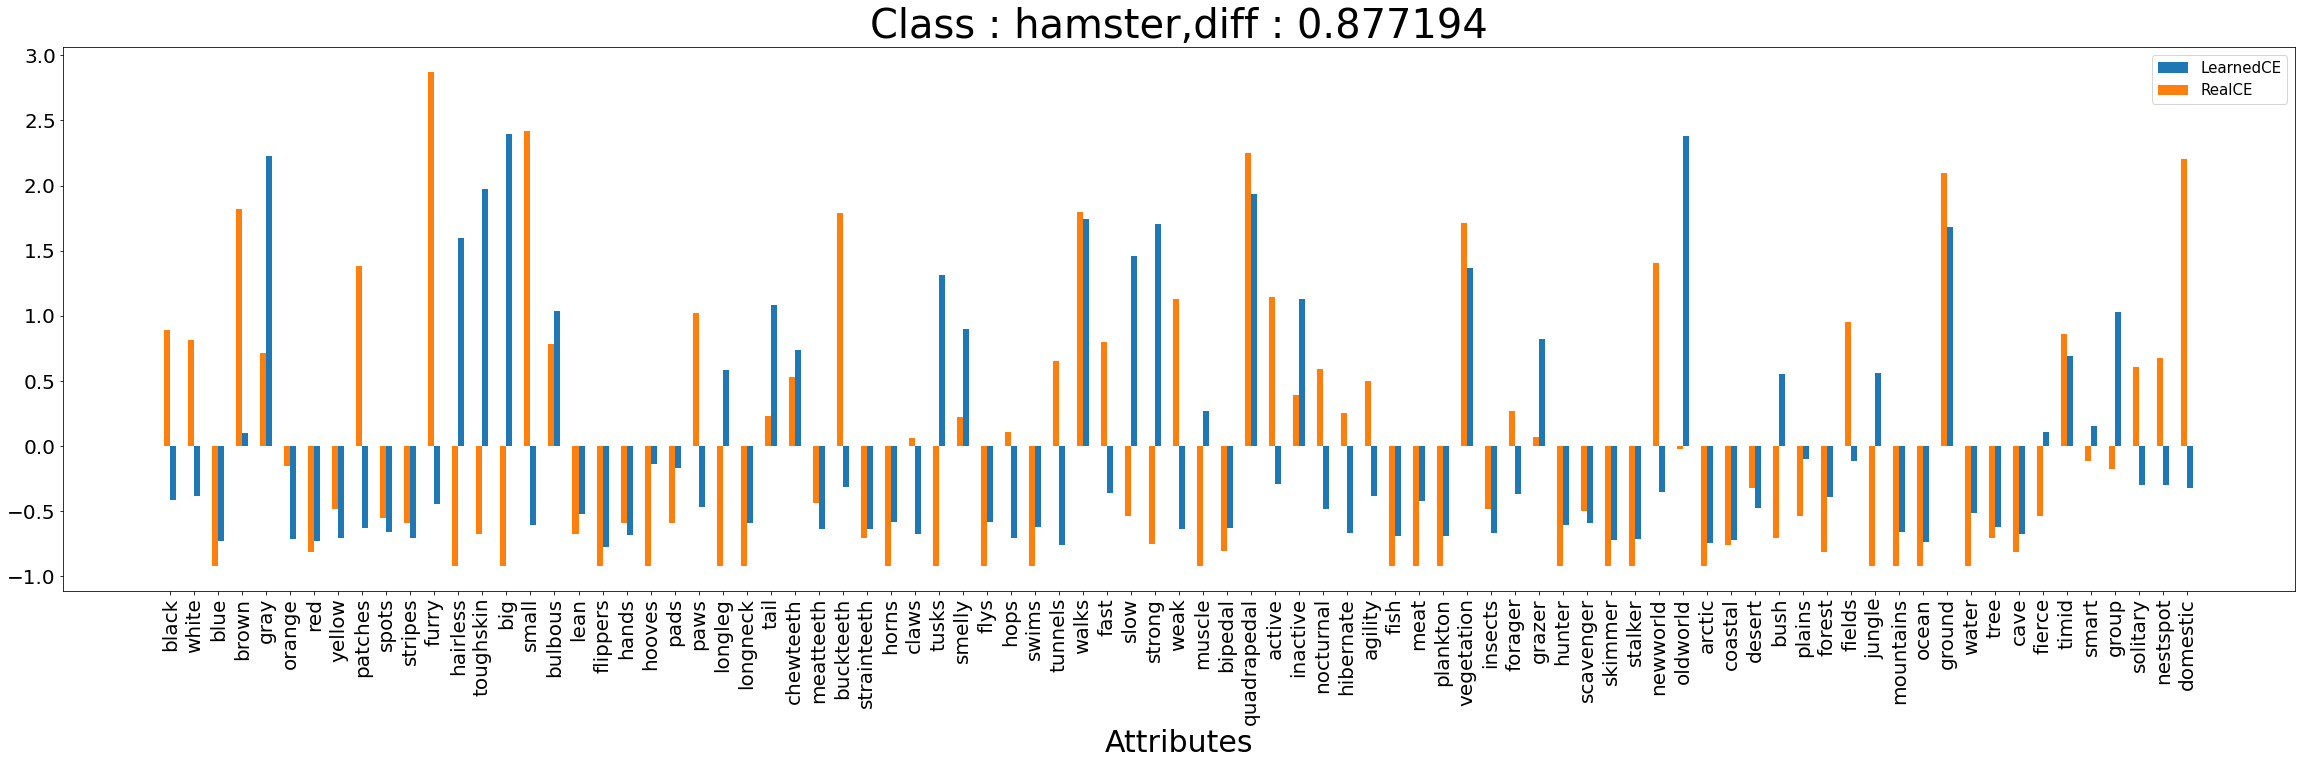

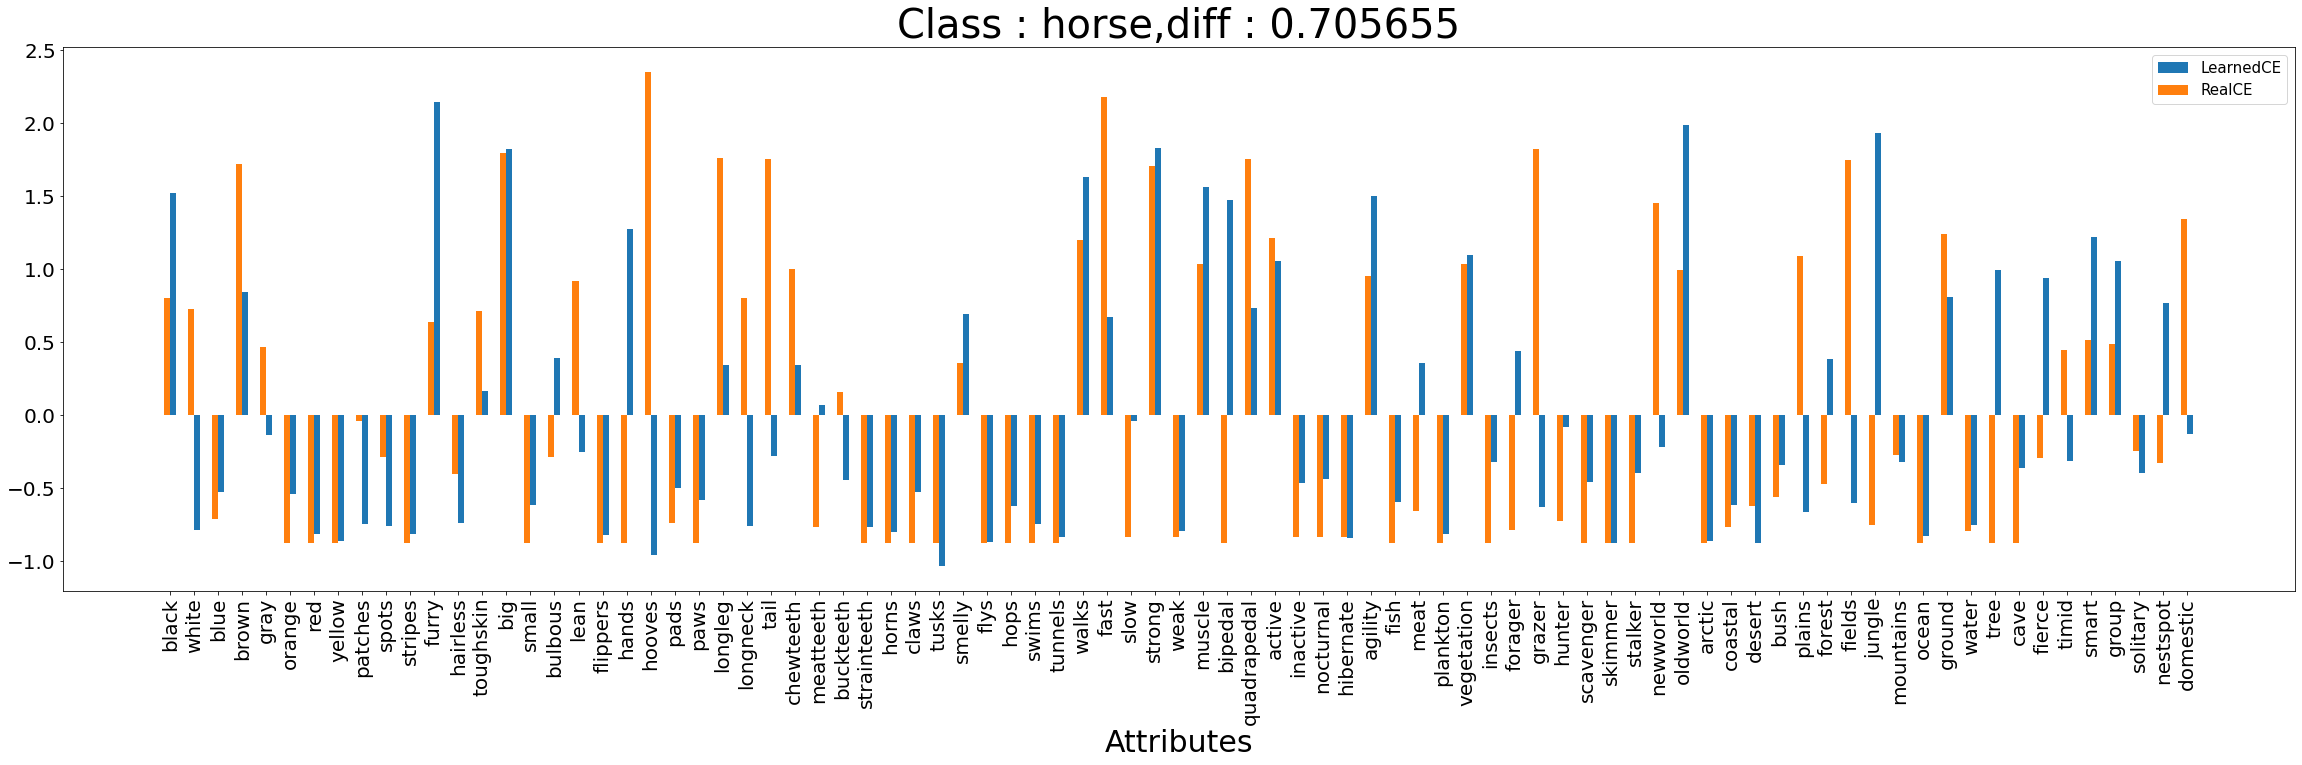

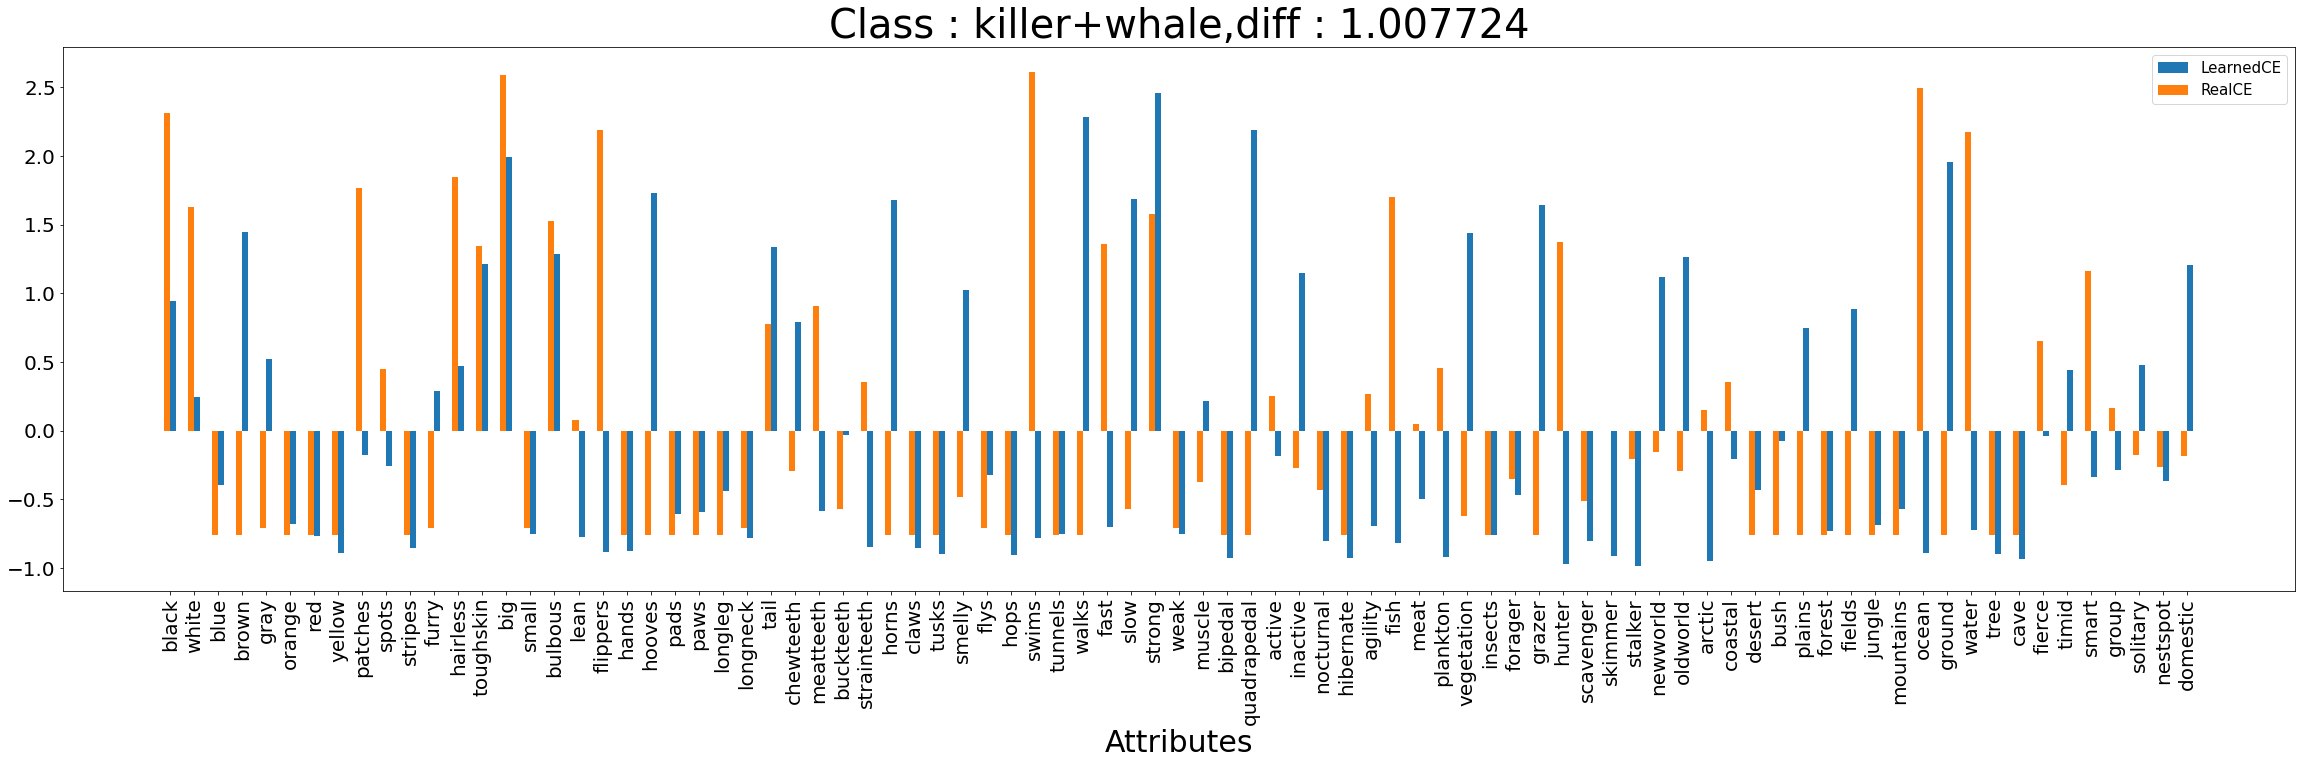

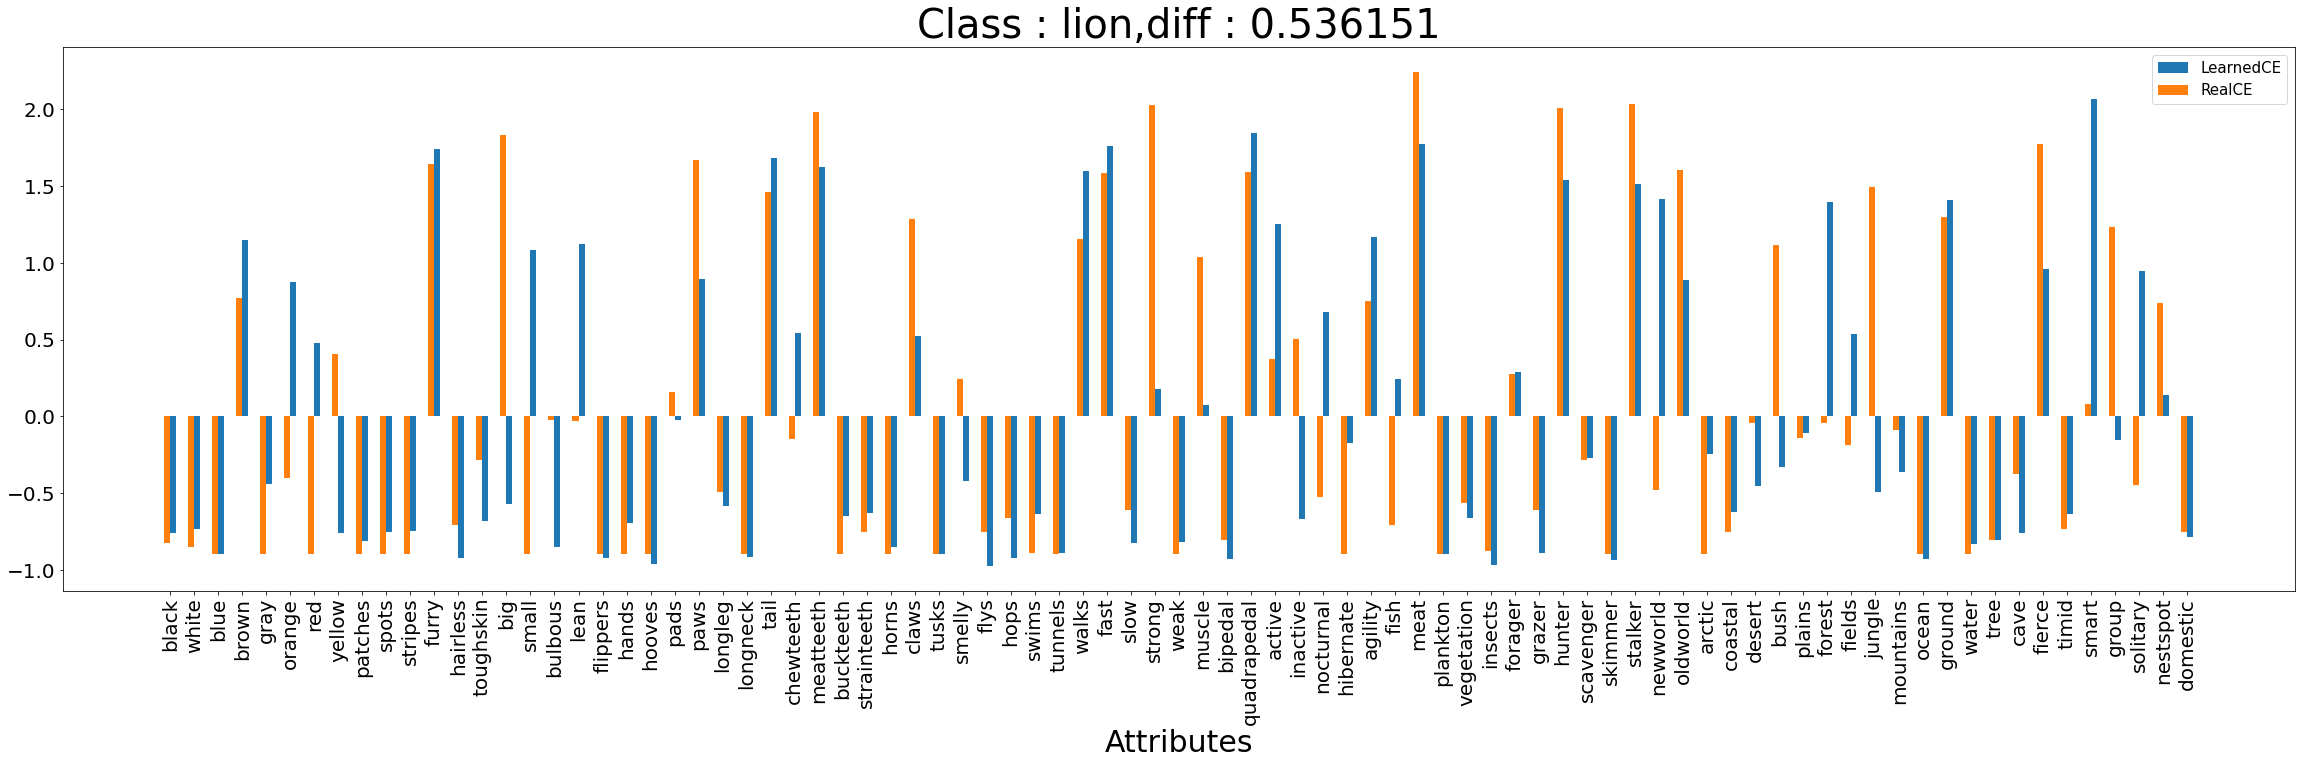

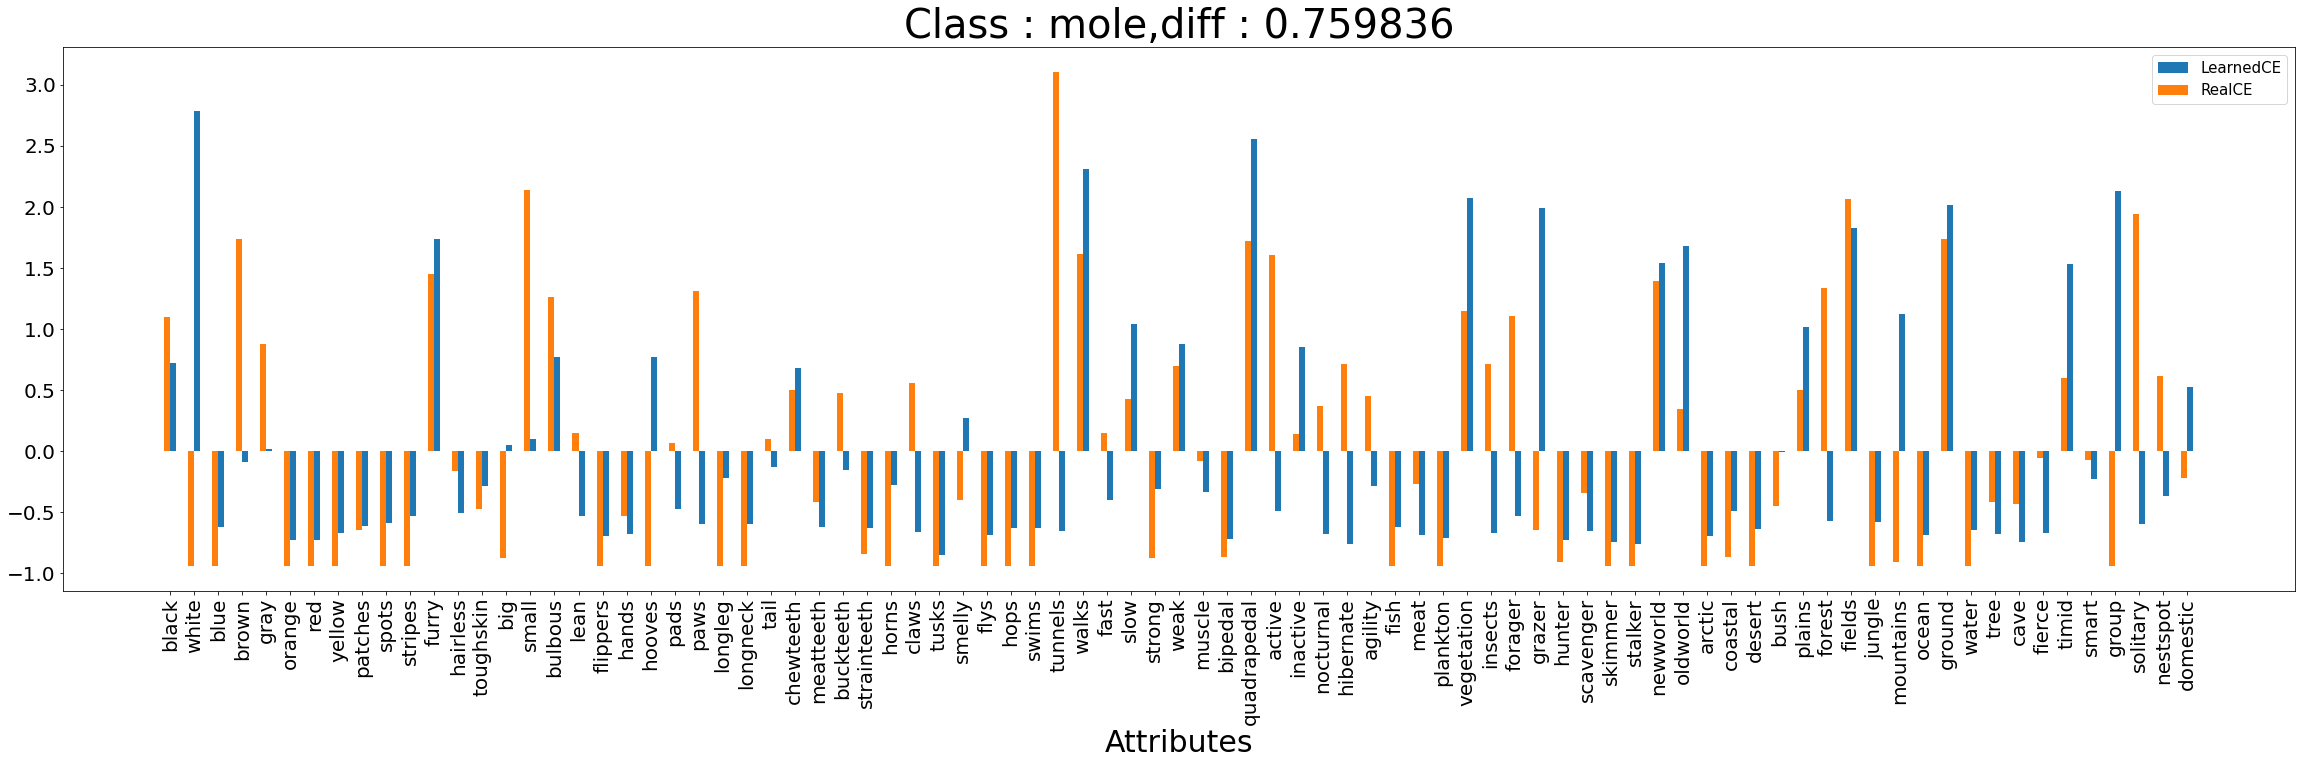

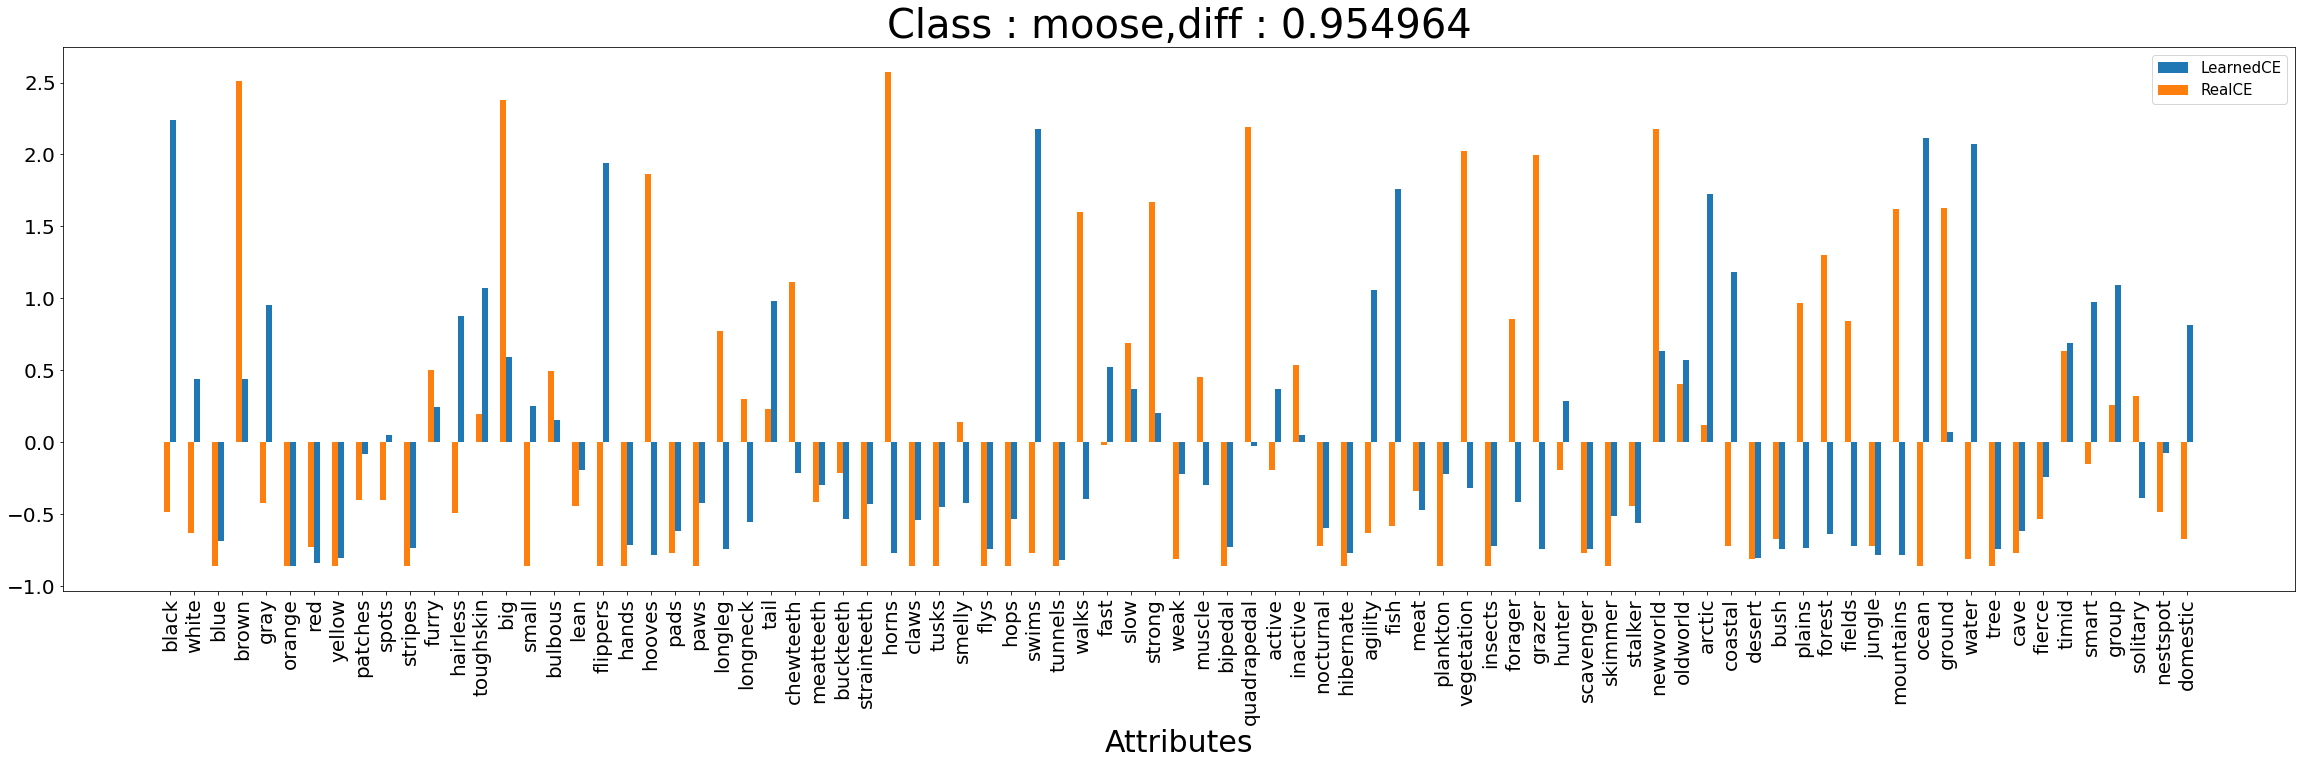

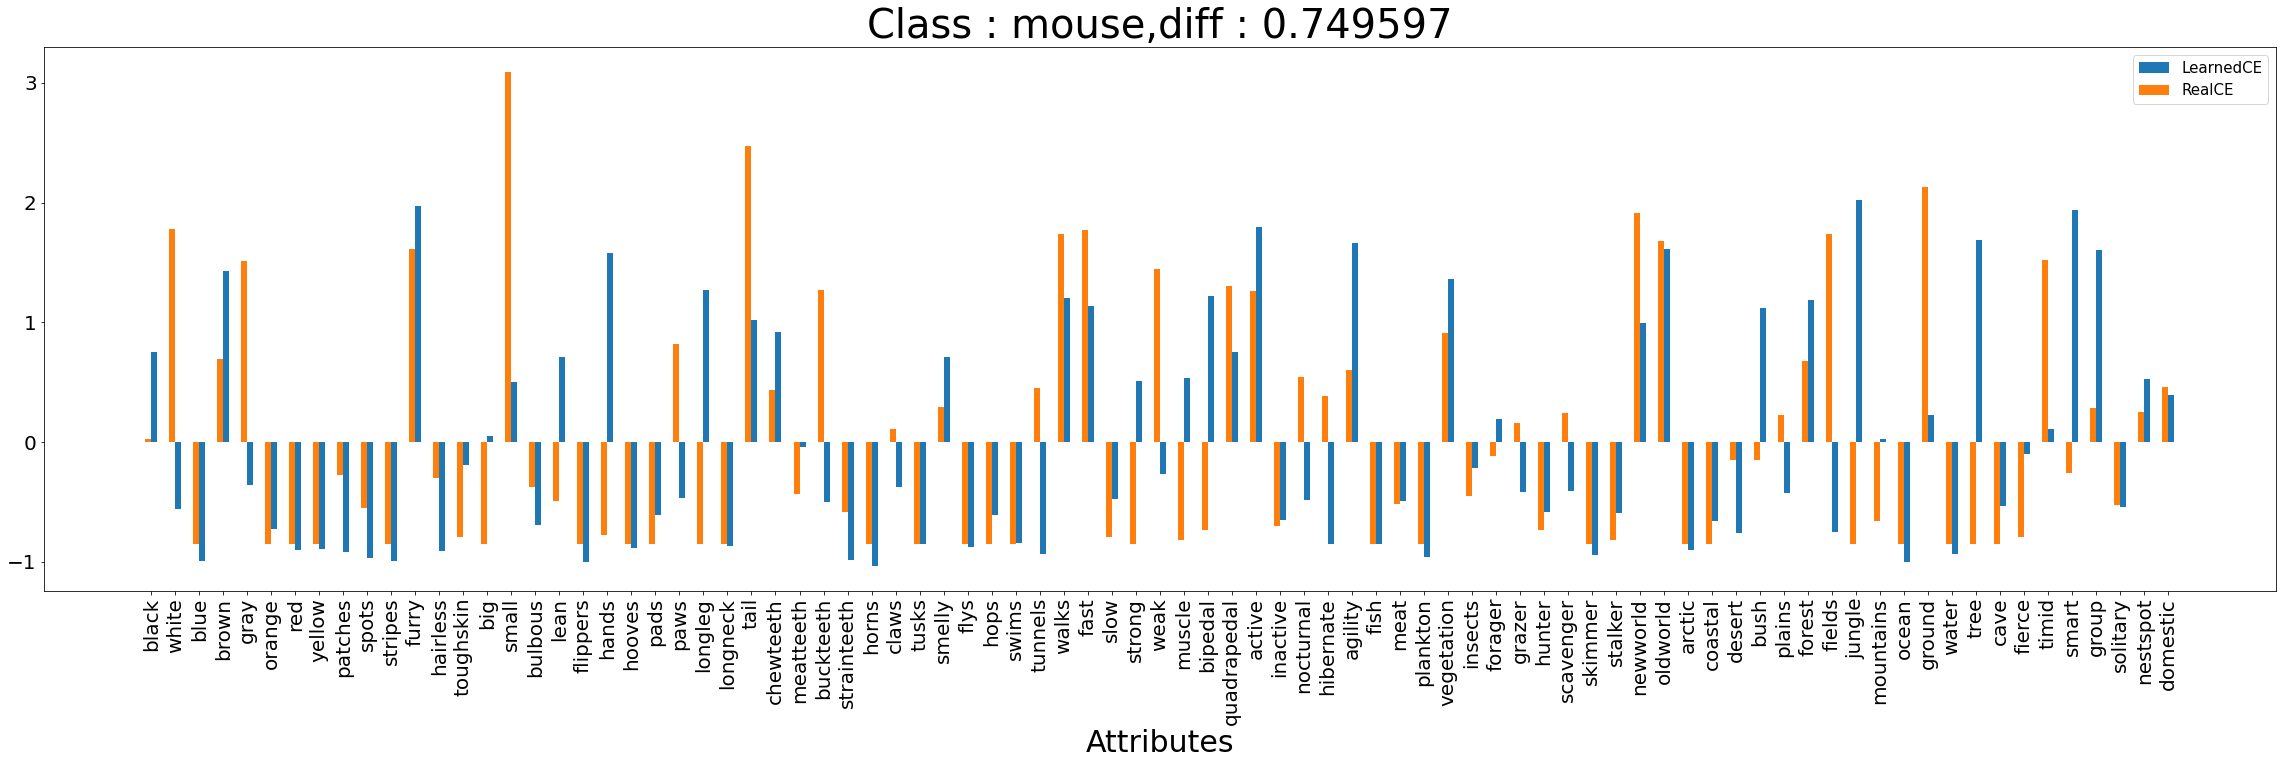

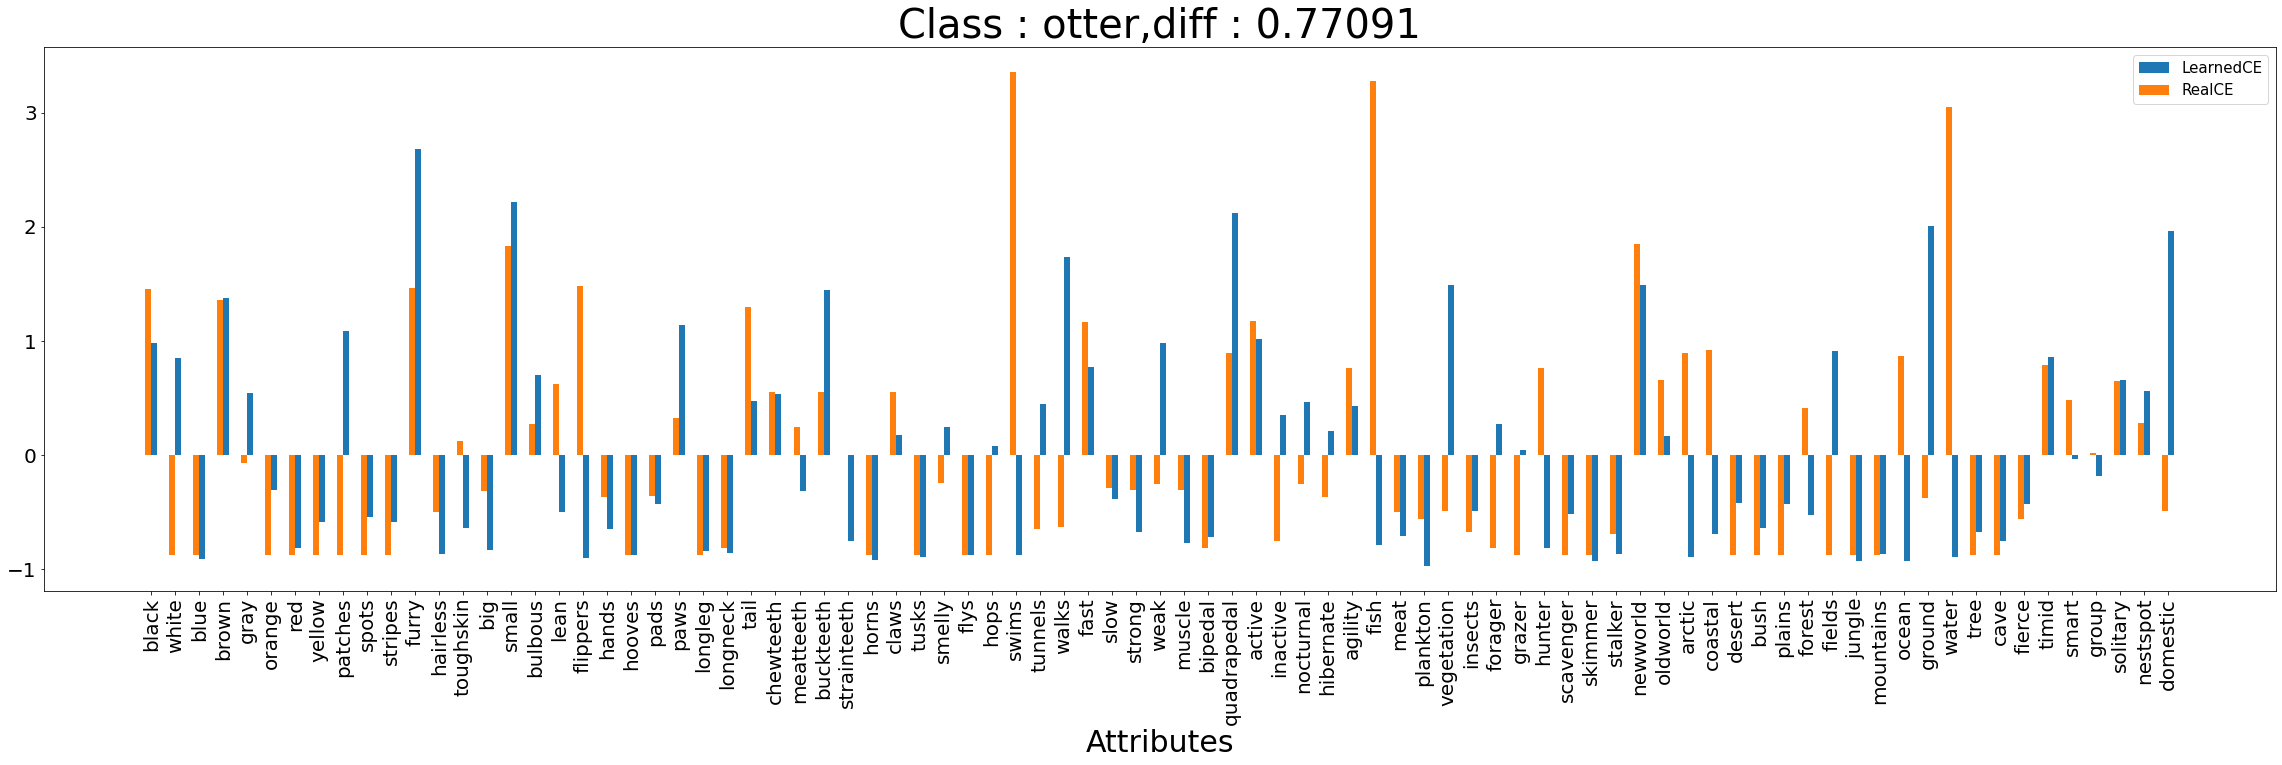

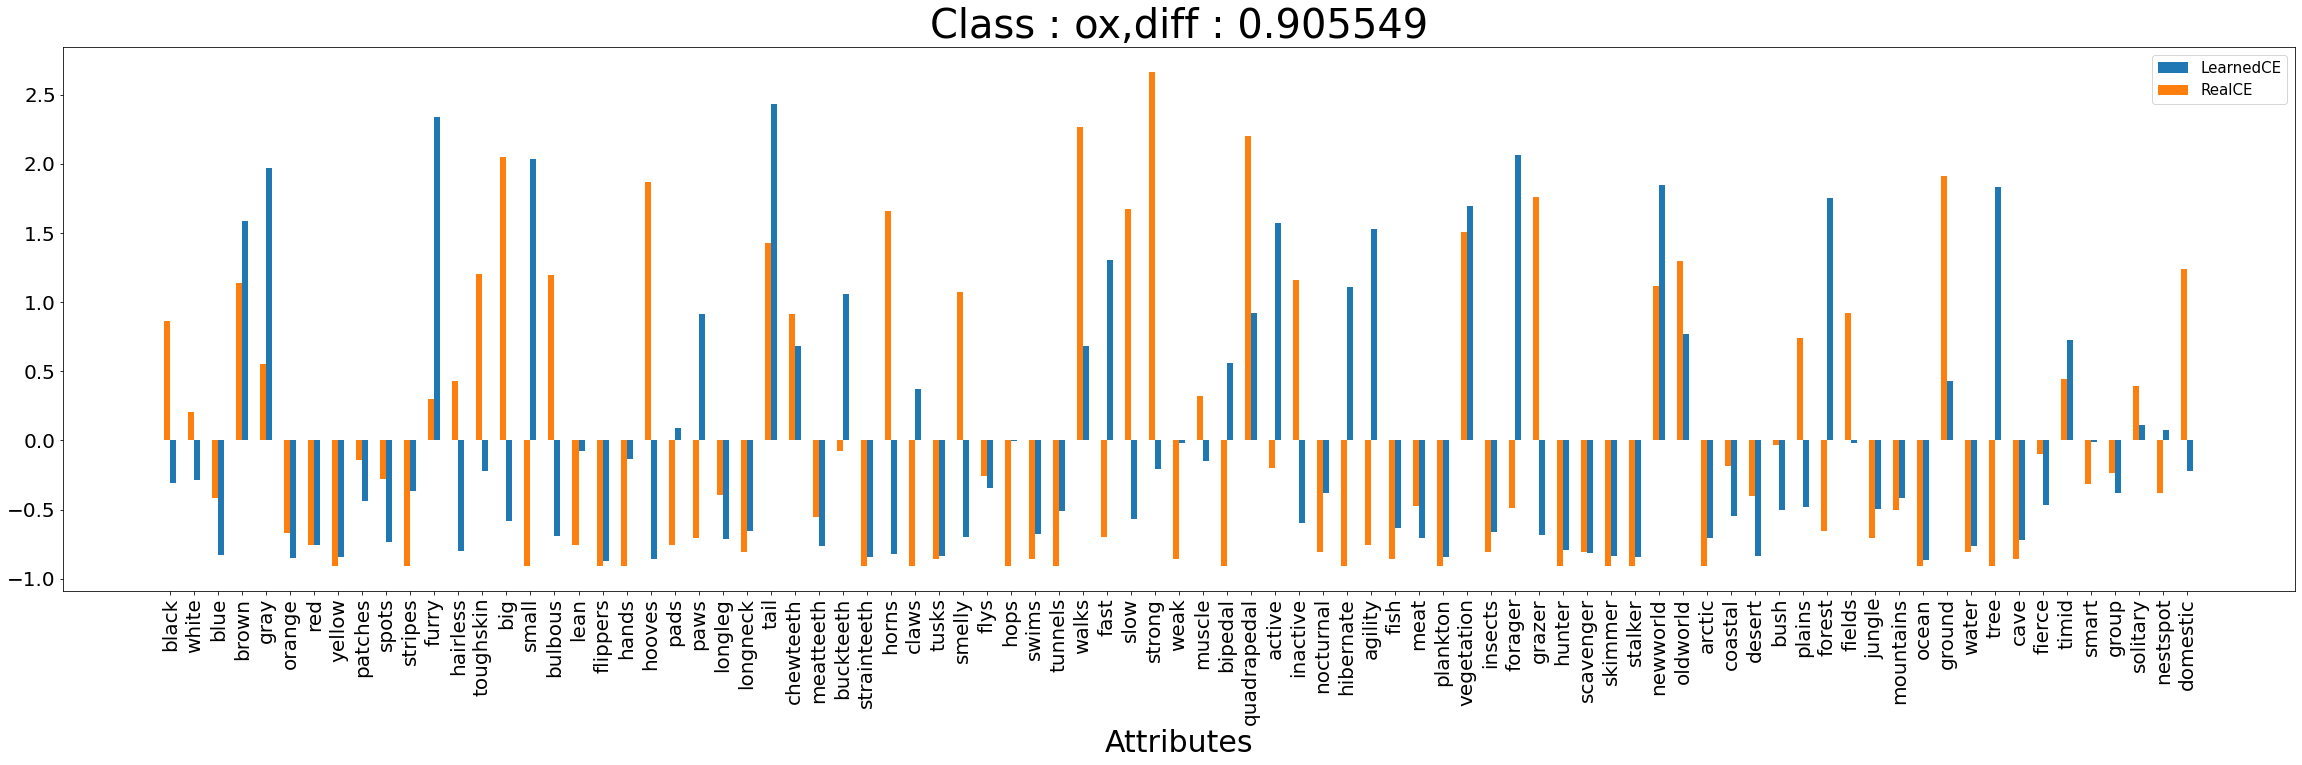

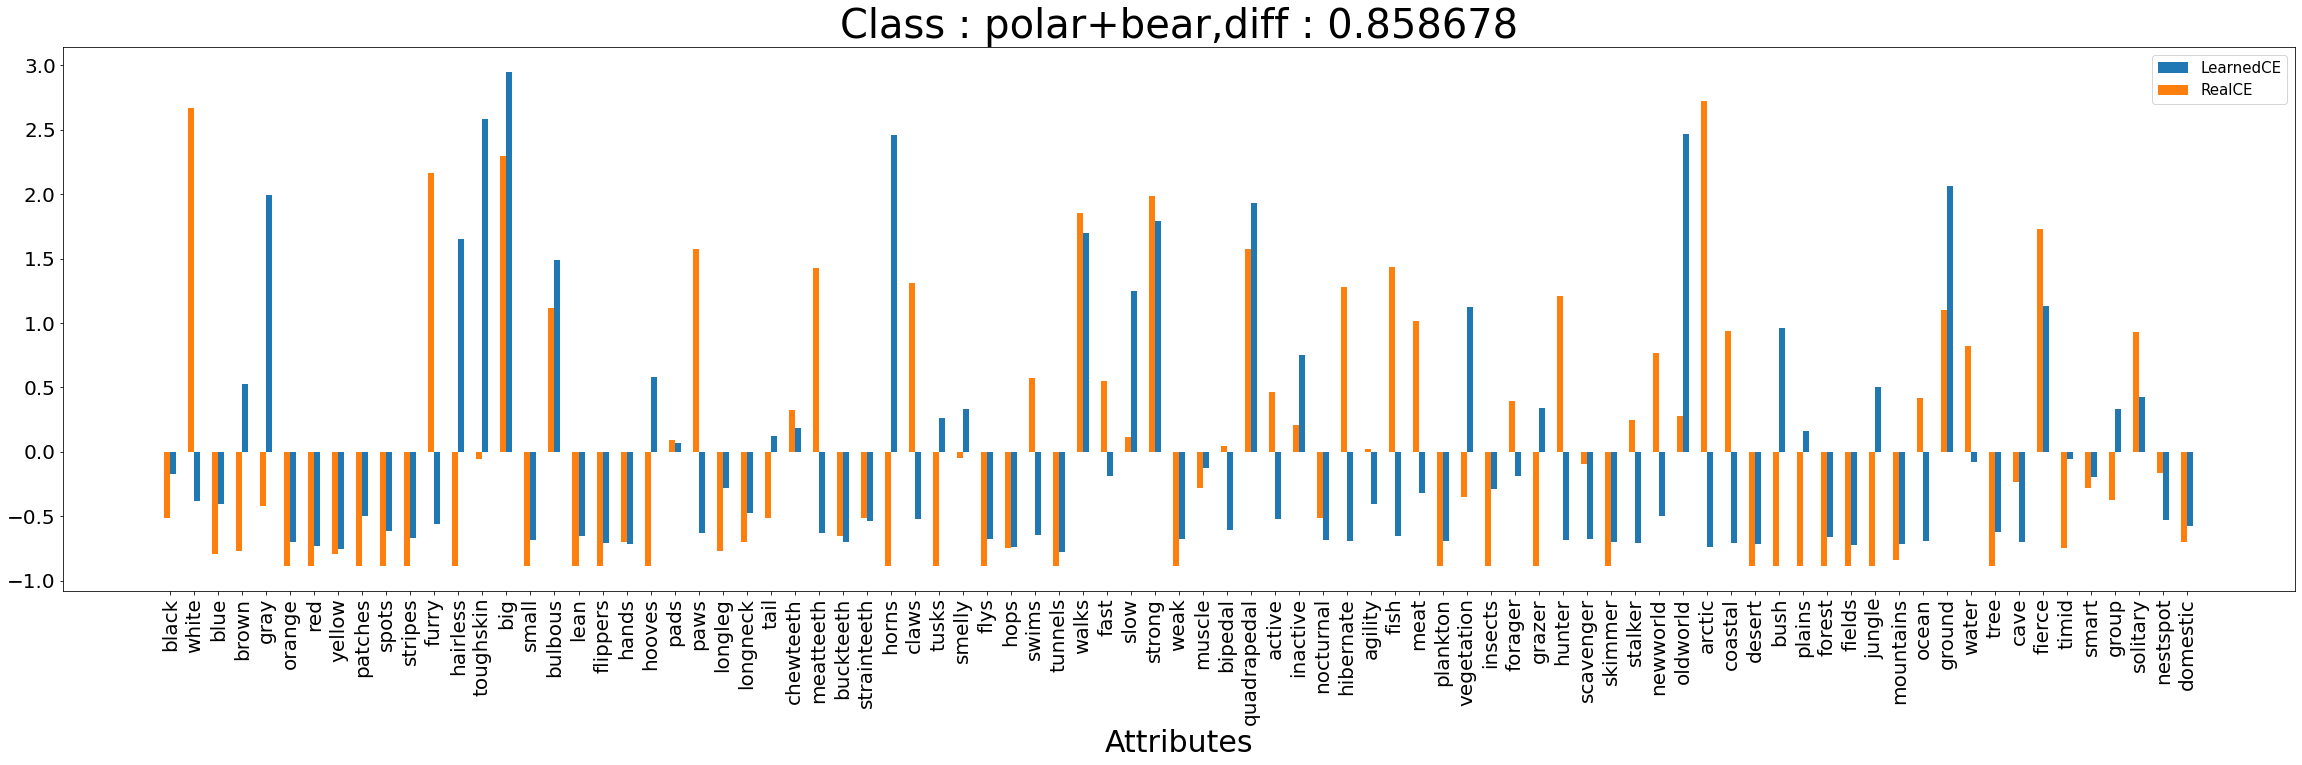

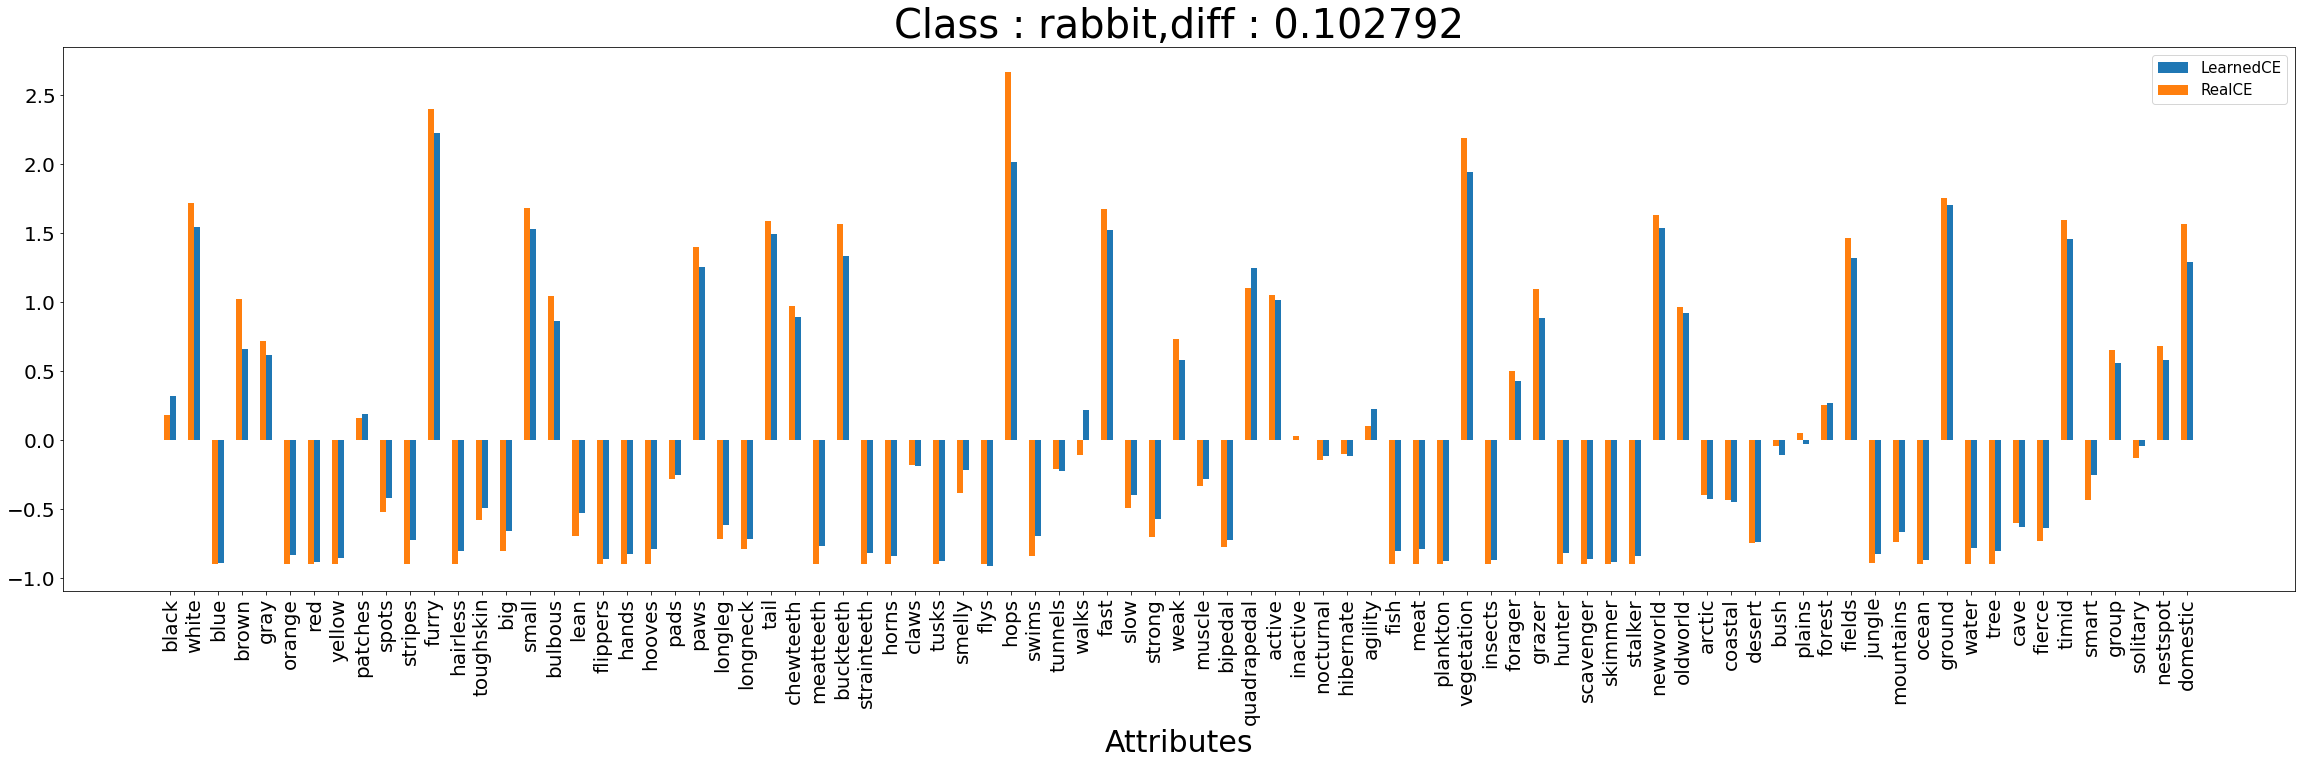

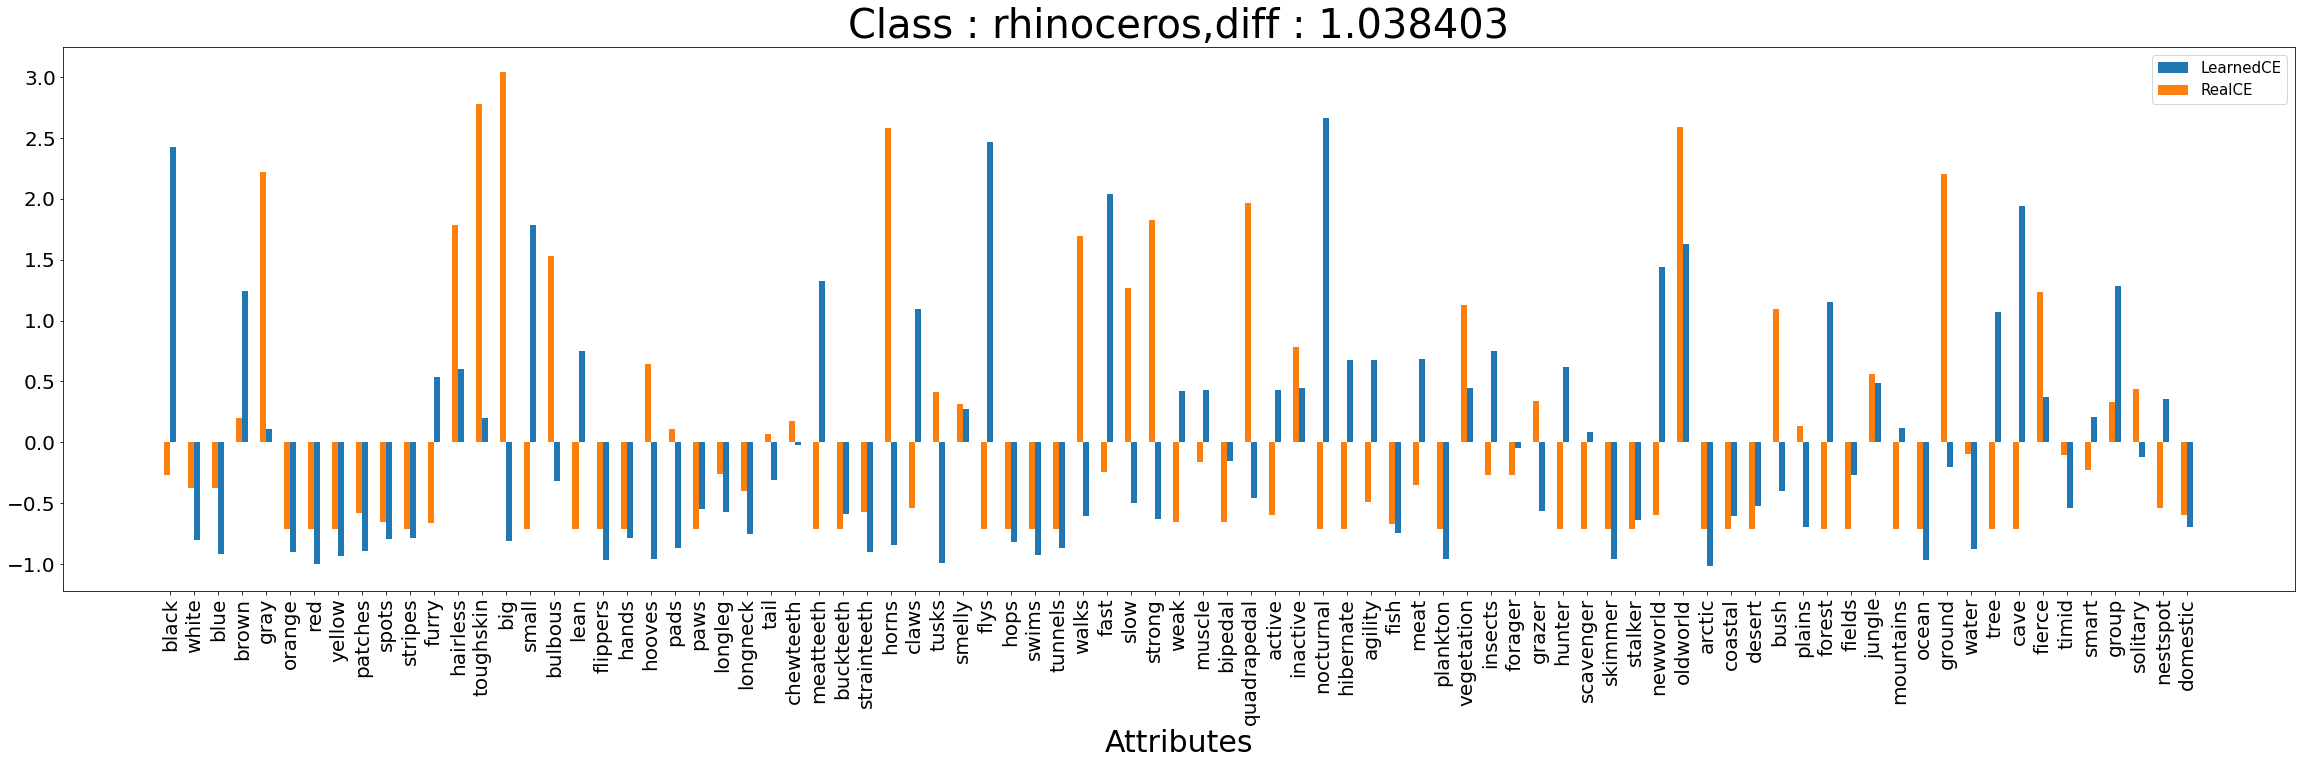

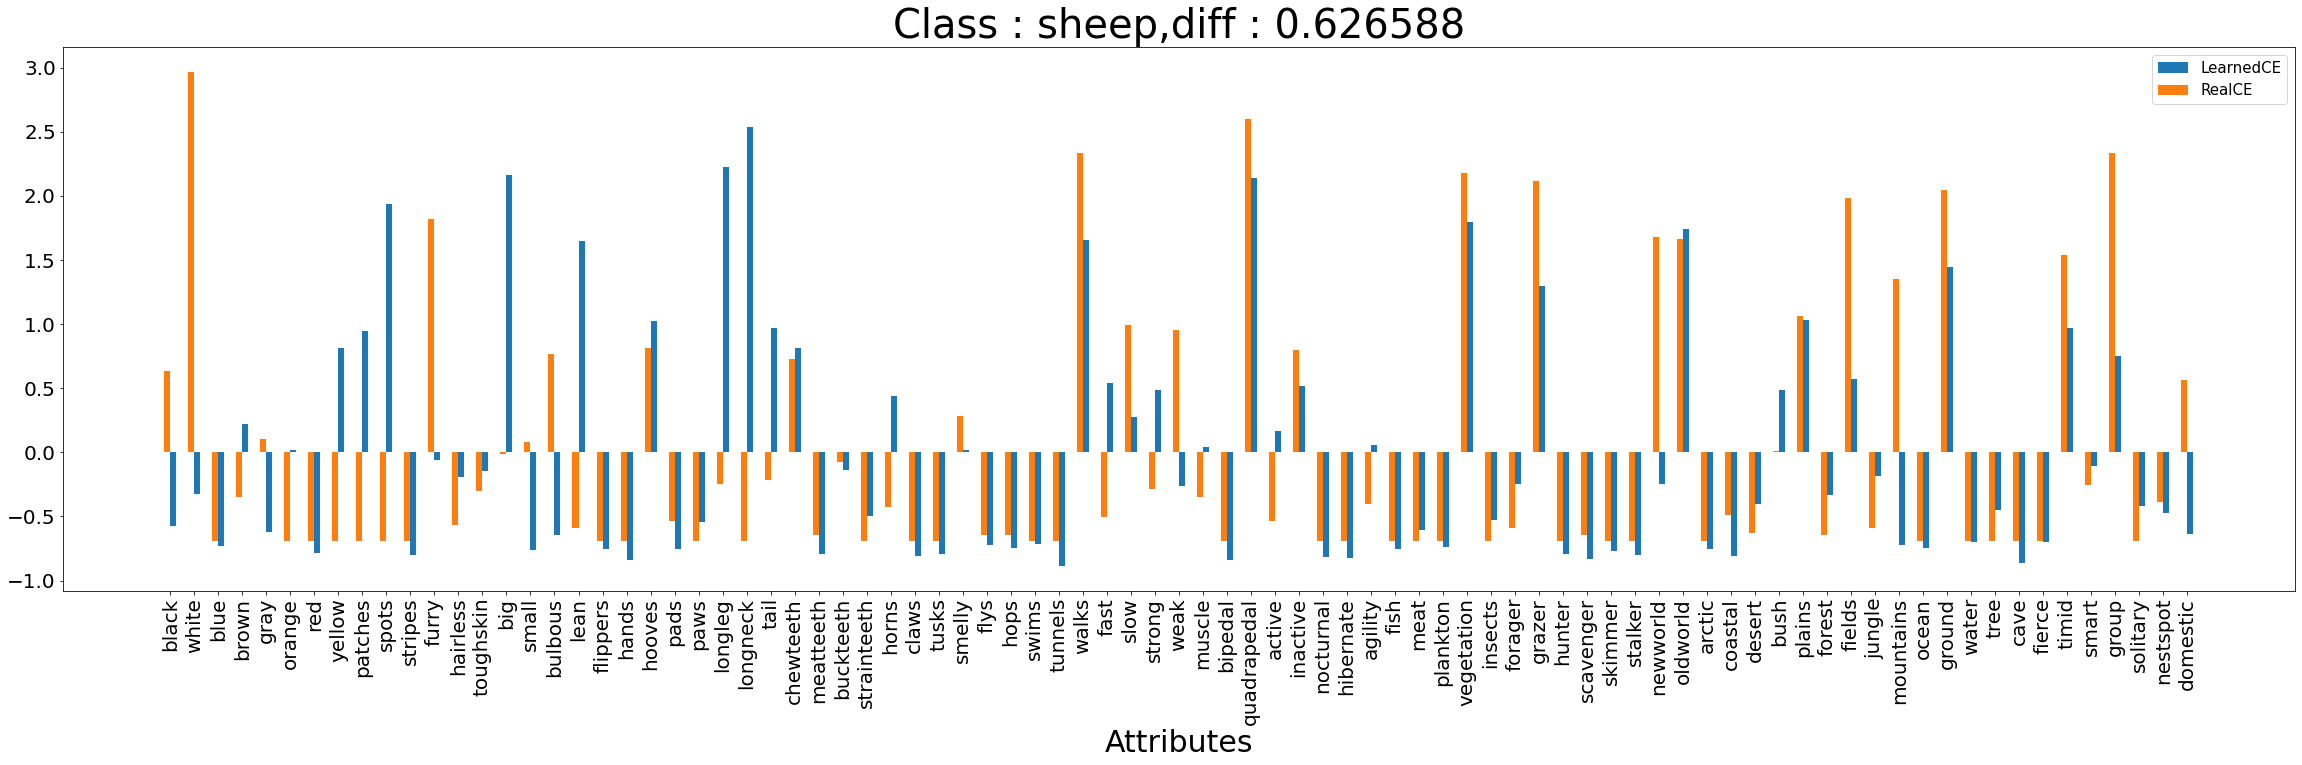

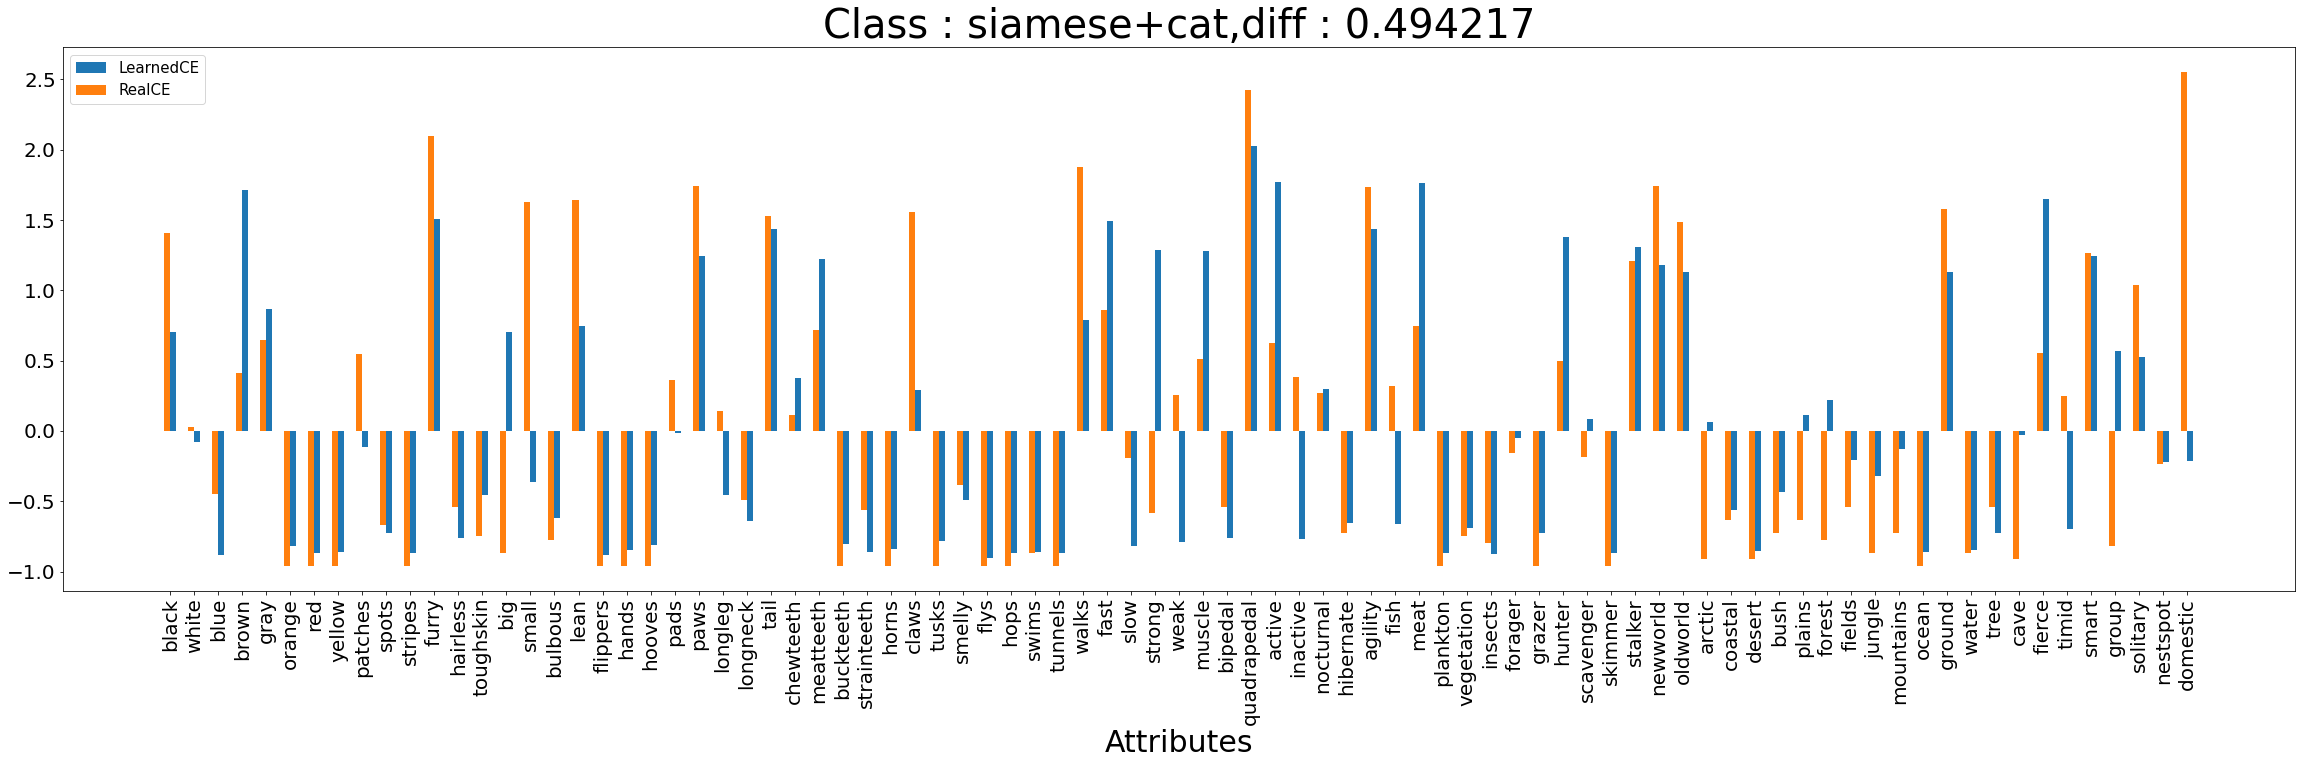

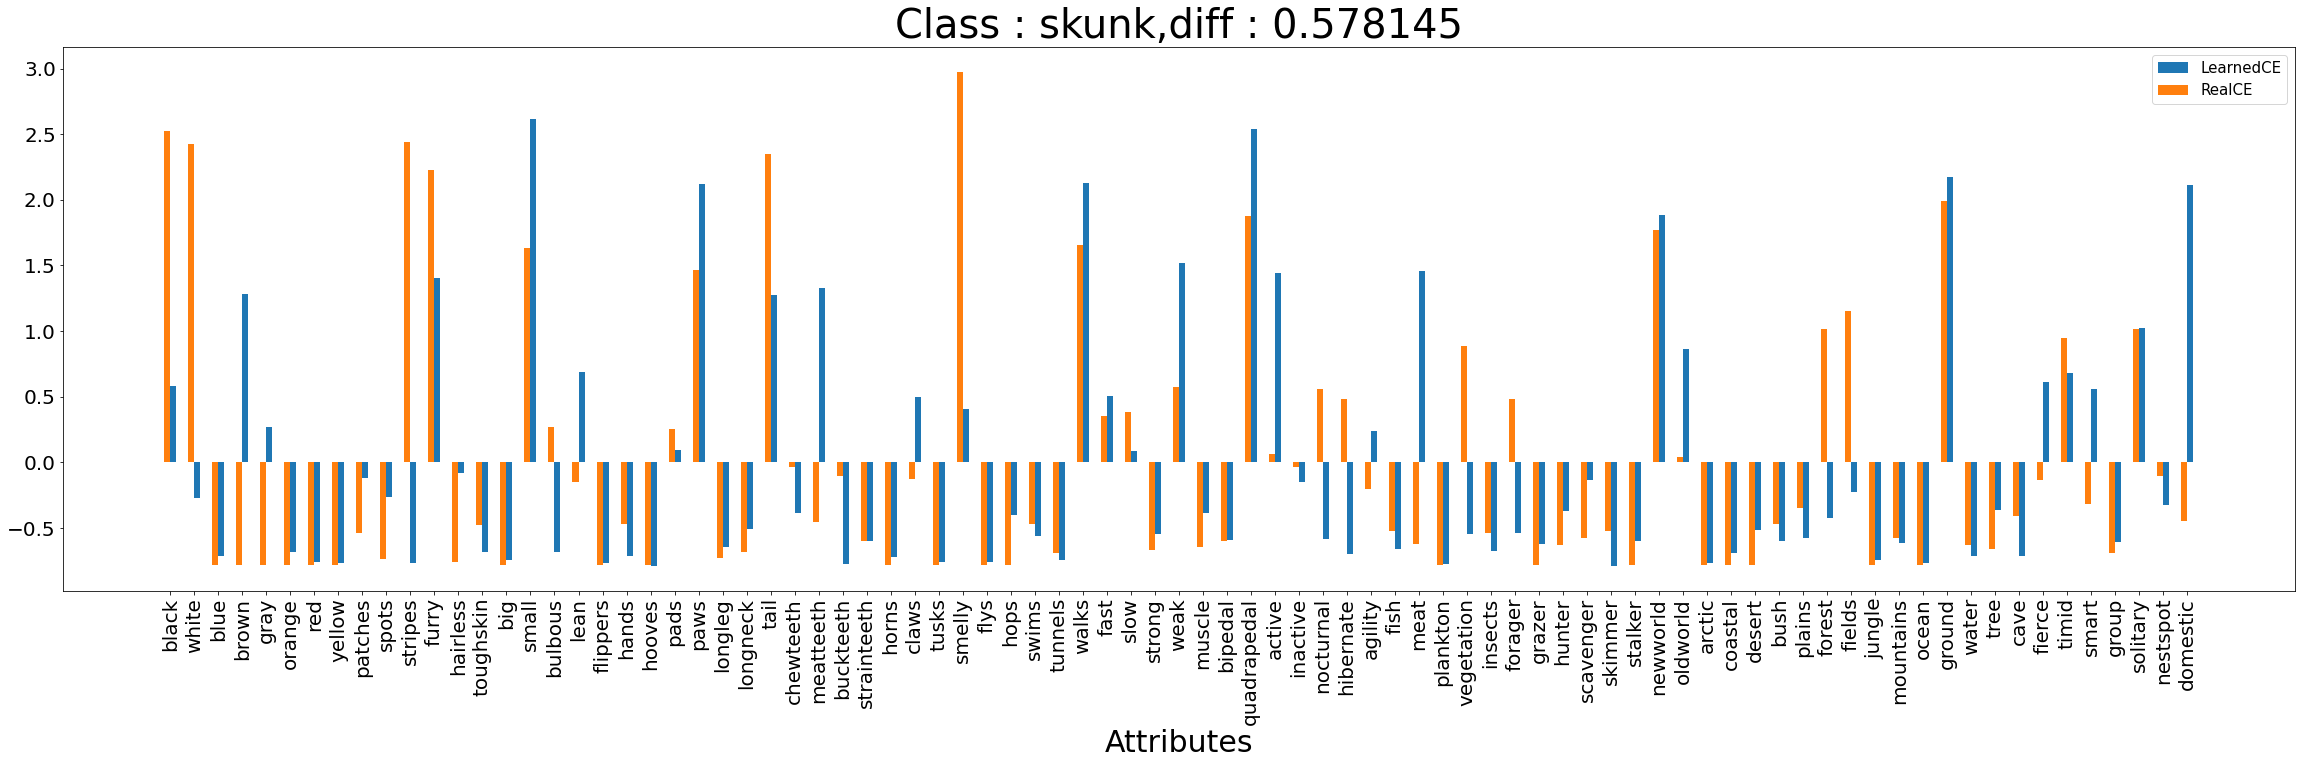

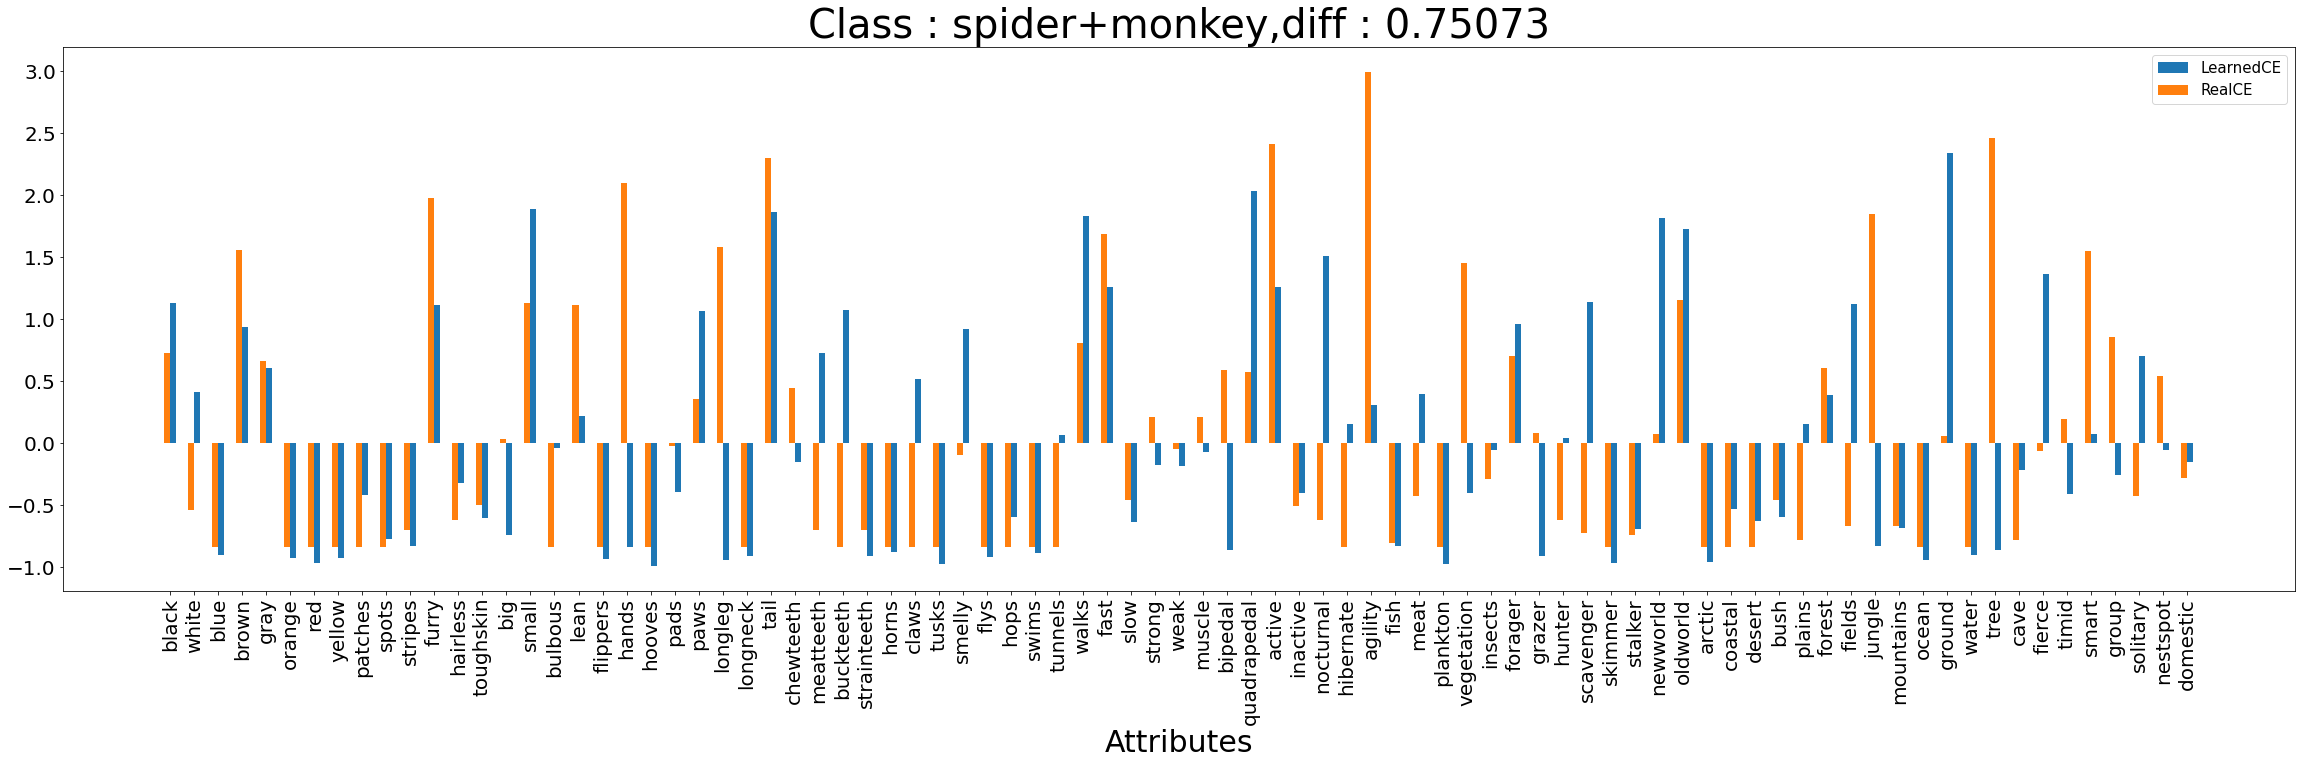

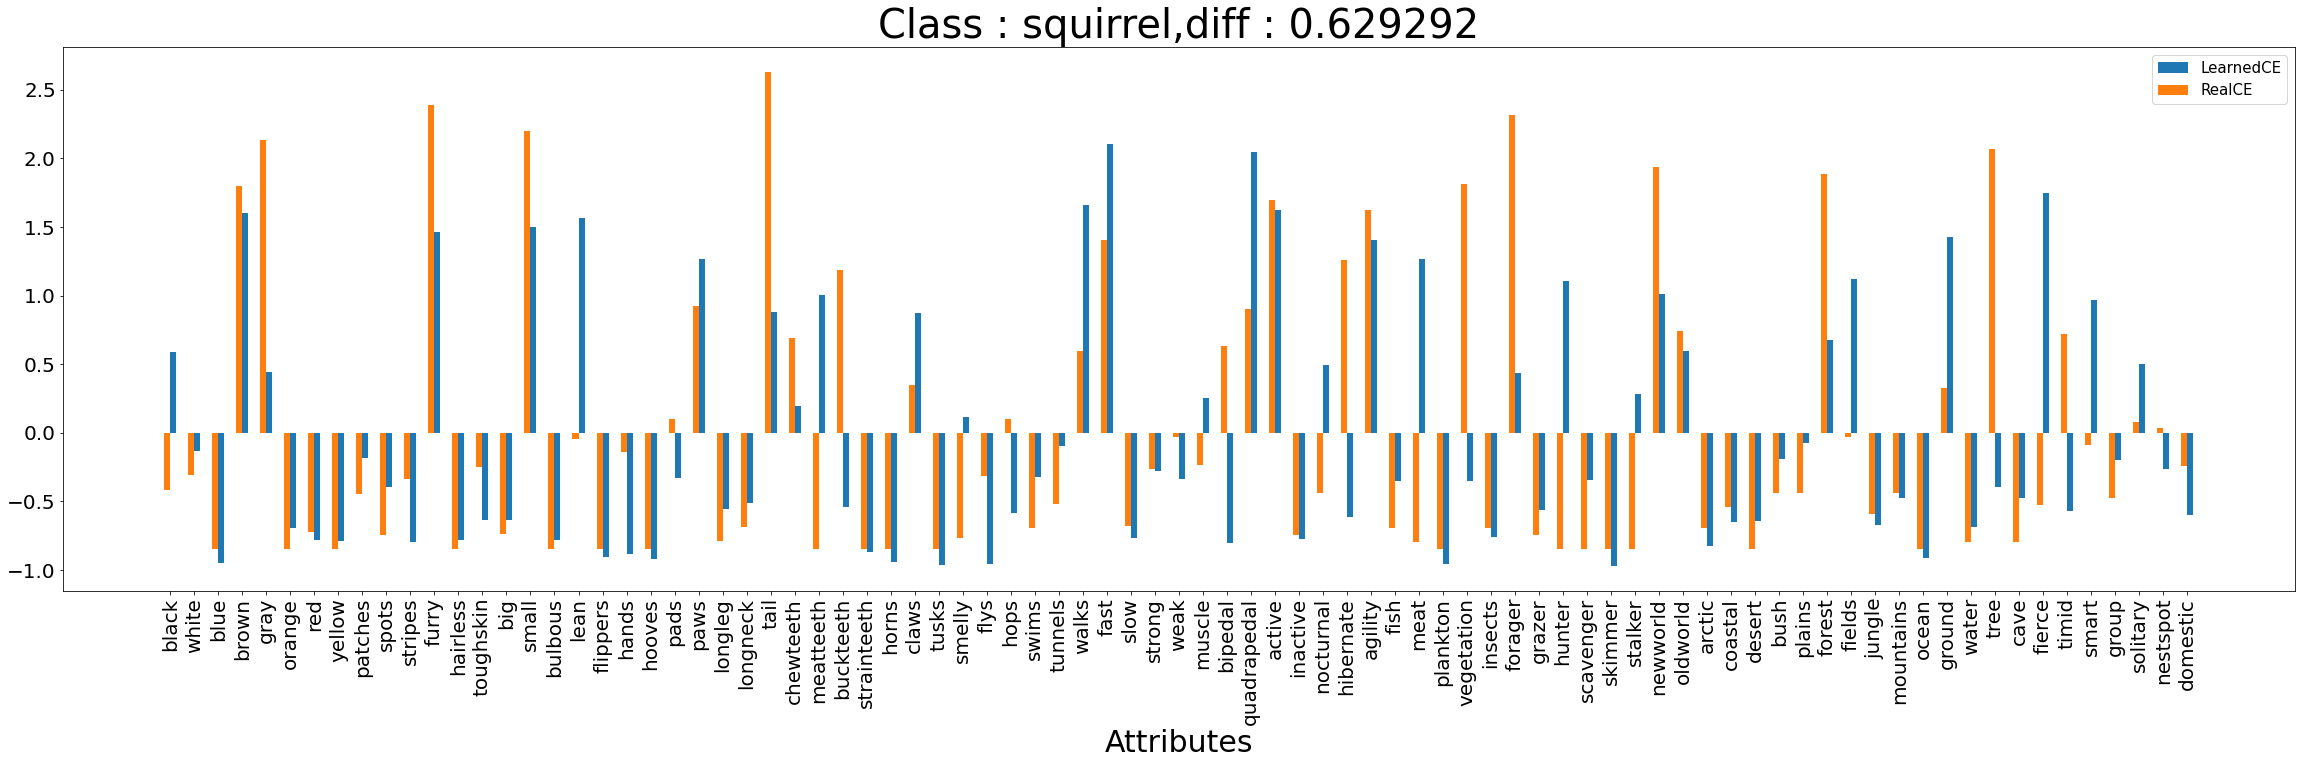

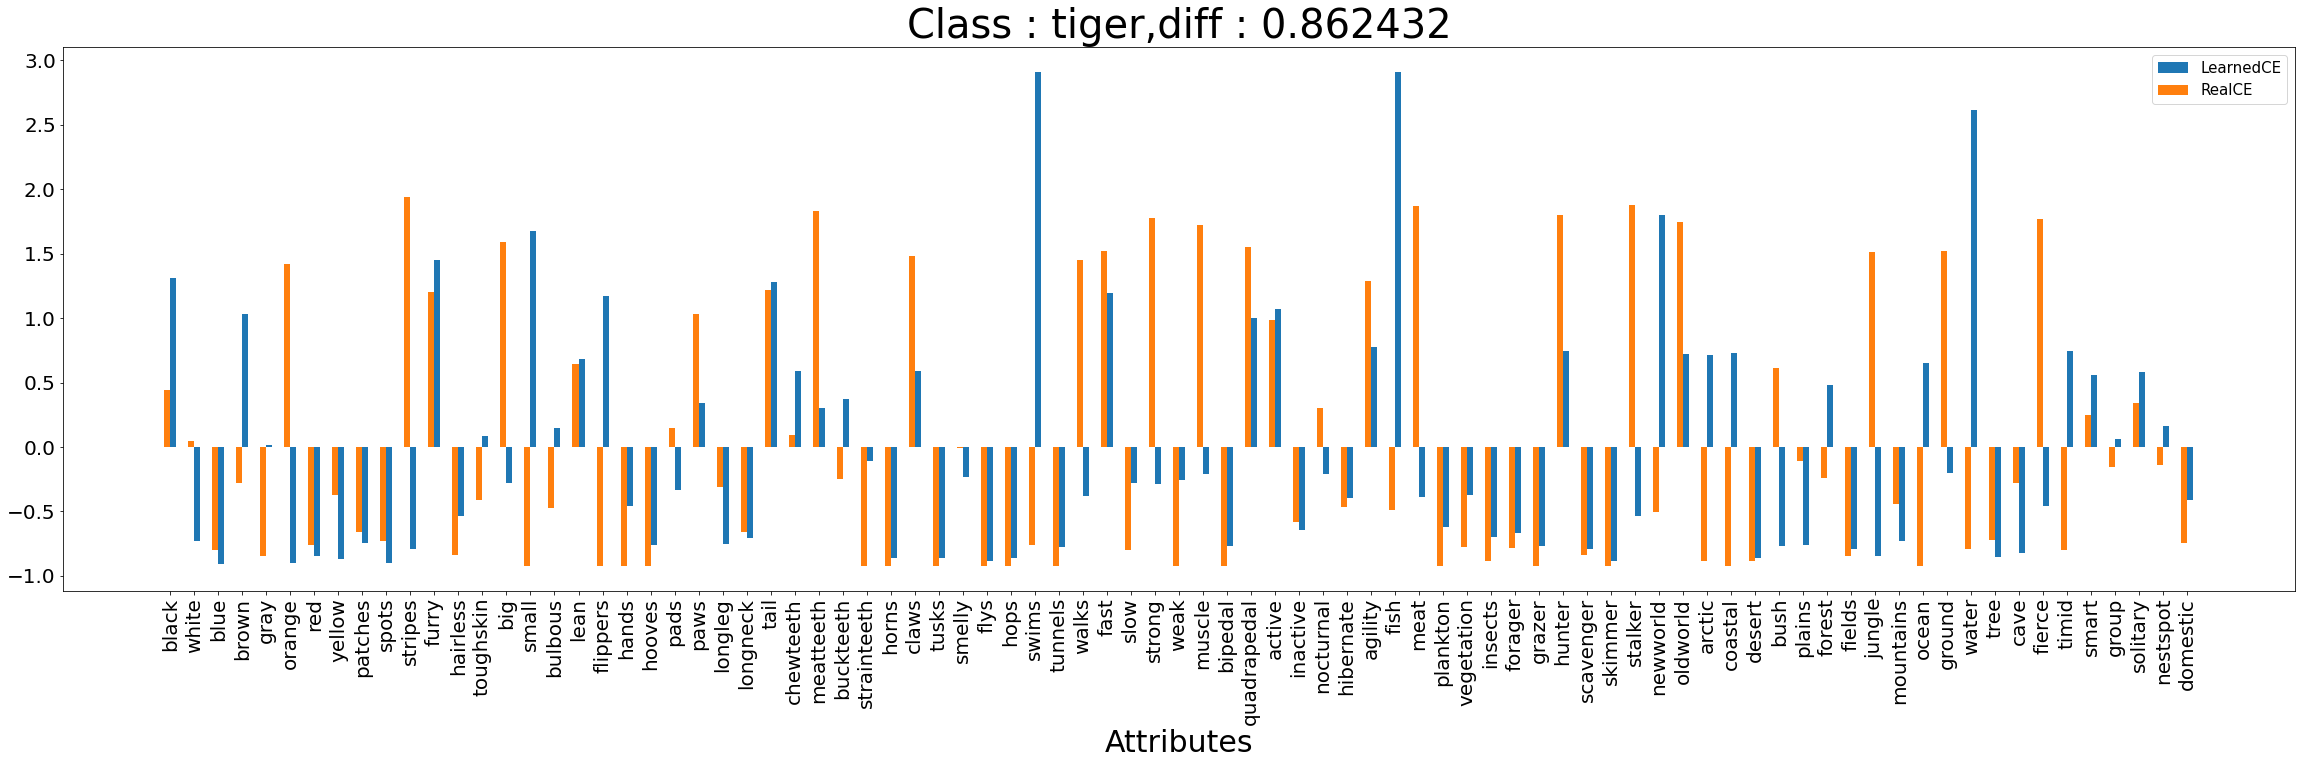

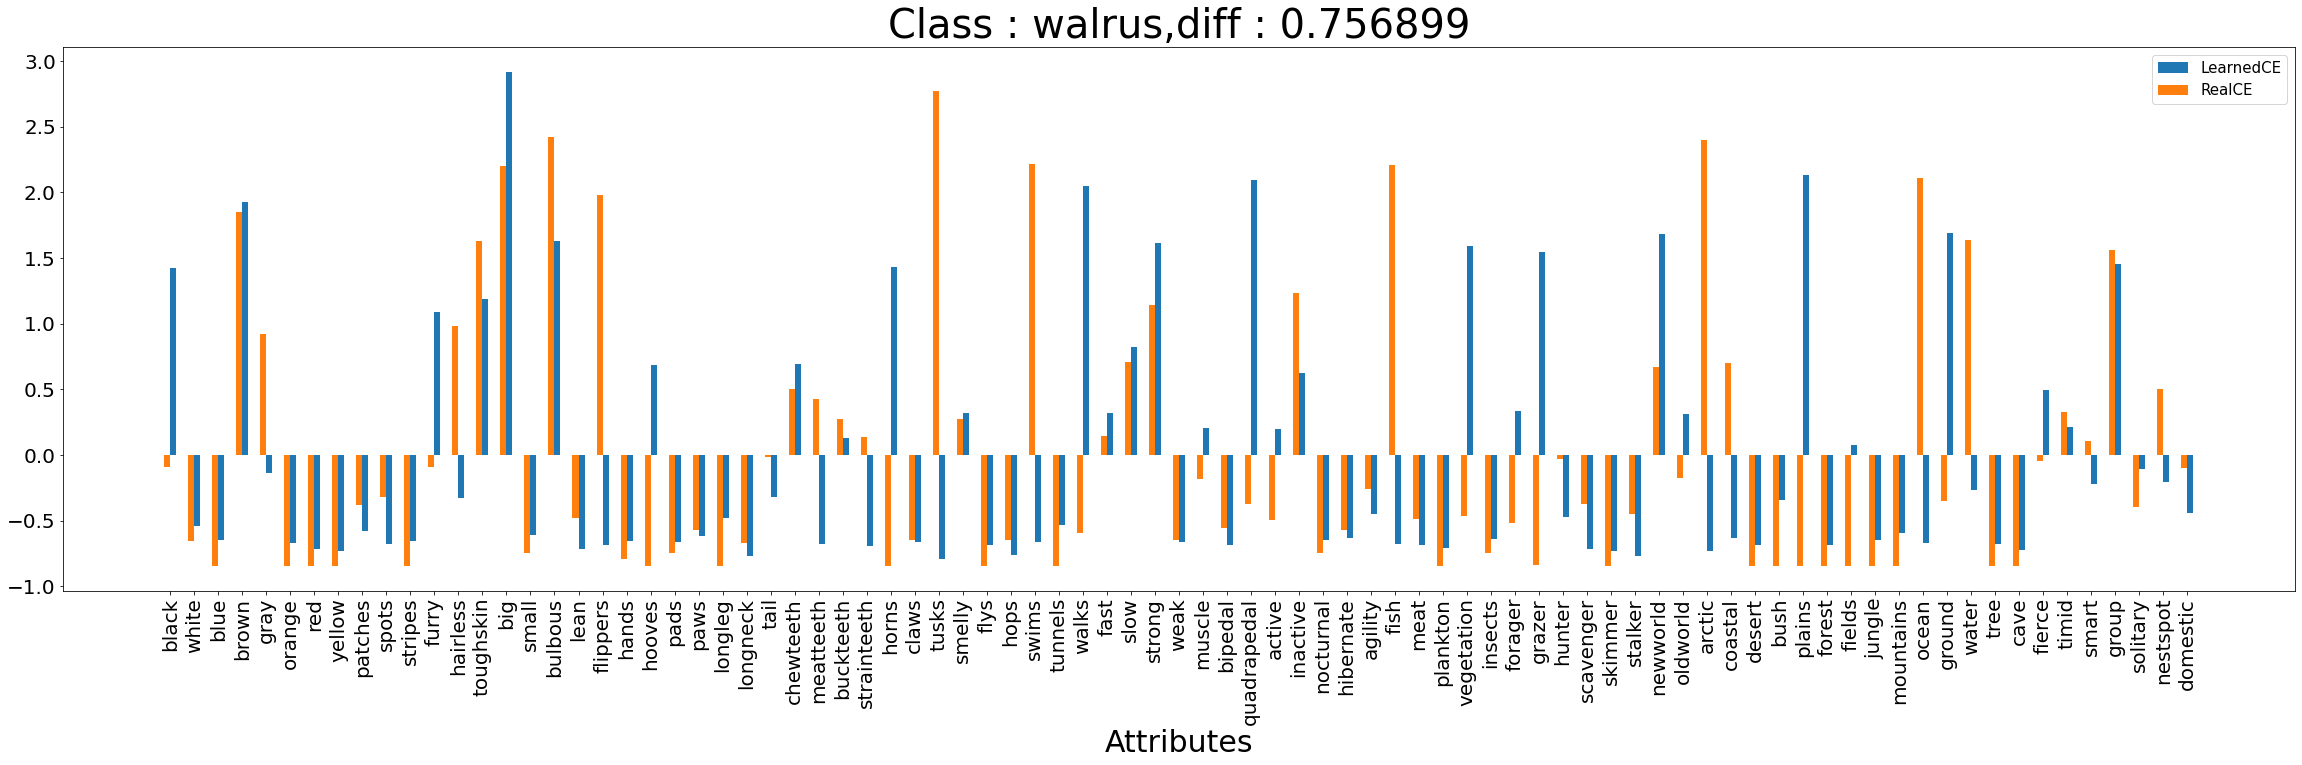

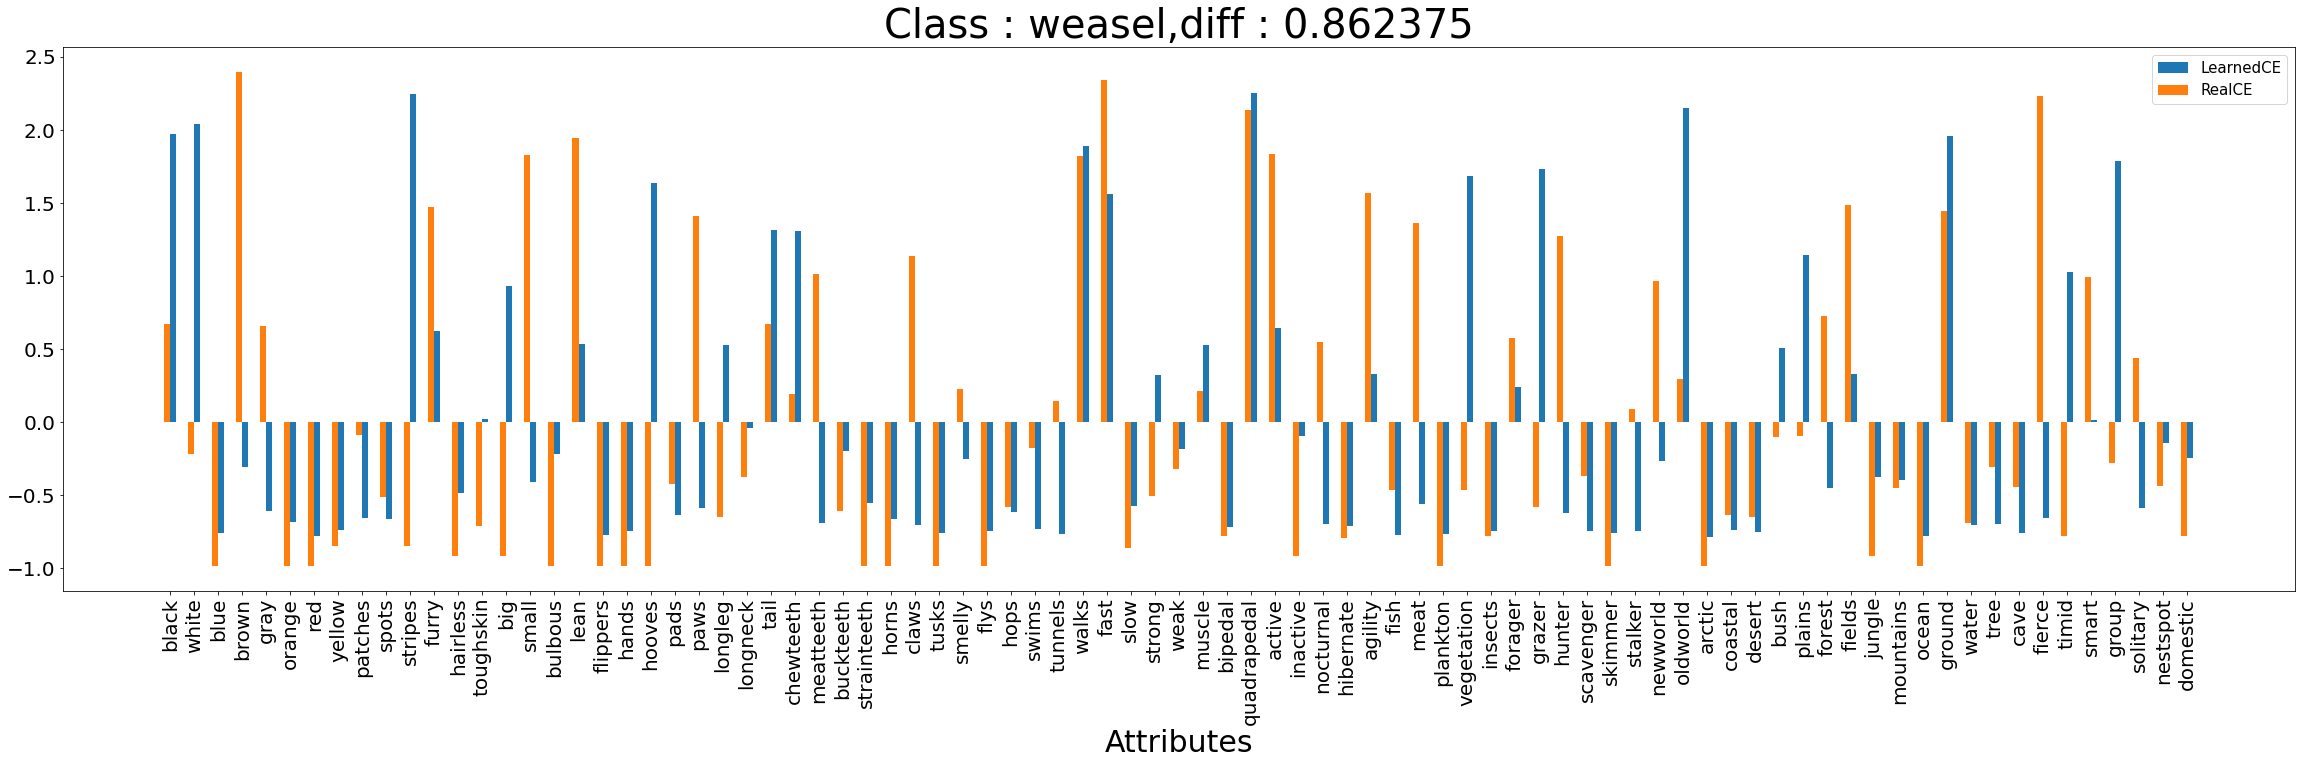

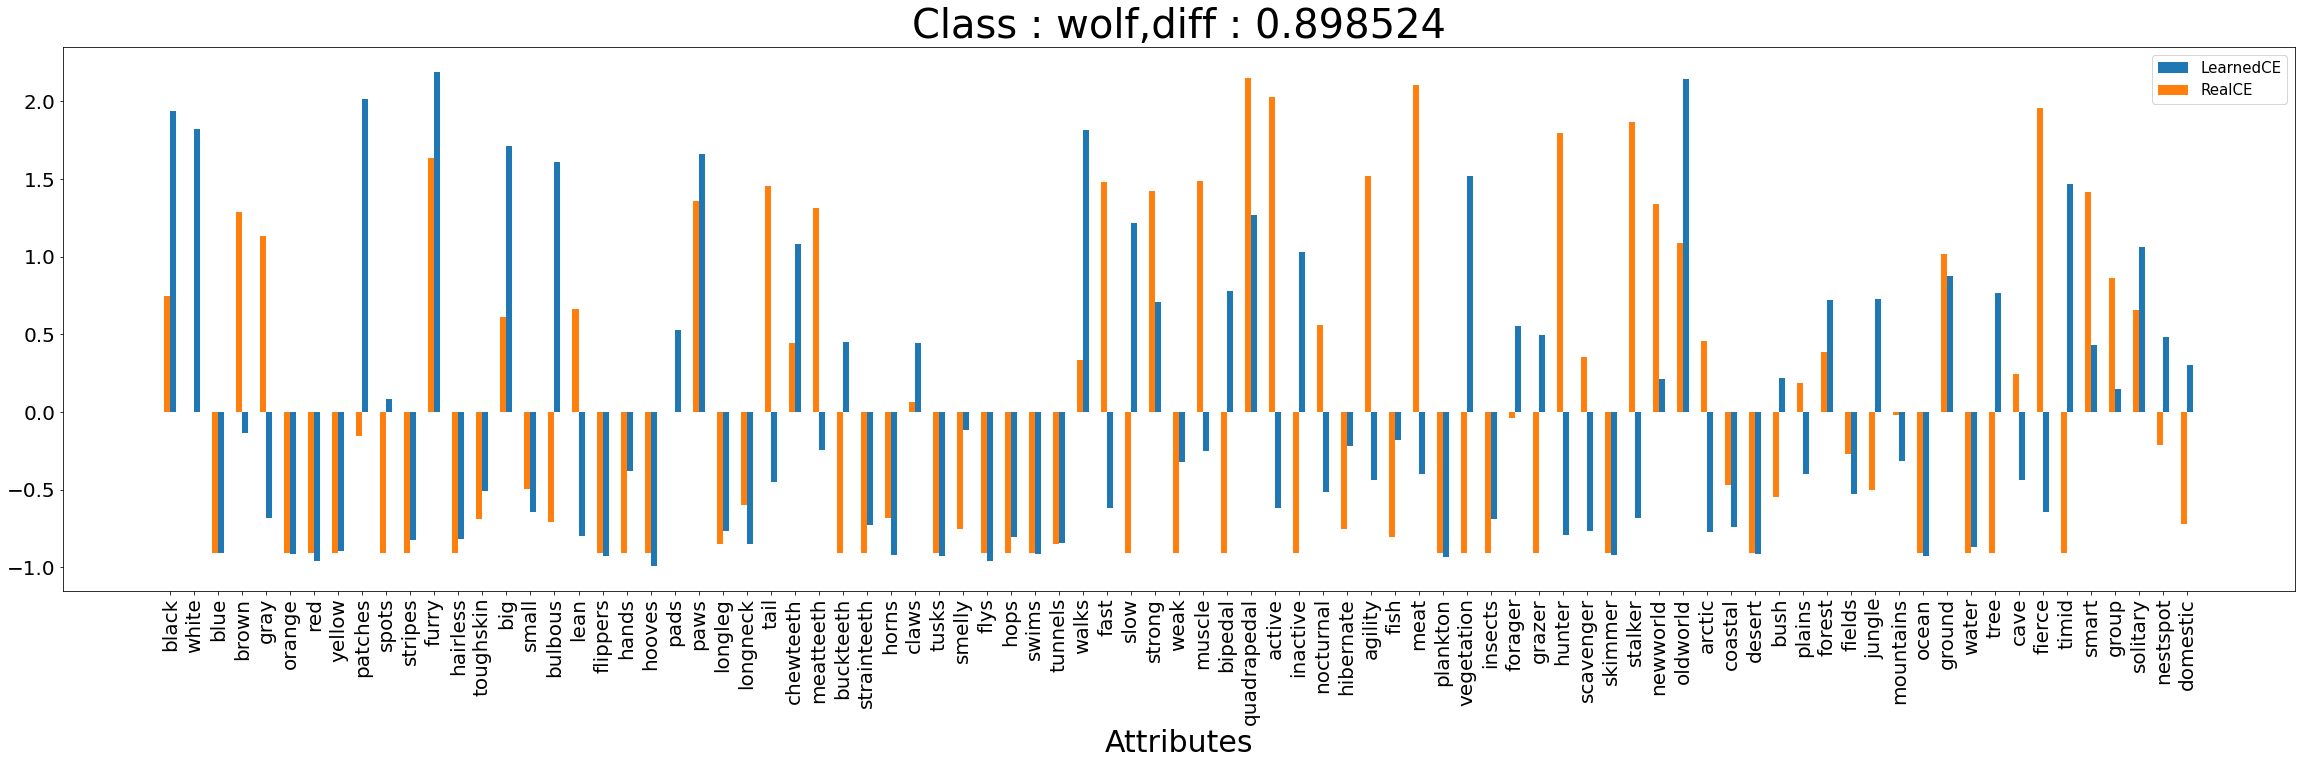

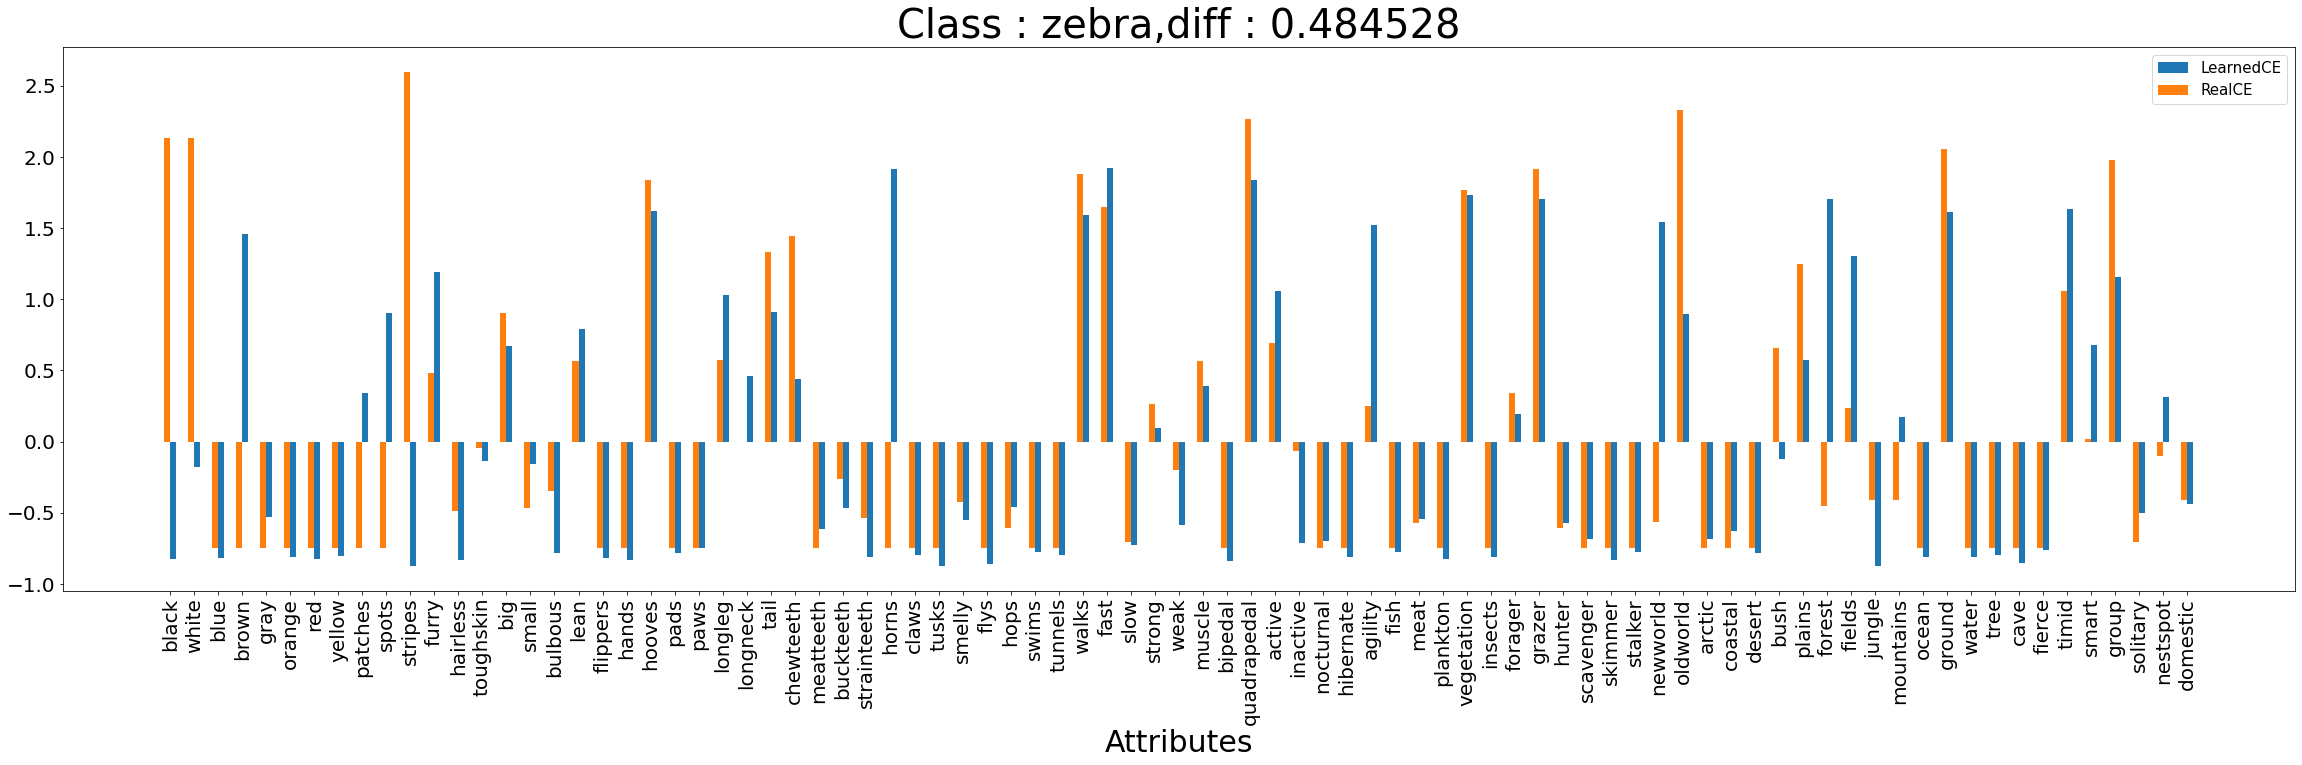

In [31]:
import matplotlib.pyplot as plt
attributes_name = pd.read_csv('./data/{}/predicates.txt'.format(dataset),header=None,sep='\t')


for i in range(seen_class_num):
    diff = round(np.sum(np.abs(sum_attr[i] - real_attr[i])) / len(real_attr[i]),6)
    plt.figure(figsize=(40,10))
    plt.bar(attributes_name[1],height=sum_attr[i],align='edge',label = 'LearnedCE',width = 0.25)
    plt.bar(attributes_name[1],height=real_attr[i],align='edge',label = 'RealCE',width=-0.25)
    plt.legend(fontsize=15) #要使用label要加這行
    plt.xlabel('Attributes',fontsize=30) # 設定x軸標題
    plt.xticks(fontsize=20,rotation='vertical')
    plt.yticks(fontsize=20)
    plt.title('Class : ' + seen_class[i] +',diff : '+ str(diff),fontsize=40) # 設定圖表標題
#     plt.savefig('./data/{}/mat/{}_{}/seen/{}.jpg'.format(dataset,feature_type,attr_type,seen_class[i]))
    plt.show()
